
# Bay Area Single Family Home Price Prediction 

### Time Series Modeling (ARIMA, SARIMA, Prophet, ... )

#### Reza Taeb
<br>


<br>
Source of Data:


https://car.sharefile.com/share/view/s0c02663a5c54e23a

### Main Goal 

In this project, I am exploring the Bay Area Single Family market. I am modeling single-family home prices utilizing various time series approaches such as ARIMA, SARIMA, Prophet, etc.


### Users

The users of this project and its output could vary from current property owners to prospective property investors, either households or institutions. 

### Dataset 

The original dataset is captured from https://car.sharefile.com/share/view/s0c02663a5c54e23a
 
This dataset originally contains the County sales data, which is generated from a survey of more than 90 associations of REALTORS® throughout the state and represents statistics of existing single-family homes. Sample data has been refined and modified recently to increase the accuracy of the statistics; The dataset has the Monthly Median Price of existing single-family homes in all counties of California starting from January 1990 to March 2021. For this project, I separated the data related to the Bay Area region. S.F. Bay Area has been redefined to include the following counties: Alameda, Contra Costa, Marin, Napa, San Francisco, San Mateo, Santa Clara, Solano, and Sonoma.


<br>

In [1]:
# Import necessary libraries and packages

import pandas as pd
import numpy as np
import seaborn as sns
import math
import scipy as sp
import itertools
from pandas.tseries.offsets import DateOffset
import os  #provides functions for interacting with the operating system
import pickle

from matplotlib import pyplot as plt
from IPython.display import Image
import altair as alt
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statistics
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


### Time Series Modeling ###

*Time* is the most important factor which ensures success in a business. It’s difficult to keep up with the pace of time.  But, technology has developed some powerful methods using which we can ‘see things’ ahead of time. 

Time Series Modeling can help us extract some insights from past, and do some forecast about future. As the name suggests, it involves working on time (years, months, days, hours, minutes) based data, to derive hidden insights from a business or industry to make informed decision making.

There are various time series techniques which I am going to apply several of them in this project.

The below chart shows an example of general time series approach. 

<br>

<img src="TimeSeriesChart.png" alt="drawing" width="700" height="1200"/>

## 1 - ARIMA Model  (Autoregressive Integrated Moving Average)

**ARIMA** is a very popular technique for time series modeling. It describes the correlation between data points and takes into account the difference of the values. This method uses a number of lagged observations of time series to forecast observations

<br>

ARIMA models should be used on stationary data only. One should therefore remove the trend of the data (via deflating or logging), and then look at the differenced series.


ARIMA Documentation: 

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

<img src="ARIMA_syntax.png" alt="drawing" width="800" height="1200"/>

<img src="ARIMA_params.png" alt="drawing" width="800" height="1200"/>

**Main Parameters:**

    p: the number of lag observations in the model; also known as the lag order (AR)

    d: the number of times that the raw observations are differenced; also known as the degree of differencing (I)

    q: the size of the moving average window; also known as the order of the moving average (MA)

**General Steps:**

The general steps to implement an ARIMA model are : 

- **Load the data** : The first step for model building is of course to load the dataset

- **Preprocessing** : Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.

- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations

- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value

- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model

- **Determine the p and q values**: Read the values of p and q from the plots in the previous step

- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model

- **Predict values on validation set**: Predict the future values

- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set - We need to do hypertuning 

- **Future Prediction**: The last step after finding the best model parameters is to predict future.

### 1.A. Load Dataset

Primarily, I focused on the average single-family home in the entire Bay Area, California. I explained the steps entirely on this sub dataset and afterward did the same procedure on the nine counties in the Bay Area separately. 

In [2]:
# read the dataset 
df = pd.read_csv("Data/Data-Cleaned/202103-MedianPrices-BayArea-Cleaned.csv")
df.head()

Mon-Yr      CA  Alameda  Contra-Costa   Marin    Napa  San Francisco  \
0  Jan-90  194952   226149           NaN  346153  178888         287499   
1  Feb-90  196273   219306           NaN  338333  186363         300877   
2  Mar-90  194856   225162           NaN  358571  180000         290151   
3  Apr-90  196111   229333           NaN  359574  158571         288725   
4  May-90  195281   232291           NaN  374999  187692         282626   

   San Mateo  Santa Clara  Solano  Sonoma  S.F. Bay Area  
0        NaN       271840     NaN  174022         227366  
1        NaN       273100     NaN  180294         234739  
2        NaN       275500     NaN  178823         235337  
3        NaN       274660     NaN  184117         233178  
4        NaN       266670     NaN  185844         235881

In [3]:
# Checking Columns Type and Shape of the DataFrame
print (df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Mon-Yr         375 non-null    object 
 1   CA             375 non-null    int64  
 2   Alameda        375 non-null    int64  
 3   Contra-Costa   183 non-null    float64
 4   Marin          375 non-null    int64  
 5   Napa           375 non-null    int64  
 6   San Francisco  375 non-null    int64  
 7   San Mateo      363 non-null    float64
 8   Santa Clara    375 non-null    int64  
 9   Solano         326 non-null    float64
 10  Sonoma         375 non-null    int64  
 11  S.F. Bay Area  375 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 35.3+ KB
None
(375, 12)


### 1.B. Data Preprocessing

1 - Change the Mon-Yr format from object to datetime

2 - Rename some columns  

3 - Deal with Null entries

4 - Set 'Time' column as index 

In [4]:
# Change the Mon-Yr column format to datetime 

df['Mon-Yr']= pd.to_datetime(df['Mon-Yr'], format='%b-%y')
 
# Rename the Column name from S.F. Bay Area to Bay Area and Mon-Yr to Time and Contra-Costa

df = df.rename(columns={"Mon-Yr": "Time", "S.F. Bay Area":"Bay Area", "Contra-Costa": "Contra Costa"})

In [5]:
# Count the number of nulls in each column 

df.isnull().sum()

Time               0
CA                 0
Alameda            0
Contra Costa     192
Marin              0
Napa               0
San Francisco      0
San Mateo         12
Santa Clara        0
Solano            49
Sonoma             0
Bay Area           0
dtype: int64

In [6]:
# Check the index of Null Entries of 3 columns 

# Solano 
print ("Solano ------> Null Row Index")
print (df[df['Solano'].isnull()].index.tolist())

# Contra Costa
print ("Contra Costa ------> Null Row Index")
print (df[df['Contra Costa'].isnull()].index.tolist())

# San Mateo
print ("San Mateo ------> Null Row Index")
print (df[df['San Mateo'].isnull()].index.tolist())

Solano ------> Null Row Index
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 55]
Contra Costa ------> Null Row Index
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 1

Since all of them mostly occured in the beginning of the dataframe, I just simply drop the rows with null entries from each column. 

In [7]:
# Set 'Time' column as index 

df.set_index('Time', inplace=True)

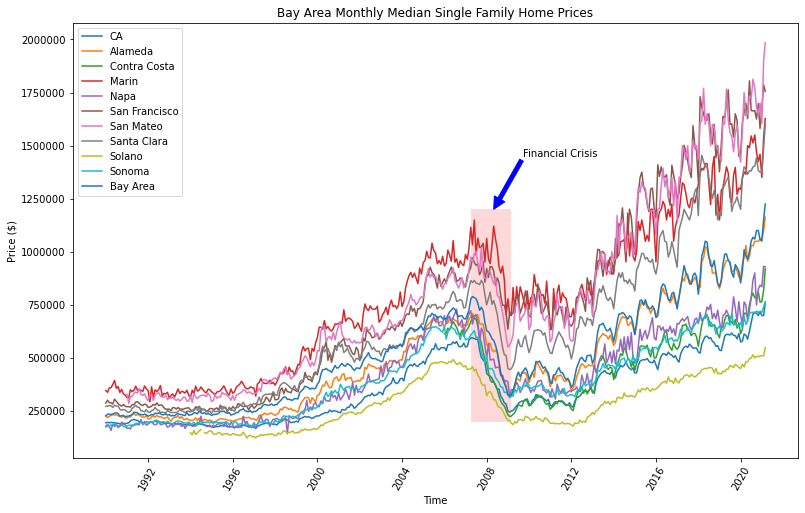

In [8]:
# Initial Plot 

fig, ax = plt.subplots(figsize=(13, 8))
#plt.plot(df['Time'], df.loc[:, df.columns != 'Time'])
plt.plot(df.loc[:])
plt.title('Bay Area Monthly Median Single Family Home Prices') 
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend(df.columns[:])
plt.ticklabel_format(style='plain', axis='y') #To change the numbers from scientific to integer numbers in chart
ax.fill_between([13600,14300], 200000, 1200000, facecolor='red', alpha = .15, interpolate=True)
ax.annotate(text='Financial Crisis', xy=(14000,1200000), xytext=(14500,1450000), arrowprops={'color':'blue','lw':1.01})
plt.show()

Since the house price moves differently before and after the financial crisis, the first step should be dividing the whole data set into before and after the financial crisis. 

In [9]:
# Separating the whole dateset into 2 groups (before and after the financial crisis)

cut_year_1 = 2007
cut_year_2 = 2009

df_bfr_crisis = df[df.index.year < cut_year_1 ].dropna(how='all')
df_aft_crisis = df[df.index.year >= cut_year_2 ].dropna(how='all')

<br>

<font color=blue  size=20> 1 - Average Bay Area </font>

<br>

<br>

**Let's do next steps just on the Bay Area column**.


<br>

In [10]:
# Split Bay Area Dataset 

df_bfr_crisis_bay = df_bfr_crisis[['Bay Area']]
df_aft_crisis_bay = df_aft_crisis[['Bay Area']]

<br>

### 1.C. Making The Dataset Stationary: 

<font size="4">
Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation, etc.). If the mean of a time-series increases over time, then it’s not stationary.
We define time series as stationary if a shift in time doesn’t cause a change in the shape of the distribution. The basic of distribution we are talking about is mean, variance and covariance.
</font>

Each timeseries dataset contains trend, seasonality, cyclic, and noise. 
Two general trend classes are:

- Deterministic Trends: These are trends that consistently increase or decrease.
- Stochastic Trends: These are trends that increase and decrease inconsistently.

There are 3 ways to do stationary check on time series dataset: 

1. **Plotting rolling means and variances** is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not to be stationary.


2. **Plotting Decompose Dataset** can help us figure out the trend, seasonality and residual of a time series.


3. **Do Dicky - Fuller Test** the more accurate method to check whether the time series is stationary or not is using **Dickey – Fuller** test. 

<br>

**1. Plotting rolling statistics**

Plotting rolling means and variances is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not to be stationary.

In [11]:
def plot_rolling(df):
    
    plt.style.use('Solarize_Light2')
    fig, ax = plt.subplots(3,figsize=(9, 6))
    
    ax[0].plot(df.index, df, label='Actual Data')
    ax[0].legend()
    
    ax[1].plot(df.rolling(window=12).mean(), label="rolling mean");
    ax[1].legend()
    
    ax[2].plot(df.rolling(window=12).std(), label="rolling std");
    ax[2].legend()
    
    plt.tight_layout()
    fig.autofmt_xdate()

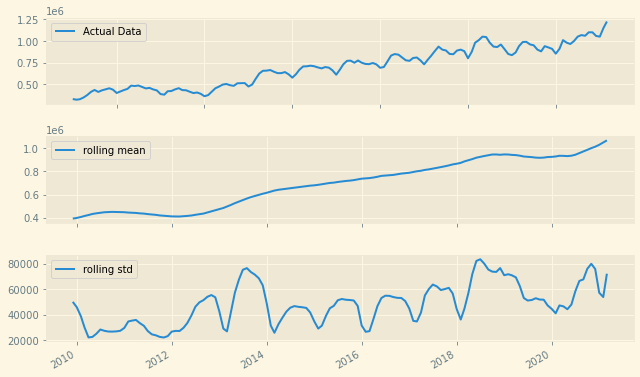

In [12]:
# Plot Rolling mean and variance

plot_rolling(df_aft_crisis_bay)

Rolling mean and rolling standard deviation tell us that the original dataset is non stationary.

<br>

**2. Plotting Decompose Dataset**

In [13]:
# Decopmose the time series dataset 

def decomp_plot(df):
    
    res_decompose = seasonal_decompose(df, model='additive') #How to chose between additive or multipicative models?
    
    plt.style.use('Solarize_Light2')
    fig, ax = plt.subplots(4,figsize=(9, 6))
    
    ax[0].plot(df.index, df, label='Actual Data');
    ax[0].ticklabel_format(style='plain', axis='y');
    ax[0].legend()
    
    ax[1].plot(res_decompose.trend , label="Trend");
    ax[1].legend()
    
    ax[2].plot(res_decompose.seasonal , label="Seasonal");
    ax[2].legend()
    
    ax[3].plot(res_decompose.resid , label="Residual");
    ax[3].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

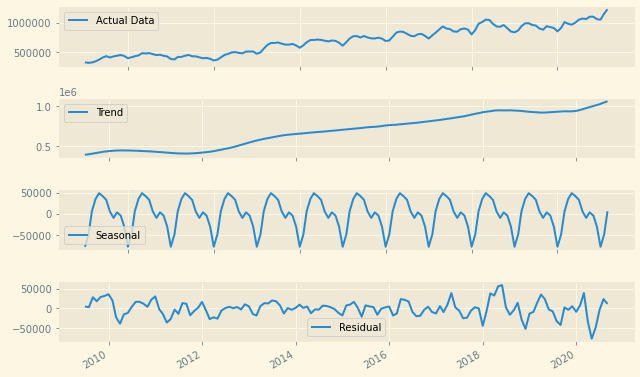

In [14]:
# Plot decompose charts

decomp_plot(df_aft_crisis_bay)

Decompose output tells us that the original dataset has trend, seasonality and some noises.

**3. Dicky - Fuller test**

Let's check the stationry using the Dickey-Fuller test as well. 

In [15]:
# Let's first just check how the Adfuller test output looks like:

adfuller(df_aft_crisis_bay)

(0.654924755528907,
 0.9888940244471189,
 13,
 133,
 {'1%': -3.480500383888377,
  '5%': -2.8835279559405045,
  '10%': -2.578495716547007},
 3045.6265127255538)

In [16]:
# Function for better printing Adfuller Test result

def adfuller_test(df):
    
    print("\n > Is the data stationary ?\n")
    dftest = adfuller(df, autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("#Lag used = {}".format(dftest[2]))
    print("Number of observations = {}".format(dftest[3]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {:.3f} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [17]:
adfuller_test(df_aft_crisis_bay)


 > Is the data stationary ?

Test statistic = 0.655
P-value = 0.989
#Lag used = 13
Number of observations = 133
Critical values :
	1%: -3.481 - The data is not stationary with 99% confidence
	5%: -2.884 - The data is not stationary with 95% confidence
	10%: -2.578 - The data is not stationary with 90% confidence


<br>

<br>

All above tests (Plotting Rolling Mean and Std - Plotting Decmpose Charts - Doing Adfuller Test)
tell us that this time series dataset is non stationary. And since ARIMA works on stationary dataset, we need to make this dataset stationary. 

<br> 

<br>

There are four commonly used technique to make a time series stationary:


<br>

1.  **Detrending** : Here, we simply remove the trend component from the time series. For instance, the equation of my time series is:

x(t) = (mean + trend * t) + error

We’ll simply remove the part in the parentheses and build model for the rest.


<br>



<br>

2. **Differencing** : This is the commonly used technique to remove non-stationarity. Here we try to model the differences of the terms and not the actual term. For instance,

x(t) – x(t-1) = ARMA (p ,  q)

This differencing is called as the Integration('I') part in AR(I)MA. Now, we have three parameters

p : AR

d : I

q : MA



<br>

<br>

3. **Logging** : in the case where the compound rate in the trend is not due to a price index (ie the series is not measured in a currency), logging can help linearize a series with an exponential trend (recall that log(exp(x)) = x). It does not remove an eventual trend whatsoever, unlike deflation.

<br>

<br> 

4. **Seasonality** : Seasonality can easily be incorporated in the ARIMA model directly. More on this has been discussed in the applications part below.

## 1.D. Determine d Value

<br>

First, I am writing the function to check the stationary of the time series at each step. This function is combination of Adfuller test and Visualization of rolling mean and variance method. 

In [18]:
def check_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('{}'.format(timeseries.columns[0]), fontdict={'fontsize':11})
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries.dropna() , autolag='AIC')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

#### 1. Logging

Based on the charts, one good way for stationarizing the dataset could be Logging. 
I'll check the result later to check whether the logging could help us or not.

In [19]:
# Create Bay Area Logarithmic Column
df_aft_crisis_bay['Bay Area (Log)'] = df_aft_crisis_bay['Bay Area'].apply(lambda x : np.log(x))

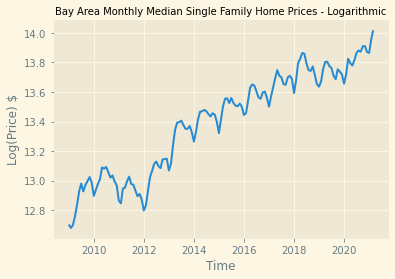

In [20]:
# Plot Log(Df) Dataset

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_aft_crisis_bay['Bay Area (Log)'])
plt.title('Bay Area Monthly Median Single Family Home Prices - Logarithmic', fontdict={'fontsize':10}) 
plt.ylabel('Log(Price) $')
plt.xlabel('Time')
plt.show()

#### 2. Deterending by Differencing

Next step is doing differencing, the differencing can be used as 'I' in ARIMA model later. This is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step. 

The order of differencing is the number of times that this process is done over the timeseries. 

##### Differencing lag 1 order 1 : 

In [21]:
# Differencing order 1

df_aft_crisis_bay['Diff Lag 1 Ord 1'] = np.NaN
df_aft_crisis_bay['Diff Lag 1 Ord 1'].iloc[1:] = np.diff(df_aft_crisis_bay['Bay Area (Log)'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_bay[['Diff Lag 1 Ord 1']])

ADF Statistic: -2.6161754067043126
p-value: 0.08970001084157853
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


The first order does not do enough for making the dataset station. Let's check the second order: 

##### Differencing lag 1 order 2 : 

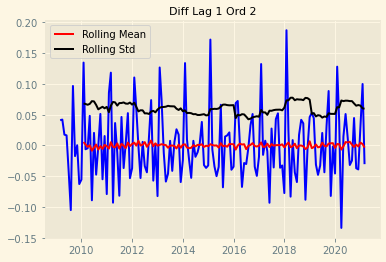

ADF Statistic: -4.480466632777321
p-value: 0.00021325364098412718
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


In [22]:
# Differencing order 2

df_aft_crisis_bay['Diff Lag 1 Ord 2'] = np.NaN
df_aft_crisis_bay['Diff Lag 1 Ord 2'].iloc[1:] = np.diff(df_aft_crisis_bay['Diff Lag 1 Ord 1'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_bay[['Diff Lag 1 Ord 2']])


Order 2 differencing make the dataset stationary. So the plots show that this two order differenced logarithmic is stationary.


##### Differencing lag 12 months order 1 : 

In [23]:
# Difference Function

def diff(df_col , interval=1):
    
    '''calculate the difference of entries from the same column based on specific interval'''
    
    diff = list()
    #df_series = df.values
    for i in range(interval , len(df_col)): 
        value = df_col[i] - df_col[ i - interval]
        diff.append(value)
    
    #df_diff_one = pd.DataFrame(diff, index = df.index[interval:], columns=['De Trended'] )

    return (diff)

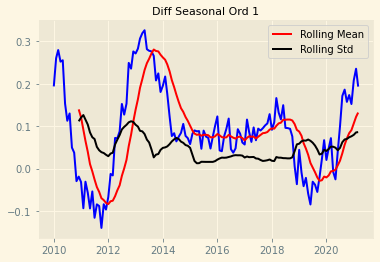

ADF Statistic: -4.548885955301514
p-value: 0.0001602885074063749
Critical Values:
	1%: -3.485585145896754
	5%: -2.885738566292665
	10%: -2.5796759080663887


In [24]:
# Differencing Seasonal order 1 

df_aft_crisis_bay['Diff Seasonal Ord 1'] = np.NaN
df_aft_crisis_bay['Diff Seasonal Ord 1'].iloc[12:] = diff(df_aft_crisis_bay['Bay Area (Log)'],interval =12)

# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_bay[['Diff Seasonal Ord 1']])

<br>

Based on the ADF test and rolling mean and standard deviation charts, I am going to use the 
***12-month differenced 1st order of the logged data*** from this point as my major dataframe and at the end invert it back to the original one. 

## 1.E. Create ACF and PACF plots

Next step is to find the right parameters for *p* and *q* to be used in the ARIMA model. We already know that the ‘d’ component is 1 as we need 1 difference to make the series stationary. We do this using the Correlation plots. Following are the ACF plots for the series :

#### Autocorrelation plots (ACF & PACF)

An **autocorrelation (ACF)** plot represents the autocorrelation of the series with lags of itself. 

A **partial autocorrelation (PACF)** plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.

Ideally, we want no correlation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

In terms of ARIMA model:
   - ACF chart shows us the *q* or the *MA* part. 
   - PACF chart shows us the *p* or the *AR* part. 

<br>

First, we need to plot autocorrelation chart on logarithmic values. 

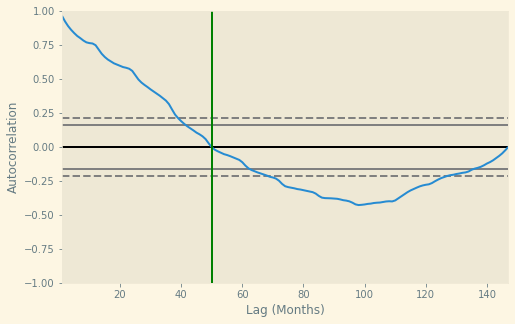

In [25]:
# Seasonality or Noise ?

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_bay['Bay Area (Log)'])
plt.axvline(50, color='green')
plt.xlabel('Lag (Months)')
plt.show()

**Noise** --> The autocorrelation drops to zero at around 50 Months. 

We have discovered that if we want to predict future single family home values, 
we should only consider "noise" up until 50 months prior. 

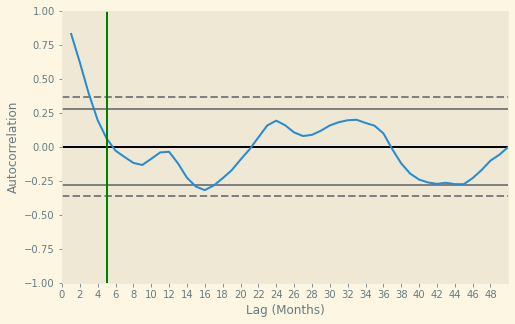

In [26]:
# Noise 

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_bay['Bay Area (Log)'][:50])
plt.xlabel('Lag (Months)')
plt.xticks(np.arange(0, 50, step=2))
plt.axvline(5, color='green')
plt.show()

In [27]:
def acf_pacf_plot (df):
    
    
    fig, ax = plt.subplots(2, figsize=(12,6))
    
    ax[0].set_xticks(np.arange(0,36,step=6))
    ax[1].set_xticks(np.arange(0,36,step=6))
    
    ax[0] = plot_acf(df.dropna(), ax=ax[0] , lags = 30) #lags were 20 initially 
    ax[1] = plot_pacf(df.dropna(), ax= ax[1] , lags = 30)

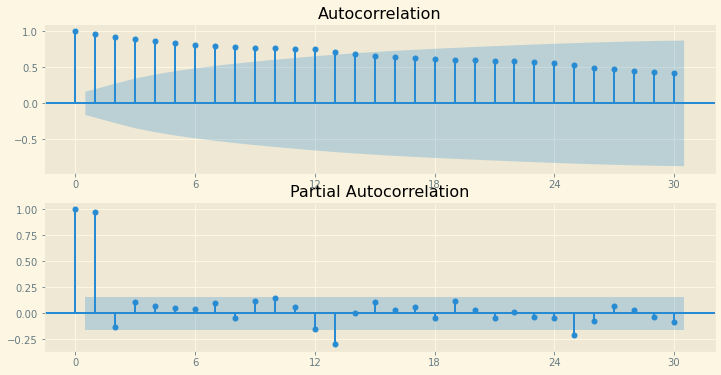

In [28]:
acf_pacf_plot(df_aft_crisis_bay['Bay Area (Log)'])

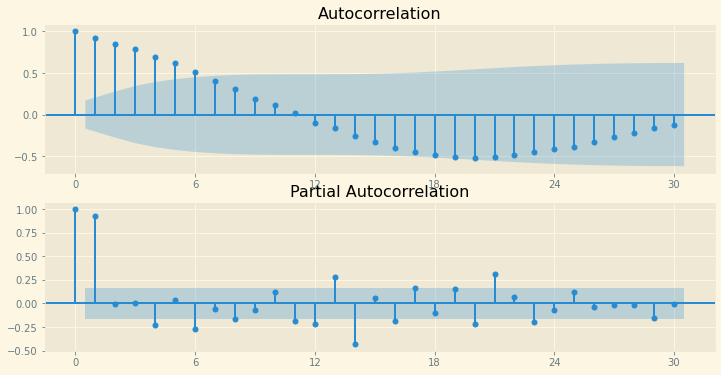

In [29]:
acf_pacf_plot(df_aft_crisis_bay['Diff Seasonal Ord 1'])

<br>

Keep in mind that we basically want to fit the model on the **Differenced Seasonal Order 1** Column. Then based on the prediction, the predicted values should be ineverted based on the differenced time (in this case 12 months)

Based on ACF and PACF figures, the possible appropriate values for p and q: 

    p : 1 , 4 , 6 
    
    q : 6 , 11 , 12
    
The best combination of parameters can be achived through grid search step. 

keep in mind that I do differencing (I part in ARIMA), manually in my model, therfore in ARIMA class I am going to use 0 as *I*. 

<br>

<br>

For modeling we need to split the dataset into train and valid dataset:

- Before Crisis (17 years: 1990-2006):  3 years as validation part
- After Crisis (12 years and 3 Months : 2009- March 2021):  3 and 3 Months years as validation part

In [30]:
# Split the dataset into train and valid datasets 

df_aft_crisis_bay_train = df_aft_crisis_bay[df_aft_crisis_bay.index.year < 2018].dropna(how='all')
df_aft_crisis_bay_valid = df_aft_crisis_bay[df_aft_crisis_bay.index.year >= 2018].dropna(how='all')

In [31]:
# Get the shape of training and valdation dataset 
print('df train after crisis Shape', df_aft_crisis_bay_train.shape)
print('df valid after crisis Shape', df_aft_crisis_bay_valid.shape)

df train after crisis Shape (108, 5)
df valid after crisis Shape (39, 5)


Let’s create a function to invert differenced value

As we are modeling on a differenced dataset, we have to bring back the predicted values at the original scale by adding the same month value from the previous year.

In [32]:
# Invert Function - For Differenced Seasonal Ord 1

def inverse_difference(history, yhat, interval=1):
    
    return yhat + history[-interval]

In [33]:
# Fitting a model with random Arima order and get the initial sense of performance measure (RMSE)

history_bay = [x for x in df_aft_crisis_bay_train['Bay Area (Log)']]
predictions = list()

for i in range(len(df_aft_crisis_bay_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_bay, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(4,0,12))
    model_fit_ARIMA = model.fit()
    yhat = model_fit_ARIMA.forecast()[0]
    yhat = inverse_difference(history_bay, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_bay_valid['Bay Area (Log)'].iloc[i]
    history_bay.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_bay_valid['Bay Area (Log)'], predictions))
print('RMSE: %.4f' % rmse)

RMSE: 0.0360


In [34]:
# Predictions and Error Columns

df_aft_crisis_bay_valid['Prediction (Log)'] = predictions 
df_aft_crisis_bay_valid['Prediction ARIMA'] = df_aft_crisis_bay_valid['Prediction (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_bay_valid['Error ARIMA'] = round(((df_aft_crisis_bay_valid['Prediction ARIMA'] - df_aft_crisis_bay_valid['Bay Area'])/df_aft_crisis_bay_valid['Bay Area']),3)

In [35]:
df_aft_crisis_bay_valid.head(3)

Bay Area  Bay Area (Log)  Diff Lag 1 Ord 1  Diff Lag 1 Ord 2  \
Time                                                                       
2018-01-01    800000       13.592367         -0.097580         -0.077378   
2018-02-01    875000       13.681979          0.089612          0.187192   
2018-03-01    980000       13.795308          0.113329          0.023717   

            Diff Seasonal Ord 1  Prediction (Log)  Prediction ARIMA  \
Time                                                                  
2018-01-01             0.091293         13.616973            819928   
2018-02-01             0.109216         13.650061            847512   
2018-03-01             0.166127         13.773364            958728   

            Error ARIMA  
Time                     
2018-01-01        0.025  
2018-02-01       -0.031  
2018-03-01       -0.022

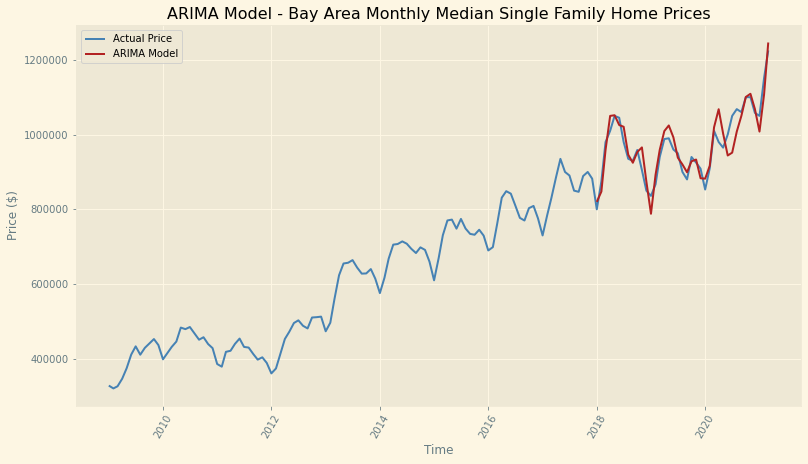

In [36]:
# Plot the Bay Area Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_bay['Bay Area'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_bay_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.title('ARIMA Model - Bay Area Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

#### Residual Analysis

In [37]:
residuals_ARIMA = [df_aft_crisis_bay_valid['Bay Area'].iloc[i]-df_aft_crisis_bay_valid['Prediction ARIMA'].iloc[i] for i in range(len(df_aft_crisis_bay_valid))]
residuals_ARIMA = pd.DataFrame(residuals_ARIMA)
print (residuals_ARIMA.describe([.05,.1,.25,.5,.75,.9,0.95]))
print (df_aft_crisis_bay_valid[['Error ARIMA']].describe([.05,.1,.25,.5,.75,.9,0.95]))


                  0
count     39.000000
mean   -2687.435897
std    35581.505996
min   -87766.000000
5%    -42777.100000
10%   -38114.600000
25%   -22876.500000
50%    -9058.000000
75%    15670.000000
90%    44533.000000
95%    56361.800000
max    98373.000000
       Error ARIMA
count     39.00000
mean       0.00359
std        0.03627
min       -0.09400
5%        -0.05610
10%       -0.04320
25%       -0.01550
50%        0.00900
75%        0.02700
90%        0.03920
95%        0.04450
max        0.09000


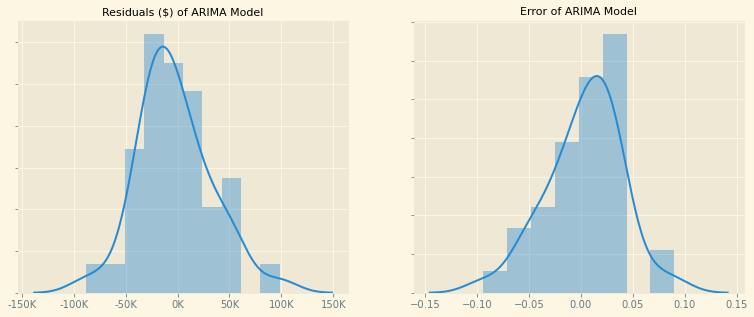

In [38]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA, ax=axes[0], bins=10, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_bay_valid['Error ARIMA'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

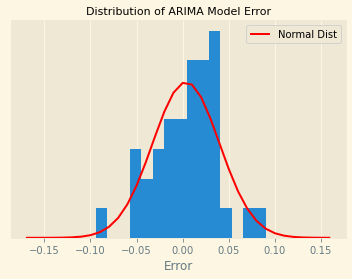

In [39]:
# 
x = np.arange(-0.17,0.17,0.01)

df_aft_crisis_bay_valid['Error ARIMA'].hist(bins=15, density=True)
plt.plot(x , sp.stats.norm(loc = df_aft_crisis_bay_valid['Error ARIMA'].mean(), 
                           scale = df_aft_crisis_bay_valid['Error ARIMA'].std()).pdf(x),
                         linewidth=2 , color='red', label = 'Normal Dist')
plt.yticks([])
plt.xlabel('Error')
plt.title('Distribution of ARIMA Model Error', fontdict={'fontsize':11})
plt.legend()
plt.show()

We can see, there is a very small bias in the model. Ideally, the mean should have been zero. 

<br>

**Caution!**
This bias is calculated from the final price, since my model is predicting the log price in order to modify my model it would be easier to calculate the *Residuals of Log Prediction* and put it as the bias in the model

In [40]:
residuals_ARIMA_log = [df_aft_crisis_bay_valid['Bay Area (Log)'].iloc[i]-df_aft_crisis_bay_valid['Prediction (Log)'].iloc[i] for i in range(len(df_aft_crisis_bay_valid))]
residuals_ARIMA_log = pd.DataFrame(residuals_ARIMA_log)
print(residuals_ARIMA_log.describe())

               0
count  39.000000
mean   -0.002865
std     0.036369
min    -0.085772
25%    -0.026478
50%    -0.008810
75%     0.015689
max     0.098372


Ideally, the mean should have been zero. We will use this mean value ( -0.002865) to correct the bias in our prediction by adding this value to each forecast.

#### Bias Corrected Model

In [41]:
history_bay = [x for x in df_aft_crisis_bay_train['Bay Area (Log)']]
predictions = list()
bias = -0.002865

for i in range(len(df_aft_crisis_bay_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_bay, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(4,0,12))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history_bay, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_bay_valid['Bay Area (Log)'].iloc[i]
    history_bay.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_bay_valid['Bay Area (Log)'], predictions))
print('RMSE: %.4f' % rmse)



RMSE: 0.0359


In [42]:
# Predictions and Error Columns

df_aft_crisis_bay_valid['Prediction2 (Log)'] = predictions 
df_aft_crisis_bay_valid['Prediction ARIMA2'] = df_aft_crisis_bay_valid['Prediction2 (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_bay_valid['Error ARIMA2'] = round(((df_aft_crisis_bay_valid['Prediction ARIMA2'] - df_aft_crisis_bay_valid['Bay Area'])/df_aft_crisis_bay_valid['Bay Area']),3)

In [43]:
# errors
residuals_ARIMA2 = [df_aft_crisis_bay_valid['Bay Area'].iloc[i]-df_aft_crisis_bay_valid['Prediction ARIMA2'].iloc[i] for i in range(len(df_aft_crisis_bay_valid))]
residuals_ARIMA2 = pd.DataFrame(residuals_ARIMA2)
print(residuals_ARIMA2.describe([0.05,0.1,0.25,0.5,0.75,0.90,0.95]))

                   0
count      39.000000
mean      106.589744
std     35539.429017
min    -84711.000000
5%     -39872.800000
10%    -35218.600000
25%    -20181.500000
50%     -5885.000000
75%     18479.000000
90%     47519.200000
95%     59080.100000
max    101095.000000


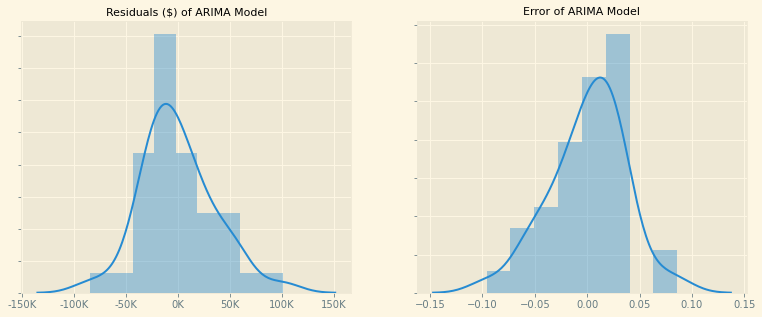

In [44]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA2, ax=axes[0], bins=None, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_bay_valid['Error ARIMA2'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

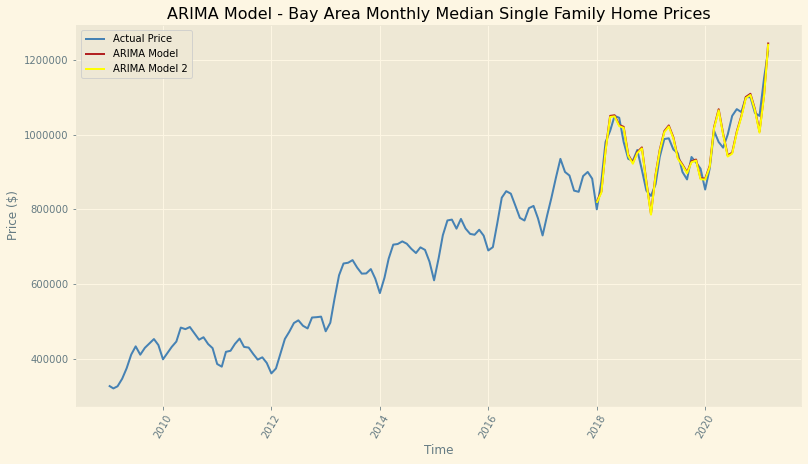

In [45]:
# # Plot the Bay Area Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_bay['Bay Area'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_bay_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_bay_valid['Prediction ARIMA2'], color = 'yellow', label = 'ARIMA Model 2')
plt.title('ARIMA Model - Bay Area Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

####  Check autocorrelation in the residuals
As a final check, we should investigate if there any autocorrelation exists in the residual. If exists, it means there is an opportunity for improvement in the model. Ideally, there should not be any autocorrelation left in the residuals if the model is fitted well.

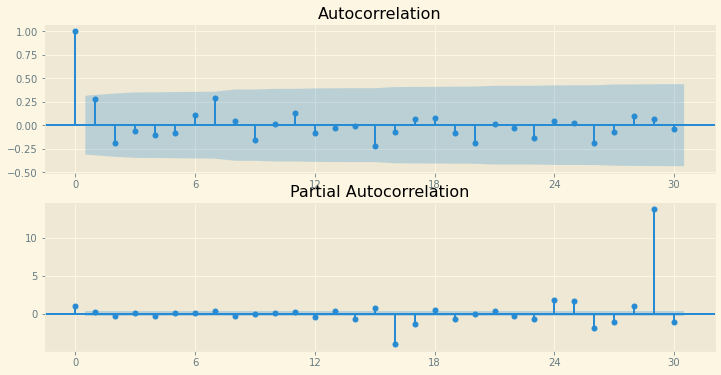

In [46]:
acf_pacf_plot(residuals_ARIMA2)

# can be deleted

There is not much difference between the original and bias-corrected models, so I decided to stick with the original model. Next, I am running the grid search technique to find the best ARIMA model parameters.
For the other nine sections (counties), I will skip the bias-corrected part since I do not want to overfit my model, and also since I do not know the source of the biases, I thought maybe it's still better to leave them there for future research.

## 1.F. Hypertuning for ARIMA 
### Grid Search For ARIMA parameters

So far, I preprocessed the data, made the time series stationary, found some possible best values for d, p, and q using differencing methods, ACF, and PACF plots, fit the inital ARIMA model on dataset and calculate the validation performance (root squared mean error). For finding the best ARIMA parameters is better to use *Grid Search* technique. 
I am going to functionalize all previous steps and grid search step. 

In [47]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_model_ARIMA(arima_order):
    
    
    history_bay = [x for x in df_aft_crisis_bay_train['Bay Area (Log)']]
    predictions = list()

    for i in range(len(df_aft_crisis_bay_valid)):
    
        #difference data
            months_in_year = 12
            diff_df = diff(history_bay, months_in_year)
    
        # predict
            model = ARIMA(diff_df, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            yhat = inverse_difference(history_bay, yhat, months_in_year)
            predictions.append(yhat)
    
        # observation
            obs = df_aft_crisis_bay_valid['Bay Area (Log)'].iloc[i]
            history_bay.append(obs)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(df_aft_crisis_bay_valid['Bay Area (Log)'], predictions))
    return rmse

In [48]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(evaluate_model_function = evaluate_model_ARIMA ,p=range(0,4), d=range(0,2), q=range(0,4)):
    '''This functions get the range of p, q, and d
    then fit the ARIMA model and find the best combination of parameters based on RMSE'''
    
    pdq = list(itertools.product(p,d,q))
    
    best_score, best_param = float("inf"), None
    print('Models Parameters and Performance: Loading.....')
    for param in pdq:
        try:
            rmse = evaluate_model_function(param)
            if rmse < best_score:
                best_score, best_param = rmse, param
                print('ARIMA%s RMSE=%.4f' % (param,rmse))
        except:
            continue
        
    print('Best: ARIMA%s RMSE=%.4f' % (best_param, best_score)) 
    return best_param

In [49]:
# Grid Search for ARIMA model
p_values = range(3, 5)
d_values = range(0, 1)
q_values = range(12, 13)
warnings.filterwarnings("ignore")
i_test = evaluate_models(evaluate_model_ARIMA ,p_values, d_values, q_values) 

Models Parameters and Performance: Loading.....
ARIMA(3, 0, 12) RMSE=0.0372
ARIMA(4, 0, 12) RMSE=0.0360
Best: ARIMA(4, 0, 12) RMSE=0.0360


## 1.G. Future Prediction

<br>

Now let's predict the price for the next few months

<br>

First we need to add several months index to the end of our validation dataset

In [50]:
def future_data_needed (df, pred_months=12):
    
    '''This function concat future date index to the 
    part of the past data - validation set '''
   
    future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,pred_months+1)]
    future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)
    future_df = pd.concat([df,future_dates_df])
    return (future_df)

In [51]:
# Add 12 months to the end of the df_aft_crisis_bay_valid
df_future = future_data_needed(df_aft_crisis_bay_valid, pred_months=12)

In [52]:
def future_pred_ARIMA (df_valid_f, df_train, pred_col = 'Bay Area (Log)',ARIMA_order=(4,0,12), pred_months=12):
    
    '''This function gets the train and (valid+future) datasets , target column, ARIMA parameters 
    and prediction period and output the dataset with prediction and target column '''
    
    history = [x for x in df_train[pred_col]]
    pred = list()
    
    for i in range(len(df_valid_f)):
        
        months_in_year = 12
        diff_df = diff(history, months_in_year)
        
        model = ARIMA(diff_df, order=ARIMA_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        pred.append(yhat)
        
        if math.isnan(df_valid_f[pred_col].iloc[i]):
            obs = yhat
            history.append(obs)
            
        else : 
            obs = df_valid_f[pred_col].iloc[i]
            history.append(obs)
            
            
    # Add Predictions columns 
    df_valid_f['Prediction (Log)'].iloc[-pred_months:] = pred[-pred_months:]
    df_valid_f['Prediction ARIMA'].iloc[-pred_months:] = df_valid_f['Prediction (Log)'].iloc[-pred_months:].apply(lambda x : int(np.exp(x)))


    return (df_valid_f)

In [53]:
# Make the dataset of next 12 months predictions
df_aft_crisis_bay_pred = future_pred_ARIMA(df_future, df_aft_crisis_bay_train, pred_col = 'Bay Area (Log)', pred_months=12)

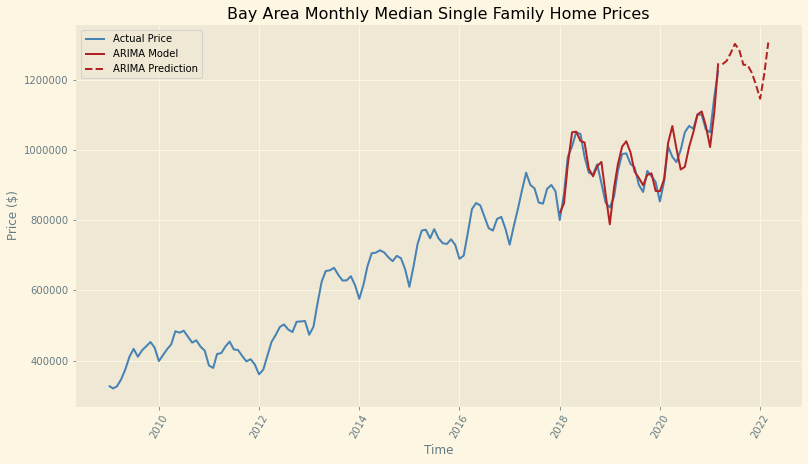

In [54]:
# Plot the Bay Area Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_bay['Bay Area'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_bay_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_bay_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction')
plt.title('Bay Area Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [55]:
# margin of error on predictions error

error_list = df_aft_crisis_bay_pred['Error ARIMA'].dropna()

In [56]:
error_list.describe([0.025,0.05,0.1,0.5,0.95,0.975])

count    39.00000
mean      0.00359
std       0.03627
min      -0.09400
2.5%     -0.05885
5%       -0.05610
10%      -0.04320
50%       0.00900
95%       0.04450
97.5%     0.06815
max       0.09000
Name: Error ARIMA, dtype: float64

In [57]:

print ('mean of error:', np.mean(error_list))
print ('std deviation of error:', np.std(error_list))
print ('std dev of sample:',statistics.stdev(error_list))
############# 
critical_value = 1.96
std = statistics.stdev(error_list)
sample = len(error_list)
MOE = critical_value * (std / np.sqrt(sample))
print ('margin of error:', MOE)
print ('lower:', np.mean(error_list)-MOE)
print ('highr:', np.mean(error_list)+MOE)
high_bond_rate = 1 + np.mean(error_list)+MOE
low_bond_rate = 1 + np.mean(error_list)-MOE

mean of error: 0.003589743589743589
std deviation of error: 0.03580196094666549
std dev of sample: 0.03626998030031386
margin of error: 0.011383376168710829
lower: -0.0077936325789672405
highr: 0.014973119758454417


In [58]:
# higher and lower rate comes from error distribution for 2.5% , 97.5% (95% confidence interval)
df_aft_crisis_bay_pred['lower_bond'] = (df_aft_crisis_bay_pred['Prediction ARIMA']* (1-0.05885)).astype(int)
df_aft_crisis_bay_pred['higher_bond'] = (df_aft_crisis_bay_pred['Prediction ARIMA'] * (1.06815)).astype(int)


In [59]:
df_aft_crisis_bay_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2018-01-01 to 2022-03-01
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bay Area             39 non-null     object 
 1   Bay Area (Log)       39 non-null     float64
 2   Diff Lag 1 Ord 1     39 non-null     float64
 3   Diff Lag 1 Ord 2     39 non-null     float64
 4   Diff Seasonal Ord 1  39 non-null     float64
 5   Prediction (Log)     51 non-null     float64
 6   Prediction ARIMA     51 non-null     object 
 7   Error ARIMA          39 non-null     float64
 8   Prediction2 (Log)    39 non-null     float64
 9   Prediction ARIMA2    39 non-null     object 
 10  Error ARIMA2         39 non-null     float64
 11  lower_bond           51 non-null     int64  
 12  higher_bond          51 non-null     int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 5.6+ KB


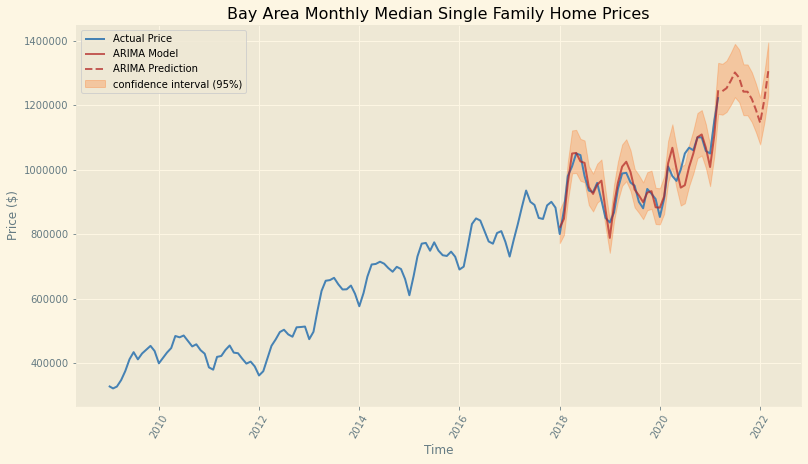

In [60]:
# Plot the Bay Area Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_bay['Bay Area'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_bay_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model', alpha=0.7)
plt.plot( df_aft_crisis_bay_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction', alpha=0.7)
ax.fill_between(df_aft_crisis_bay_pred.index, df_aft_crisis_bay_pred['lower_bond'], df_aft_crisis_bay_pred['higher_bond'], color='#ff7823', alpha=0.3, label="confidence interval (95%)");
plt.title('Bay Area Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

#### For having the interactive charst, I am utlizing the Altair package. The charts and their preprocessing steps are all come in the two other notebooks, namely website_chart_a and website_chart_b notebooks.

<br>

<font color=blue  size=20> 2 - Alameda </font>

<br>

In [61]:
# Split Alameda Dataset 

df_aft_crisis_alm = df_aft_crisis[['Alameda']]

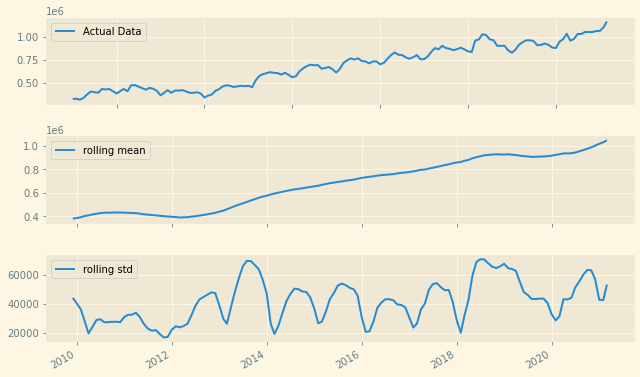

In [62]:
# Plot Rolling mean and variance

plot_rolling(df_aft_crisis_alm)

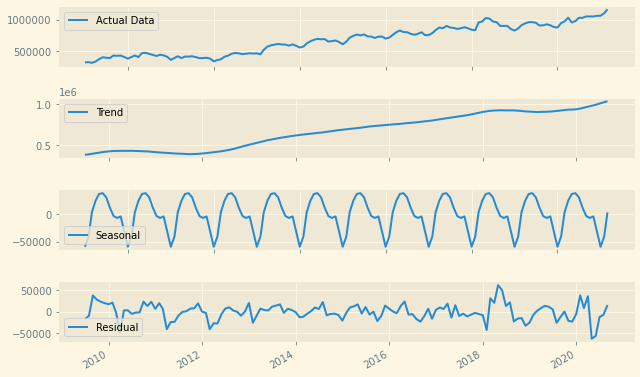

In [63]:
# Plot decompose charts

decomp_plot(df_aft_crisis_alm)

In [64]:
adfuller_test(df_aft_crisis_alm)


 > Is the data stationary ?

Test statistic = 0.498
P-value = 0.985
#Lag used = 13
Number of observations = 133
Critical values :
	1%: -3.481 - The data is not stationary with 99% confidence
	5%: -2.884 - The data is not stationary with 95% confidence
	10%: -2.578 - The data is not stationary with 90% confidence


In [65]:
# Create Bay Area Logarithmic Column
df_aft_crisis_alm['Alameda (Log)'] = df_aft_crisis_alm['Alameda'].apply(lambda x : np.log(x))

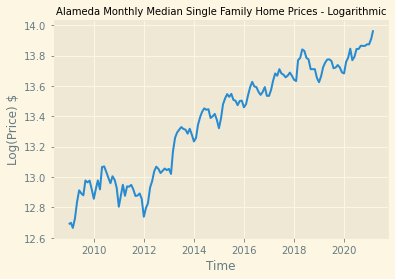

In [66]:
# Plot Log(Df) Dataset

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_aft_crisis_alm['Alameda (Log)'])
plt.title('Alameda Monthly Median Single Family Home Prices - Logarithmic', fontdict={'fontsize':10}) 
plt.ylabel('Log(Price) $')
plt.xlabel('Time')
plt.show()

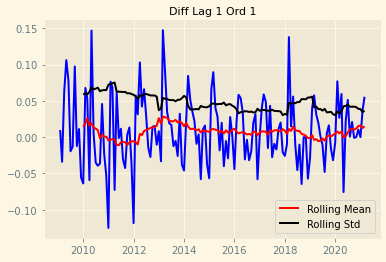

ADF Statistic: -2.277072817610587
p-value: 0.17946908740109696
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


In [67]:
# Differencing order 1

df_aft_crisis_alm['Diff Lag 1 Ord 1'] = np.NaN
df_aft_crisis_alm['Diff Lag 1 Ord 1'].iloc[1:] = np.diff(df_aft_crisis_alm['Alameda (Log)'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_alm[['Diff Lag 1 Ord 1']])

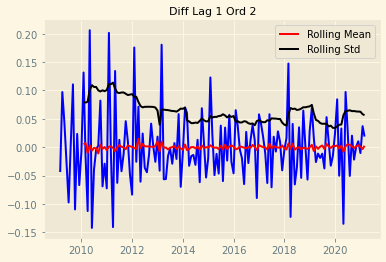

ADF Statistic: -3.915372602643208
p-value: 0.0019245813022450726
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [68]:
# Differencing order 2

df_aft_crisis_alm['Diff Lag 1 Ord 2'] = np.NaN
df_aft_crisis_alm['Diff Lag 1 Ord 2'].iloc[1:] = np.diff(df_aft_crisis_alm['Diff Lag 1 Ord 1'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_alm[['Diff Lag 1 Ord 2']])

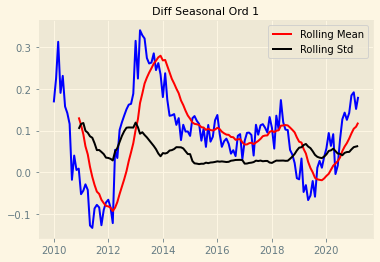

ADF Statistic: -4.721831912463109
p-value: 7.655503075781582e-05
Critical Values:
	1%: -3.4846672514209773
	5%: -2.8853397507076006
	10%: -2.5794629869786503


In [69]:
# Differencing Seasonal order 1 

df_aft_crisis_alm['Diff Seasonal Ord 1'] = np.NaN
df_aft_crisis_alm['Diff Seasonal Ord 1'].iloc[12:] = diff(df_aft_crisis_alm['Alameda (Log)'],interval =12)

# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_alm[['Diff Seasonal Ord 1']])

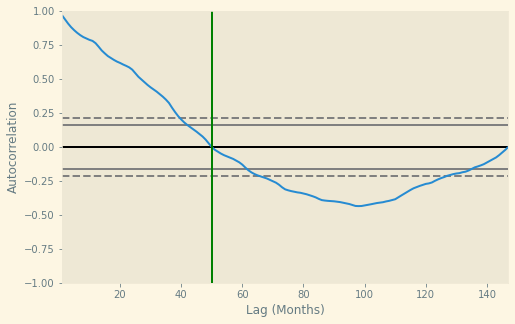

In [70]:
# Seasonality or Noise ?

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_alm['Alameda (Log)'])
plt.axvline(50, color='green')
plt.xlabel('Lag (Months)')
plt.show()

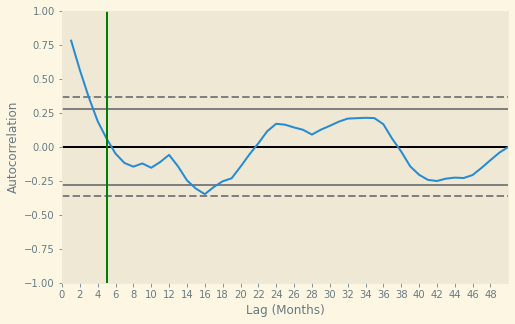

In [71]:
# Noise 

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_alm['Alameda (Log)'][:50])
plt.xlabel('Lag (Months)')
plt.xticks(np.arange(0, 50, step=2))
plt.axvline(5, color='green')
plt.show()

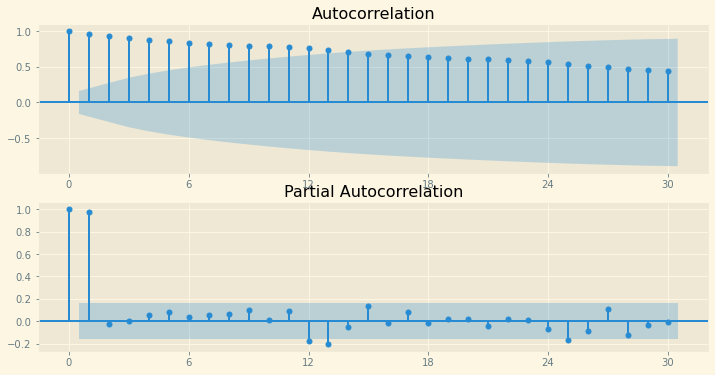

In [72]:
acf_pacf_plot(df_aft_crisis_alm['Alameda (Log)'])

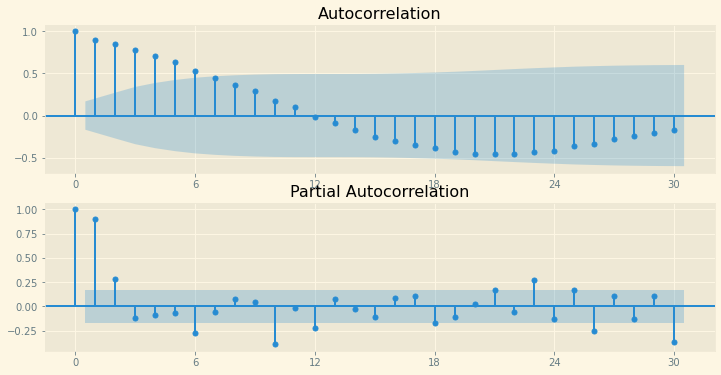

In [73]:
acf_pacf_plot(df_aft_crisis_alm['Diff Seasonal Ord 1'])

Based on ACF and PACF figures, the possible appropriate values for p and q: 

    p : 1 , 2 , 6 
    
    q : 6 , 11 , 12
    
The best combination of parameters can be achived through grid search step. 

keep in mind that I do differencing (I part in ARIMA), manually in my model, therfore in ARIMA class I am going to use 0 as *I*. 

In [74]:
# Split the dataset into train and valid datasets 

df_aft_crisis_alm_train = df_aft_crisis_alm[df_aft_crisis_alm.index.year < 2018].dropna(how='all')
df_aft_crisis_alm_valid = df_aft_crisis_alm[df_aft_crisis_alm.index.year >= 2018].dropna(how='all')

In [75]:
# Get the shape of training and valdation dataset 
print('df train after crisis Shape', df_aft_crisis_alm_train.shape)
print('df valid after crisis Shape', df_aft_crisis_alm_valid.shape)

df train after crisis Shape (108, 5)
df valid after crisis Shape (39, 5)


Let's find the best ARIMA parameters using grid search.

In [76]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_model_ARIMA(arima_order):
    
    
    history_alm = [x for x in df_aft_crisis_alm_train['Alameda (Log)']]
    predictions = list()

    for i in range(len(df_aft_crisis_alm_valid)):
    
        #difference data
            months_in_year = 12
            diff_df = diff(history_alm, months_in_year)
    
        # predict
            model = ARIMA(diff_df, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            yhat = inverse_difference(history_alm, yhat, months_in_year)
            predictions.append(yhat)
    
        # observation
            obs = df_aft_crisis_alm_valid['Alameda (Log)'].iloc[i]
            history_alm.append(obs)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(df_aft_crisis_alm_valid['Alameda (Log)'], predictions))
    return rmse

In [77]:
# Grid Search for ARIMA model
p_values = range(3, 5)
d_values = range(0, 1)
q_values = range(12, 13)
warnings.filterwarnings("ignore")
i_test = evaluate_models(evaluate_model_ARIMA ,p_values, d_values, q_values) 

Models Parameters and Performance: Loading.....
ARIMA(3, 0, 12) RMSE=0.0354
Best: ARIMA(3, 0, 12) RMSE=0.0354


In [78]:
history_alm = [x for x in df_aft_crisis_alm_train['Alameda (Log)']]
predictions = list()

for i in range(len(df_aft_crisis_alm_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_alm, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(3,0,12))
    model_fit_ARIMA = model.fit()
    yhat = model_fit_ARIMA.forecast()[0]
    yhat = inverse_difference(history_alm, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_alm_valid['Alameda (Log)'].iloc[i]
    history_alm.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_alm_valid['Alameda (Log)'], predictions))
print('RMSE: %.4f' % rmse)

RMSE: 0.0354


In [79]:
# Predictions and Error Columns

df_aft_crisis_alm_valid['Prediction (Log)'] = predictions 
df_aft_crisis_alm_valid['Prediction ARIMA'] = df_aft_crisis_alm_valid['Prediction (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_alm_valid['Error ARIMA'] = round(((df_aft_crisis_alm_valid['Prediction ARIMA'] - df_aft_crisis_alm_valid['Alameda'])/df_aft_crisis_alm_valid['Alameda']),3)

In [80]:
df_aft_crisis_alm_valid.head(3)

Alameda  Alameda (Log)  Diff Lag 1 Ord 1  Diff Lag 1 Ord 2  \
Time                                                                     
2018-01-01   840000      13.641157         -0.025853         -0.005187   
2018-02-01   832000      13.631588         -0.009569          0.016284   
2018-03-01   955000      13.769467          0.137879          0.147448   

            Diff Seasonal Ord 1  Prediction (Log)  Prediction ARIMA  \
Time                                                                  
2018-01-01             0.106684         13.640581            839515   
2018-02-01             0.056876         13.692176            883968   
2018-03-01             0.135778         13.710942            900712   

            Error ARIMA  
Time                     
2018-01-01       -0.001  
2018-02-01        0.062  
2018-03-01       -0.057

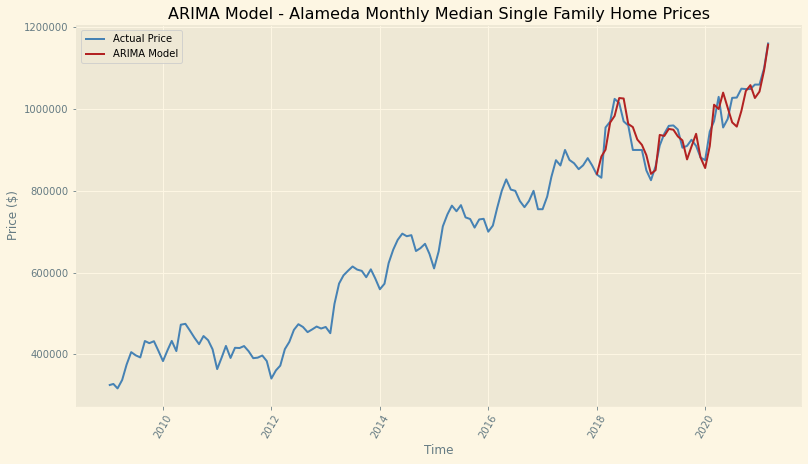

In [81]:
# Plot the Alameda Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_alm['Alameda'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_alm_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.title('ARIMA Model - Alameda Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [82]:
residuals_ARIMA = [df_aft_crisis_alm_valid['Alameda'].iloc[i]-df_aft_crisis_alm_valid['Prediction ARIMA'].iloc[i] for i in range(len(df_aft_crisis_alm_valid))]
residuals_ARIMA = pd.DataFrame(residuals_ARIMA)
print (residuals_ARIMA.describe([.05,.1,.25,.5,.75,.9,0.95]))
print (df_aft_crisis_alm_valid[['Error ARIMA']].describe([.05,.1,.25,.5,.75,.9,0.95]))

                  0
count     39.000000
mean     658.666667
std    34533.753215
min   -85347.000000
5%    -55920.300000
10%   -42589.600000
25%   -21686.000000
50%     2867.000000
75%    18224.000000
90%    44193.600000
95%    55083.200000
max    71069.000000
       Error ARIMA
count    39.000000
mean      0.000385
std       0.035997
min      -0.069000
5%       -0.057100
10%      -0.043200
25%      -0.020000
50%      -0.002000
75%       0.024000
90%       0.046800
95%       0.062000
max       0.089000


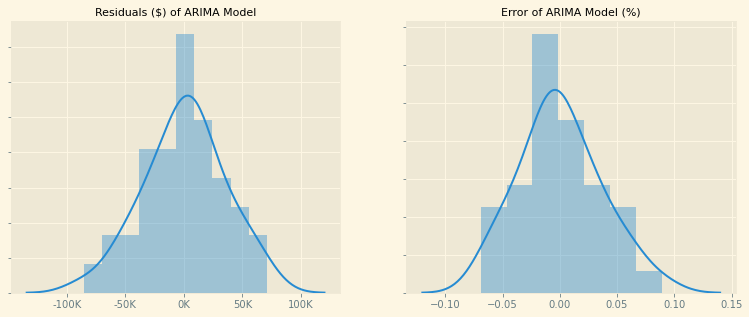

In [83]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA, ax=axes[0], bins=10, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_alm_valid['Error ARIMA'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model (%)',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

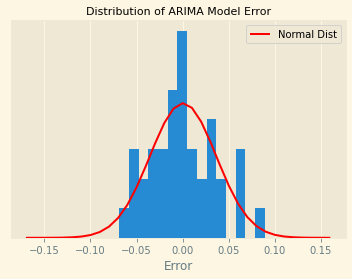

In [84]:
# 
x = np.arange(-0.17,0.17,0.01)

df_aft_crisis_alm_valid['Error ARIMA'].hist(bins=15, density=True)
plt.plot(x , sp.stats.norm(loc = df_aft_crisis_alm_valid['Error ARIMA'].mean(), 
                           scale = df_aft_crisis_alm_valid['Error ARIMA'].std()).pdf(x),
                         linewidth=2 , color='red', label = 'Normal Dist')
plt.yticks([])
plt.xlabel('Error')
plt.title('Distribution of ARIMA Model Error', fontdict={'fontsize':11})
plt.legend()
plt.show()

In [85]:
residuals_ARIMA_log = [df_aft_crisis_alm_valid['Alameda (Log)'].iloc[i]-df_aft_crisis_alm_valid['Prediction (Log)'].iloc[i] 
                       for i in range(len(df_aft_crisis_alm_valid))]
residuals_ARIMA_log = pd.DataFrame(residuals_ARIMA_log)
print(residuals_ARIMA_log.describe())

               0
count  39.000000
mean    0.000224
std     0.035901
min    -0.085598
25%    -0.023448
50%     0.002468
75%     0.020158
max     0.071623


future prediction:

In [86]:
# Add 12 months to the end of the df_aft_crisis_bay_valid
df_future = future_data_needed(df_aft_crisis_alm_valid, pred_months=12)

In [87]:
# Make the dataset of next 12 months predictions
df_aft_crisis_alm_pred = future_pred_ARIMA(df_future, df_aft_crisis_alm_train, 
                                           ARIMA_order=(3,0,12), pred_col = 'Alameda (Log)', pred_months=12)

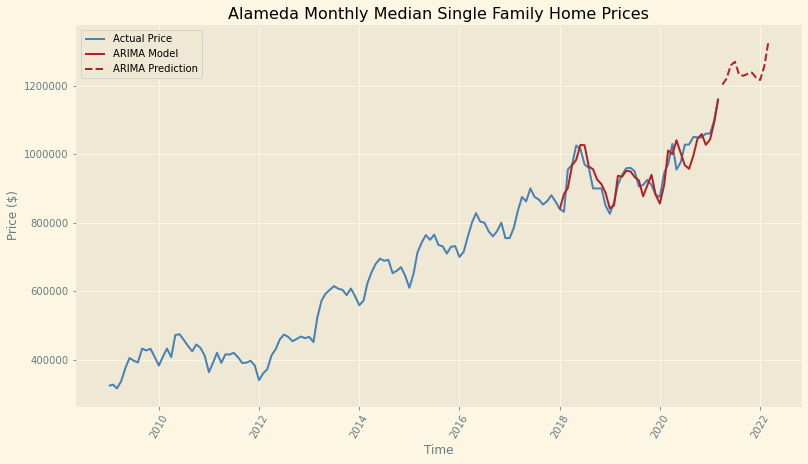

In [88]:
# Plot the Alameda Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_alm['Alameda'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_alm_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_alm_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction')
plt.title('Alameda Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [89]:
# margin of error on predictions error

error_list = df_aft_crisis_alm_pred['Error ARIMA'].dropna()
error_list.describe([0.025,0.05,0.1,0.5,0.95,0.975])

count    39.000000
mean      0.000385
std       0.035997
min      -0.069000
2.5%     -0.058550
5%       -0.057100
10%      -0.043200
50%      -0.002000
95%       0.062000
97.5%     0.063350
max       0.089000
Name: Error ARIMA, dtype: float64

In [90]:
print ('mean of error:', np.mean(error_list))
print ('std deviation of error:', np.std(error_list))
print ('std dev of sample:',statistics.stdev(error_list))
############# 
critical_value = 1.96
std = statistics.stdev(error_list)
sample = len(error_list)
MOE = critical_value * (std / np.sqrt(sample))
print ('margin of error:', MOE)
print ('lower:', np.mean(error_list)-MOE)
print ('highr:', np.mean(error_list)+MOE)
high_bond_rate = 1 + np.mean(error_list)+MOE
low_bond_rate = 1 + np.mean(error_list)-MOE

mean of error: 0.0003846153846153837
std deviation of error: 0.03553230049825405
std dev of sample: 0.03599679472910374
margin of error: 0.011297636554429263
lower: -0.010913021169813878
highr: 0.011682251939044647


Create the 95% interval confidence area:

In [91]:
# higher and lower rate comes from error distribution for 2.5% , 97.5% (95% confidence interval)

df_aft_crisis_alm_pred['lower_bond'] = (df_aft_crisis_alm_pred['Prediction ARIMA']* (1-0.05855)).astype(int)
df_aft_crisis_alm_pred['higher_bond'] = (df_aft_crisis_alm_pred['Prediction ARIMA'] * (1.06333)).astype(int)

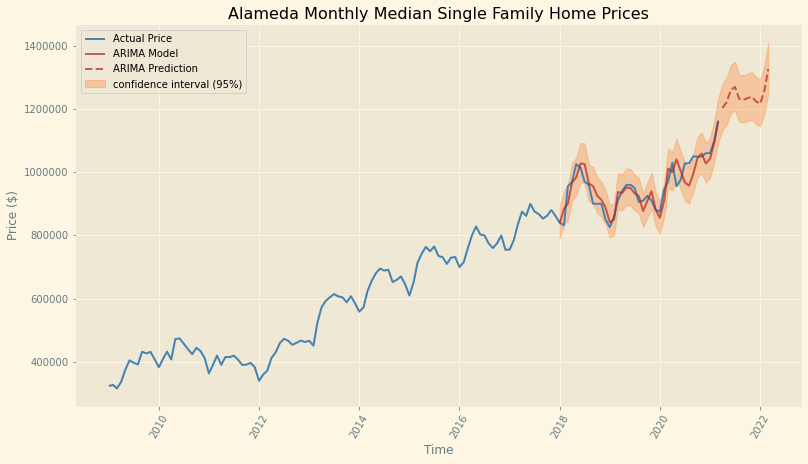

In [92]:
# Plot the Bay Area Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_alm['Alameda'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_alm_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model', alpha=0.7)
plt.plot( df_aft_crisis_alm_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction', alpha=0.7)
ax.fill_between(df_aft_crisis_alm_pred.index, df_aft_crisis_alm_pred['lower_bond'], df_aft_crisis_alm_pred['higher_bond'], color='#ff7823', alpha=0.3, label="confidence interval (95%)");
plt.title('Alameda Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [93]:
# Create ALAMEDA Historical dataframe
df_aft_alm_b = df_aft_crisis_alm_train[['Alameda']].copy()
df_aft_alm_b = df_aft_alm_b.reset_index()
df_aft_alm_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Time     108 non-null    datetime64[ns]
 1   Alameda  108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [94]:
# Create ALAMEDA prediction dataframe
df_aft_alm_p = df_aft_crisis_alm_pred[['Alameda','Prediction ARIMA','lower_bond','higher_bond']].copy()
df_aft_alm_p['Prediction ARIMA'] = df_aft_alm_p['Prediction ARIMA'].astype(int)
df_aft_alm_p['Alameda'] = df_aft_alm_p['Alameda'].astype('float64')
df_aft_alm_p.index.names = ['Time']
df_aft_alm_p = df_aft_alm_p.reset_index()
df_aft_alm_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              51 non-null     datetime64[ns]
 1   Alameda           39 non-null     float64       
 2   Prediction ARIMA  51 non-null     int64         
 3   lower_bond        51 non-null     int64         
 4   higher_bond       51 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 KB


In [95]:
df_alm = pd.concat([df_aft_alm_b, df_aft_alm_p])

In [96]:
# change the time column in order to visualize better 
df_alm['Time2'] = df_alm['Time'].dt.strftime('%b %d %Y')  # non-ISO serialization 

In [97]:
# let's just check few rows
df_alm.iloc[105:115]

Time    Alameda  Prediction ARIMA  lower_bond  higher_bond  \
105 2017-10-01   862450.0               NaN         NaN          NaN   
106 2017-11-01   880000.0               NaN         NaN          NaN   
107 2017-12-01   862000.0               NaN         NaN          NaN   
0   2018-01-01   840000.0          839515.0    790361.0     892681.0   
1   2018-02-01   832000.0          883968.0    832211.0     939949.0   
2   2018-03-01   955000.0          900712.0    847975.0     957754.0   
3   2018-04-01   969300.0          967024.0    910404.0    1028265.0   
4   2018-05-01  1025000.0          983330.0    925756.0    1045604.0   
5   2018-06-01  1015000.0         1027077.0    966941.0    1092121.0   
6   2018-07-01   970000.0         1025941.0    965872.0    1090913.0   

           Time2  
105  Oct 01 2017  
106  Nov 01 2017  
107  Dec 01 2017  
0    Jan 01 2018  
1    Feb 01 2018  
2    Mar 01 2018  
3    Apr 01 2018  
4    May 01 2018  
5    Jun 01 2018  
6    Jul 01 2018

In [98]:
# save df_alm for use in charts notebooks - website-chart-a , website-chart-b. 


df_alm.to_pickle('df_alm.pickle')

In [99]:
# Plot chart 1 without drop down menu # This may not work - the complete version came in the other notebook

base = alt.Chart(df_alm).transform_calculate(
    line1="'Actual Value'",
    line2="'Prediction'",
    shade="'95% Confidence Interval'",
).properties(
    height=360,
    width = 800, title = 'Alameda Single Family Home Price'
    
)


scale = alt.Scale(domain=["Actual Value", "Prediction", "95% Confidence Interval"], range=['blue', 'red', 'grey'])


line1 = base.mark_line(opacity=0.6,color='blue').encode(
    x=alt.X('Time2:T',title='Time'),
    y=alt.Y('Alameda',axis = alt.Axis(title="Price")),
    color = alt.Color('line1:N', scale=scale,title=''),
)

line2 = base.mark_line(opacity=0.6,color='red').encode(
    x=alt.X('Time2:T',title='Time'),
    y=alt.Y('Prediction ARIMA',axis = alt.Axis(title="Price")),
    color = alt.Color('line2:N',scale=scale, title=''),
)


shade = base.mark_area(opacity=0.25,color='grey').encode(
    x=alt.X('Time2:T',title='Time'),
    y=alt.Y("lower_bond", axis = alt.Axis(title="Price")),
    y2='higher_bond',
    color =alt.Color('shade:N',scale=scale, title='')
)



# Tooltip Function 

def createTooltip():
    """
        This function creates a tooltip containing the date, and prices displayed upon hover
    
    """
    hover = alt.selection_single(
        fields=["Time2"],
        nearest=True,
        on="mouseover",
        empty="none",
        clear="mouseout",
    )
    
    
    tooltips = alt.Chart(df_alm).transform_calculate(
    P="isValid(datum['Prediction ARIMA']) ? datum['Prediction ARIMA'] : 'NA'",
    A="isValid(datum['Alameda']) ? datum['Alameda'] : 'NA'",
    L="isValid(datum['lower_bond']) ? datum['lower_bond'] : 'NA'",
    U="isValid(datum['higher_bond']) ? datum['higher_bond'] : 'NA'").mark_rule(strokeWidth=0.5,  color="black", strokeDash=[4,2]).encode(
    x='Time',
    opacity=alt.condition(hover, alt.value(1), alt.value(0)),
    tooltip=[alt.Tooltip("Time2:T", title = 'Time'),
             alt.Tooltip("A:N", title='Actual Value',format=",.0f"), 
             alt.Tooltip("P:N", title='Prediction',format=",.0f"),
             alt.Tooltip("L:N", title='95% Lower Limit',format=",.0f"),
             alt.Tooltip("U:N", title="95% Upper Limit",format=",.0f")]
).add_selection(hover)
    
    return tooltips


tooltips =  createTooltip()


chart1 = alt.layer(line1+line2+shade, tooltips
    ).configure_title(fontSize=24,font='Courier', color='dimgrey',anchor='start', dx=30, dy=-15
    ).configure_legend(labelFontSize=12, labelColor='k'
    ).configure_axisY(labelPadding=10, titleX=-70, labelFontSize=12,titleFontSize=16, titleColor = 'dimgray', titleFont = 'Open Sans' , labelColor = 'grey'
    ).configure_axisX(grid=False,titleY=30,titleFontSize=16, labelFontSize=12, titleColor = 'dimgray', titleFont = 'Open Sans', labelColor = 'grey'
    ).configure_axis(gridOpacity = 0.6
    ).interactive()


chart1

alt.LayerChart(...)

<br>

<font color=blue  size=20> 3 - Contra Costa </font>

<br>

In [100]:
# Split Contra Costa Dataset 

df_aft_crisis_con = df_aft_crisis[['Contra Costa']]

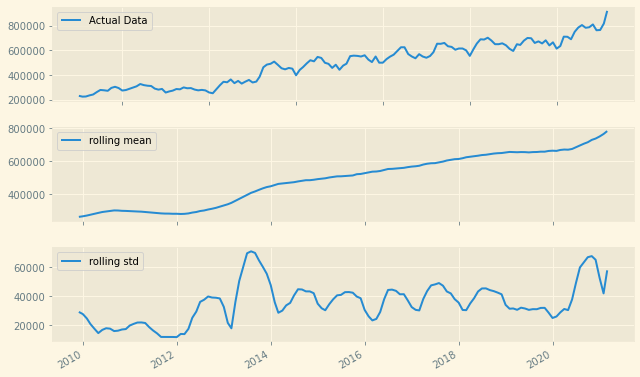

In [101]:
# Plot Rolling mean and variance

plot_rolling(df_aft_crisis_con)

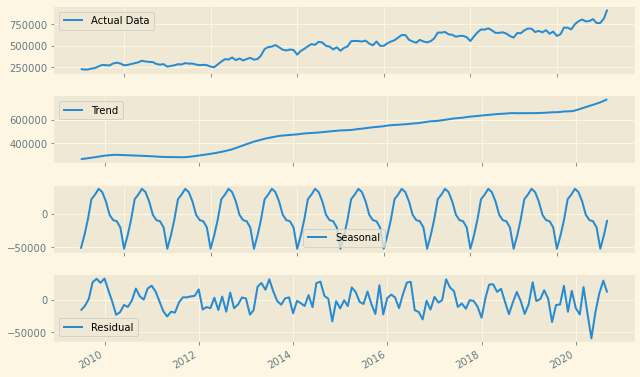

In [102]:
# Plot decompose charts

decomp_plot(df_aft_crisis_con)

In [103]:
adfuller_test(df_aft_crisis_con)


 > Is the data stationary ?

Test statistic = 0.982
P-value = 0.994
#Lag used = 13
Number of observations = 133
Critical values :
	1%: -3.481 - The data is not stationary with 99% confidence
	5%: -2.884 - The data is not stationary with 95% confidence
	10%: -2.578 - The data is not stationary with 90% confidence


In [104]:
# Create Contra Costa Logarithmic Column

df_aft_crisis_con['Contra Costa (Log)'] = df_aft_crisis_con['Contra Costa'].apply(lambda x : np.log(x))

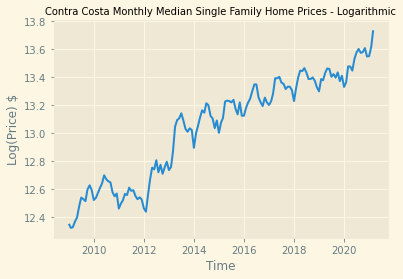

In [105]:
# Plot Log(Df) Dataset

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_aft_crisis_con['Contra Costa (Log)'])
plt.title('Contra Costa Monthly Median Single Family Home Prices - Logarithmic', fontdict={'fontsize':10}) 
plt.ylabel('Log(Price) $')
plt.xlabel('Time')
plt.show()

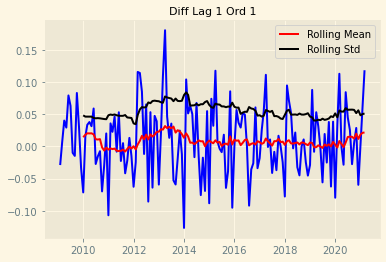

ADF Statistic: -1.7442889749306136
p-value: 0.40844992784548956
Critical Values:
	1%: -3.480500383888377
	5%: -2.8835279559405045
	10%: -2.578495716547007


In [106]:
# Differencing order 1

df_aft_crisis_con['Diff Lag 1 Ord 1'] = np.NaN
df_aft_crisis_con['Diff Lag 1 Ord 1'].iloc[1:] = np.diff(df_aft_crisis_con['Contra Costa (Log)'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_con[['Diff Lag 1 Ord 1']])

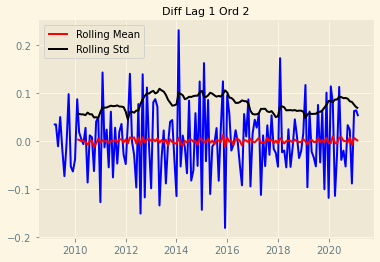

ADF Statistic: -11.433549219068091
p-value: 6.429276727800031e-21
Critical Values:
	1%: -3.480500383888377
	5%: -2.8835279559405045
	10%: -2.578495716547007


In [107]:
# Differencing order 2

df_aft_crisis_con['Diff Lag 1 Ord 2'] = np.NaN
df_aft_crisis_con['Diff Lag 1 Ord 2'].iloc[1:] = np.diff(df_aft_crisis_con['Diff Lag 1 Ord 1'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_con[['Diff Lag 1 Ord 2']])

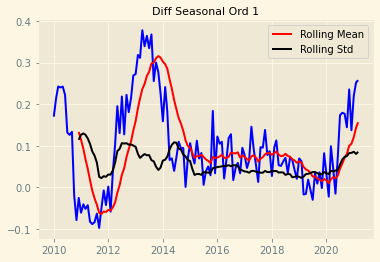

ADF Statistic: -3.490756677780856
p-value: 0.008227679765469263
Critical Values:
	1%: -3.4851223522012855
	5%: -2.88553750045158
	10%: -2.5795685622144586


In [108]:
# Differencing Seasonal order 1 

df_aft_crisis_con['Diff Seasonal Ord 1'] = np.NaN
df_aft_crisis_con['Diff Seasonal Ord 1'].iloc[12:] = diff(df_aft_crisis_con['Contra Costa (Log)'],interval =12)

# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_con[['Diff Seasonal Ord 1']])

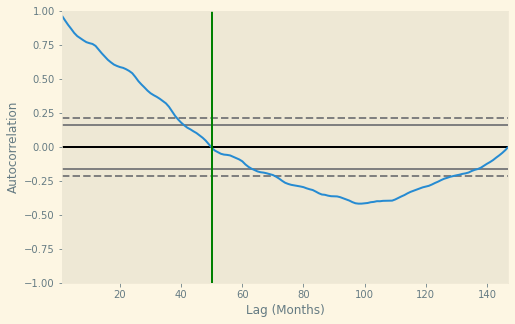

In [109]:
# Seasonality or Noise ?

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_con['Contra Costa (Log)'])
plt.axvline(50, color='green')
plt.xlabel('Lag (Months)')
plt.show()

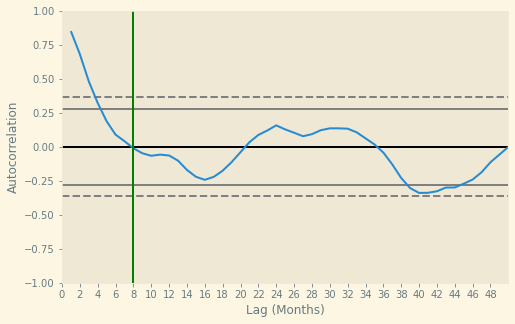

In [110]:
# Noise 

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_con['Contra Costa (Log)'][:50])
plt.xlabel('Lag (Months)')
plt.xticks(np.arange(0, 50, step=2))
plt.axvline(8, color='green')
plt.show()

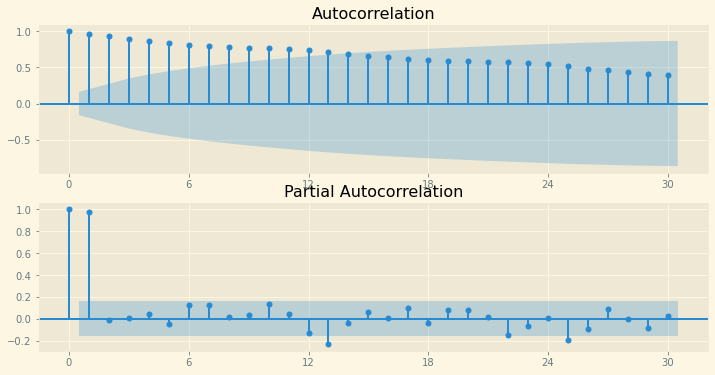

In [111]:
acf_pacf_plot(df_aft_crisis_con['Contra Costa (Log)'])

In [112]:
acf_pacf_plot(df_aft_crisis_con['Diff Seasonal Ord 1'])

Based on ACF and PACF figures, the possible appropriate values for p and q: 

    p : 1 , 2 , 5 
    
    q : 6 , 11 , 12
    
The best combination of parameters can be achived through grid search step. 

keep in mind that I do differencing (I part in ARIMA), manually in my model, therfore in ARIMA class I am going to use 0 as *I*. 

In [113]:
# Split the dataset into train and valid datasets 

df_aft_crisis_con_train = df_aft_crisis_con[df_aft_crisis_con.index.year < 2018].dropna(how='all')
df_aft_crisis_con_valid = df_aft_crisis_con[df_aft_crisis_con.index.year >= 2018].dropna(how='all')

In [114]:
# Get the shape of training and valdation dataset 
print('df train after crisis Shape', df_aft_crisis_con_train.shape)
print('df valid after crisis Shape', df_aft_crisis_con_valid.shape)

df train after crisis Shape (108, 5)
df valid after crisis Shape (39, 5)


In [115]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_model_ARIMA(arima_order):
    
    
    history_con = [x for x in df_aft_crisis_con_train['Contra Costa (Log)']]
    predictions = list()

    for i in range(len(df_aft_crisis_con_valid)):
    
        #difference data
            months_in_year = 12
            diff_df = diff(history_con, months_in_year)
    
        # predict
            model = ARIMA(diff_df, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            yhat = inverse_difference(history_con, yhat, months_in_year)
            predictions.append(yhat)
    
        # observation
            obs = df_aft_crisis_con_valid['Contra Costa (Log)'].iloc[i]
            history_con.append(obs)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(df_aft_crisis_con_valid['Contra Costa (Log)'], predictions))
    return rmse

In [116]:
# Grid Search for ARIMA model
p_values = range(3, 5)
d_values = range(0, 2)
q_values = range(11, 13)
warnings.filterwarnings("ignore")
i_test = evaluate_models(evaluate_model_ARIMA ,p_values, d_values, q_values)

Models Parameters and Performance: Loading.....
ARIMA(3, 0, 11) RMSE=0.0431
ARIMA(3, 1, 11) RMSE=0.0416
Best: ARIMA(3, 1, 11) RMSE=0.0416


In [117]:
history_con = [x for x in df_aft_crisis_con_train['Contra Costa (Log)']]
predictions = list()

for i in range(len(df_aft_crisis_con_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_con, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(3,0,11))
    model_fit_ARIMA = model.fit()
    yhat = model_fit_ARIMA.forecast()[0]
    yhat = inverse_difference(history_con, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_con_valid['Contra Costa (Log)'].iloc[i]
    history_con.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_con_valid['Contra Costa (Log)'], predictions))
print('RMSE: %.4f' % rmse)

RMSE: 0.0431


In [118]:
# Predictions and Error Columns

df_aft_crisis_con_valid['Prediction (Log)'] = predictions 
df_aft_crisis_con_valid['Prediction ARIMA'] = df_aft_crisis_con_valid['Prediction (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_con_valid['Error ARIMA'] = round(((df_aft_crisis_con_valid['Prediction ARIMA'] - df_aft_crisis_con_valid['Contra Costa'])
                                                /df_aft_crisis_con_valid['Contra Costa']),3)

In [119]:
df_aft_crisis_con_valid.head(3)

Contra Costa  Contra Costa (Log)  Diff Lag 1 Ord 1  \
Time                                                             
2018-01-01      555000.0           13.226723         -0.077962   
2018-02-01      610000.0           13.321214          0.094491   
2018-03-01      655000.0           13.392391          0.071176   

            Diff Lag 1 Ord 2  Diff Seasonal Ord 1  Prediction (Log)  \
Time                                                                  
2018-01-01         -0.053269             0.027399         13.243053   
2018-02-01          0.172452             0.095843         13.314169   
2018-03-01         -0.023315             0.113023         13.328568   

            Prediction ARIMA  Error ARIMA  
Time                                       
2018-01-01            564137        0.016  
2018-02-01            605717       -0.007  
2018-03-01            614502       -0.062

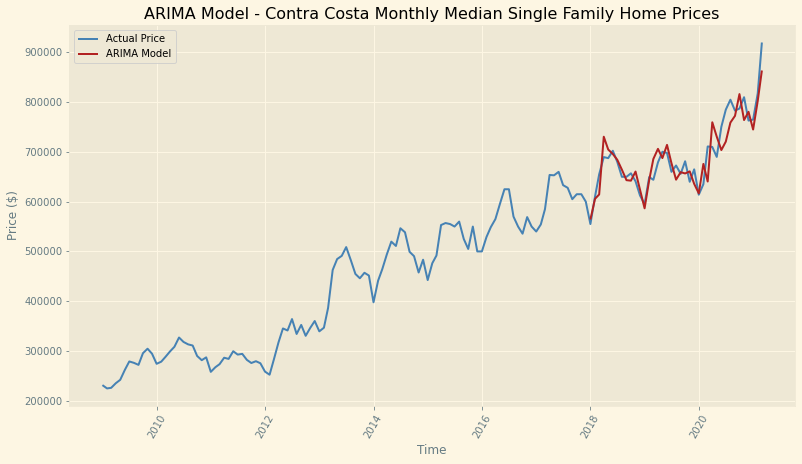

In [120]:
# Plot the Contra Costa Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_con['Contra Costa'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_con_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.title('ARIMA Model - Contra Costa Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [121]:
residuals_ARIMA = [df_aft_crisis_con_valid['Contra Costa'].iloc[i]-df_aft_crisis_con_valid['Prediction ARIMA'].iloc[i] for i in range(len(df_aft_crisis_con_valid))]
residuals_ARIMA = pd.DataFrame(residuals_ARIMA)
print (residuals_ARIMA.describe([.05,.1,.25,.5,.75,.9,0.95]))
print (df_aft_crisis_con_valid[['Error ARIMA']].describe([.05,.1,.25,.5,.75,.9,0.95]))

                  0
count     39.000000
mean    3402.153846
std    31075.606029
min   -49624.000000
5%    -41025.800000
10%   -40670.800000
25%   -17509.500000
50%     4283.000000
75%    22241.000000
90%    46125.400000
95%    57091.900000
max    70485.000000
       Error ARIMA
count    39.000000
mean     -0.003128
std       0.042984
min      -0.099000
5%       -0.064000
10%      -0.061200
25%      -0.031000
50%      -0.007000
75%       0.025500
90%       0.059000
95%       0.064100
max       0.070000


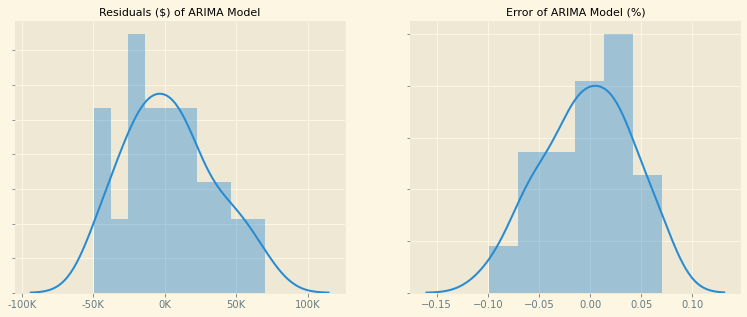

In [122]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA, ax=axes[0], bins=10, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_con_valid['Error ARIMA'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model (%)',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

In [123]:
# 
x = np.arange(-0.17,0.17,0.01)

df_aft_crisis_con_valid['Error ARIMA'].hist(bins=15, density=True)
plt.plot(x , sp.stats.norm(loc = df_aft_crisis_con_valid['Error ARIMA'].mean(), 
                           scale = df_aft_crisis_con_valid['Error ARIMA'].std()).pdf(x),
                         linewidth=2 , color='red', label = 'Normal Dist')
plt.yticks([])
plt.xlabel('Error')
plt.title('Distribution of ARIMA Model Error', fontdict={'fontsize':11})
plt.legend()
plt.show()

In [124]:
residuals_ARIMA_log = [df_aft_crisis_con_valid['Contra Costa (Log)'].iloc[i]-df_aft_crisis_con_valid['Prediction (Log)'].iloc[i] 
                       for i in range(len(df_aft_crisis_con_valid))]
residuals_ARIMA_log = pd.DataFrame(residuals_ARIMA_log)
print(residuals_ARIMA_log.describe())

               0
count  39.000000
mean    0.004052
std     0.043458
min    -0.067559
25%    -0.025429
50%     0.007046
75%     0.031547
max     0.104399


In [125]:
# Add 12 months to the end of the df_aft_crisis_bay_valid
df_future = future_data_needed(df_aft_crisis_con_valid, pred_months=12)

In [126]:
# Make the dataset of next 12 months predictions
df_aft_crisis_con_pred = future_pred_ARIMA(df_future, df_aft_crisis_con_train, 
                                               ARIMA_order=(3,0,11), pred_col = 'Contra Costa (Log)', pred_months=12)

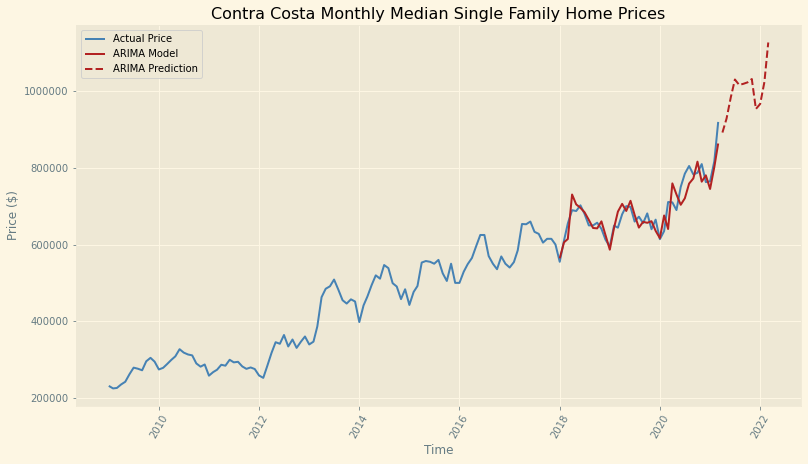

In [127]:
# Plot the Contra Costa Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_con['Contra Costa'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_con_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_con_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction')
plt.title('Contra Costa Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [128]:
# margin of error on predictions error

error_list = df_aft_crisis_con_pred['Error ARIMA'].dropna()
error_list.describe([0.025,0.05,0.1,0.5,0.95,0.975])

count    39.000000
mean     -0.003128
std       0.042984
min      -0.099000
2.5%     -0.082850
5%       -0.064000
10%      -0.061200
50%      -0.007000
95%       0.064100
97.5%     0.065250
max       0.070000
Name: Error ARIMA, dtype: float64

In [129]:
print ('mean of error:', np.mean(error_list))
print ('std deviation of error:', np.std(error_list))
print ('std dev of sample:',statistics.stdev(error_list))
############# 
critical_value = 1.96
std = statistics.stdev(error_list)
sample = len(error_list)
MOE = critical_value * (std / np.sqrt(sample))
print ('margin of error:', MOE)
print ('lower:', np.mean(error_list)-MOE)
print ('highr:', np.mean(error_list)+MOE)
high_bond_rate = 1 + np.mean(error_list)+MOE
low_bond_rate = 1 + np.mean(error_list)-MOE

mean of error: -0.003128205128205129
std deviation of error: 0.04242893273081319
std dev of sample: 0.04298358284347733
margin of error: 0.013490448258721921
lower: -0.01661865338692705
highr: 0.010362243130516792


In [130]:
# higher and lower rate comes from error distribution for 2.5% , 97.5% (95% confidence interval)

df_aft_crisis_con_pred['lower_bond'] = (df_aft_crisis_con_pred['Prediction ARIMA']* (1-0.0849)).astype(int)
df_aft_crisis_con_pred['higher_bond'] = (df_aft_crisis_con_pred['Prediction ARIMA'] * (1.06405)).astype(int)

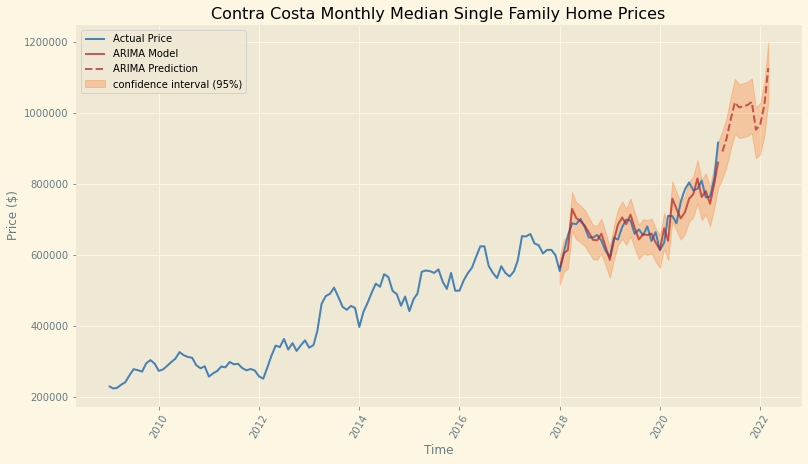

In [131]:
# Plot the Contra Costa Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_con['Contra Costa'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_con_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model', alpha=0.7)
plt.plot( df_aft_crisis_con_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction', alpha=0.7)
ax.fill_between(df_aft_crisis_con_pred.index, df_aft_crisis_con_pred['lower_bond'], df_aft_crisis_con_pred['higher_bond'], color='#ff7823', alpha=0.3, label="confidence interval (95%)");
plt.title('Contra Costa Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [132]:
df_aft_con_b = df_aft_crisis_con_train[['Contra Costa']].copy()
df_aft_con_b = df_aft_con_b.reset_index()
df_aft_con_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Time          108 non-null    datetime64[ns]
 1   Contra Costa  108 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB


In [133]:
df_aft_con_p = df_aft_crisis_con_pred[['Contra Costa','Prediction ARIMA','lower_bond','higher_bond']].copy()
df_aft_con_p['Prediction ARIMA'] = df_aft_con_p['Prediction ARIMA'].astype(int)
df_aft_con_p['Contra Costa'] = df_aft_con_p['Contra Costa'].astype('float64')
df_aft_con_p.index.names = ['Time']
df_aft_con_p = df_aft_con_p.reset_index()
df_aft_con_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              51 non-null     datetime64[ns]
 1   Contra Costa      39 non-null     float64       
 2   Prediction ARIMA  51 non-null     int64         
 3   lower_bond        51 non-null     int64         
 4   higher_bond       51 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 KB


In [134]:
df_con = pd.concat([df_aft_con_b, df_aft_con_p])

In [135]:
# change the time column in order to visualize better 
df_con['Time2'] = df_con['Time'].dt.strftime('%b %d %Y')  # non-ISO serialization 

In [136]:
df_con.iloc[105:115]

Time  Contra Costa  Prediction ARIMA  lower_bond  higher_bond  \
105 2017-10-01      615000.0               NaN         NaN          NaN   
106 2017-11-01      615000.0               NaN         NaN          NaN   
107 2017-12-01      600000.0               NaN         NaN          NaN   
0   2018-01-01      555000.0          564137.0    516241.0     600269.0   
1   2018-02-01      610000.0          605717.0    554291.0     644513.0   
2   2018-03-01      655000.0          614502.0    562330.0     653860.0   
3   2018-04-01      689660.0          730589.0    668561.0     777383.0   
4   2018-05-01      687500.0          704820.0    644980.0     749963.0   
5   2018-06-01      702370.0          695802.0    636728.0     740368.0   
6   2018-07-01      680000.0          684251.0    626158.0     728077.0   

           Time2  
105  Oct 01 2017  
106  Nov 01 2017  
107  Dec 01 2017  
0    Jan 01 2018  
1    Feb 01 2018  
2    Mar 01 2018  
3    Apr 01 2018  
4    May 01 2018  
5    Jun 01 2018  
6    Jul 01 2018

In [137]:
# save df_con for use in test2 notebook


df_con.to_pickle('df_con.pickle')

<br>

<font color=blue  size=20> 4 - Marin </font>

<br>

In [138]:
# Split Marin Dataset 

df_aft_crisis_mar = df_aft_crisis[['Marin']]

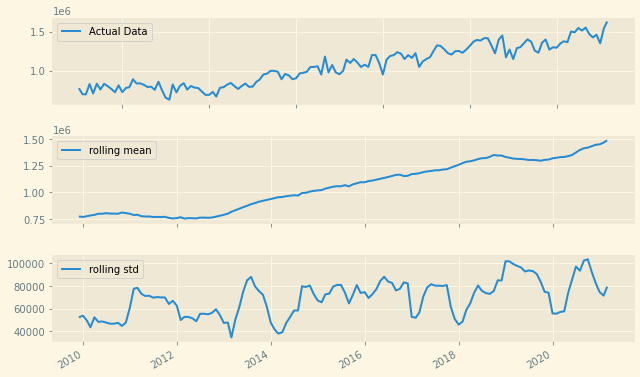

In [139]:
# Plot Rolling mean and variance

plot_rolling(df_aft_crisis_mar)

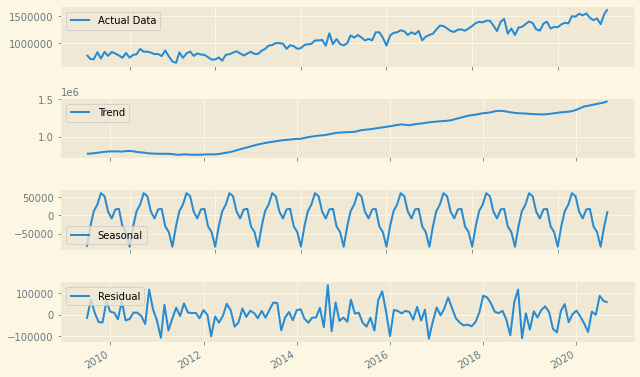

In [140]:
# Plot decompose charts

decomp_plot(df_aft_crisis_mar)

In [141]:
adfuller_test(df_aft_crisis_mar)


 > Is the data stationary ?

Test statistic = 0.797
P-value = 0.992
#Lag used = 13
Number of observations = 133
Critical values :
	1%: -3.481 - The data is not stationary with 99% confidence
	5%: -2.884 - The data is not stationary with 95% confidence
	10%: -2.578 - The data is not stationary with 90% confidence


In [142]:
# Create Marin Logarithmic Column

df_aft_crisis_mar['Marin (Log)'] = df_aft_crisis_mar['Marin'].apply(lambda x : np.log(x))

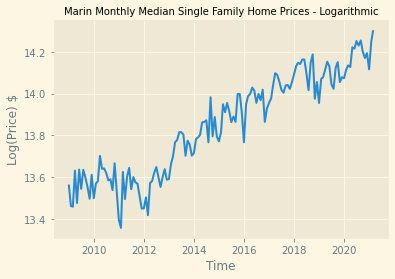

In [143]:
# Plot Log(Df) Dataset

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_aft_crisis_mar['Marin (Log)'])
plt.title('Marin Monthly Median Single Family Home Prices - Logarithmic', fontdict={'fontsize':10}) 
plt.ylabel('Log(Price) $')
plt.xlabel('Time')
plt.show()

In [144]:
# Differencing order 1

df_aft_crisis_mar['Diff Lag 1 Ord 1'] = np.NaN
df_aft_crisis_mar['Diff Lag 1 Ord 1'].iloc[1:] = np.diff(df_aft_crisis_mar['Marin (Log)'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_mar[['Diff Lag 1 Ord 1']])

ADF Statistic: -2.5109837344260946
p-value: 0.11282468503401116
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


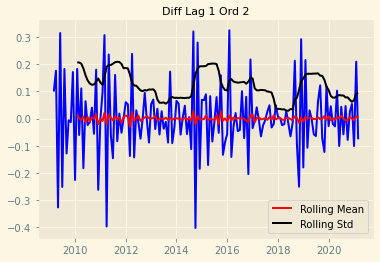

ADF Statistic: -8.666828159167226
p-value: 4.659994570386289e-14
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


In [145]:
# Differencing order 2

df_aft_crisis_mar['Diff Lag 1 Ord 2'] = np.NaN
df_aft_crisis_mar['Diff Lag 1 Ord 2'].iloc[1:] = np.diff(df_aft_crisis_mar['Diff Lag 1 Ord 1'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_mar[['Diff Lag 1 Ord 2']])

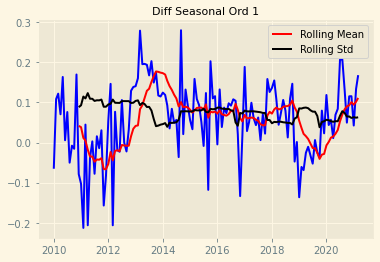

ADF Statistic: -3.9377803048121613
p-value: 0.001773744199973942
Critical Values:
	1%: -3.4846672514209773
	5%: -2.8853397507076006
	10%: -2.5794629869786503


In [146]:
# Differencing Seasonal order 1 

df_aft_crisis_mar['Diff Seasonal Ord 1'] = np.NaN
df_aft_crisis_mar['Diff Seasonal Ord 1'].iloc[12:] = diff(df_aft_crisis_mar['Marin (Log)'],interval =12)

# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_mar[['Diff Seasonal Ord 1']])

In [147]:
# Seasonality or Noise ?

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_mar['Marin (Log)'])
plt.axvline(50, color='green')
plt.xlabel('Lag (Months)')
plt.show()

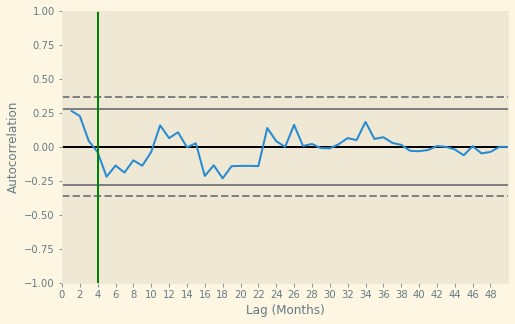

In [148]:
# Noise 

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_mar['Marin (Log)'][:50])
plt.xlabel('Lag (Months)')
plt.xticks(np.arange(0, 50, step=2))
plt.axvline(4, color='green')
plt.show()

In [149]:
acf_pacf_plot(df_aft_crisis_mar['Marin (Log)'])

In [150]:
acf_pacf_plot(df_aft_crisis_mar['Diff Seasonal Ord 1'])

Based on ACF and PACF figures, the possible appropriate values for p and q: 

    p : 1 , 2 , 4 
    
    q : 1 , 2 , 12
    
The best combination of parameters can be achived through grid search step. 

keep in mind that I do differencing (I part in ARIMA), manually in my model, therfore in ARIMA class I am going to use 0 as *I*. 

In [151]:
# Split the dataset into train and valid datasets 

df_aft_crisis_mar_train = df_aft_crisis_mar[df_aft_crisis_mar.index.year < 2018].dropna(how='all')
df_aft_crisis_mar_valid = df_aft_crisis_mar[df_aft_crisis_mar.index.year >= 2018].dropna(how='all')

In [152]:
# Get the shape of training and valdation dataset 
print('df train after crisis Shape', df_aft_crisis_mar_train.shape)
print('df valid after crisis Shape', df_aft_crisis_mar_valid.shape)

df train after crisis Shape (108, 5)
df valid after crisis Shape (39, 5)


In [153]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_model_ARIMA(arima_order):
    
    
    history_mar = [x for x in df_aft_crisis_mar_train['Marin (Log)']]
    predictions = list()

    for i in range(len(df_aft_crisis_mar_valid)):
    
        #difference data
            months_in_year = 12
            diff_df = diff(history_mar, months_in_year)
    
        # predict
            model = ARIMA(diff_df, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            yhat = inverse_difference(history_mar, yhat, months_in_year)
            predictions.append(yhat)
    
        # observation
            obs = df_aft_crisis_mar_valid['Marin (Log)'].iloc[i]
            history_mar.append(obs)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(df_aft_crisis_mar_valid['Marin (Log)'], predictions))
    return rmse

In [154]:
# Grid Search for ARIMA model
p_values = range(2, 5)
d_values = range(0, 2)
q_values = range(11, 13)
warnings.filterwarnings("ignore")
i_test = evaluate_models(evaluate_model_ARIMA ,p_values, d_values, q_values)

Models Parameters and Performance: Loading.....
ARIMA(2, 0, 11) RMSE=0.0645
ARIMA(2, 0, 12) RMSE=0.0583
ARIMA(3, 1, 12) RMSE=0.0578
ARIMA(4, 0, 12) RMSE=0.0568
Best: ARIMA(4, 0, 12) RMSE=0.0568


In [155]:
history_mar = [x for x in df_aft_crisis_mar_train['Marin (Log)']]
predictions = list()

for i in range(len(df_aft_crisis_mar_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_mar, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(4,0,12))
    model_fit_ARIMA = model.fit()
    yhat = model_fit_ARIMA.forecast()[0]
    yhat = inverse_difference(history_mar, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_mar_valid['Marin (Log)'].iloc[i]
    history_mar.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_mar_valid['Marin (Log)'], predictions))
print('RMSE: %.4f' % rmse)

RMSE: 0.0568


In [156]:
# Predictions and Error Columns

df_aft_crisis_mar_valid['Prediction (Log)'] = predictions 
df_aft_crisis_mar_valid['Prediction ARIMA'] = df_aft_crisis_mar_valid['Prediction (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_mar_valid['Error ARIMA'] = round(((df_aft_crisis_mar_valid['Prediction ARIMA'] - df_aft_crisis_mar_valid['Marin'])
                                                /df_aft_crisis_mar_valid['Marin']),3)

In [157]:
df_aft_crisis_mar_valid.head(3)

Marin  Marin (Log)  Diff Lag 1 Ord 1  Diff Lag 1 Ord 2  \
Time                                                                   
2018-01-01  1317500    14.091247          0.037586          0.006449   
2018-02-01  1371000    14.131051          0.039804          0.002219   
2018-03-01  1392500    14.146611          0.015560         -0.024244   

            Diff Seasonal Ord 1  Prediction (Log)  Prediction ARIMA  \
Time                                                                  
2018-01-01             0.135974         13.970173           1167263   
2018-02-01             0.154698         14.049761           1263961   
2018-03-01             0.107957         14.136077           1377908   

            Error ARIMA  
Time                     
2018-01-01       -0.114  
2018-02-01       -0.078  
2018-03-01       -0.010

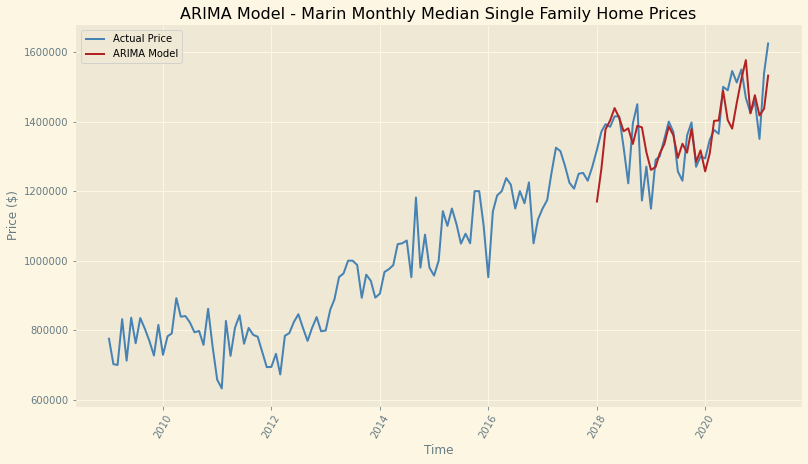

In [158]:
# Plot Marin Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_mar['Marin'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_mar_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.title('ARIMA Model - Marin Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [159]:
residuals_ARIMA = [df_aft_crisis_mar_valid['Marin'].iloc[i]-df_aft_crisis_mar_valid['Prediction ARIMA'].iloc[i] for i in range(len(df_aft_crisis_mar_valid))]
residuals_ARIMA = pd.DataFrame(residuals_ARIMA)
print (residuals_ARIMA.describe([.05,.1,.25,.5,.75,.9,0.95]))
print (df_aft_crisis_mar_valid[['Error ARIMA']].describe([.05,.1,.25,.5,.75,.9,0.95]))

                   0
count      39.000000
mean     2353.897436
std     76941.316765
min   -210445.000000
5%    -116292.100000
10%   -106682.200000
25%    -32188.000000
50%      9645.000000
75%     43950.000000
90%     94612.400000
95%    111358.800000
max    165721.000000
       Error ARIMA
count    39.000000
mean      0.000974
std       0.058434
min      -0.114000
5%       -0.080900
10%      -0.059000
25%      -0.032500
50%      -0.007000
75%       0.023500
90%       0.076400
95%       0.100200
max       0.179000


In [160]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA, ax=axes[0], bins=10, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_mar_valid['Error ARIMA'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model (%)',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

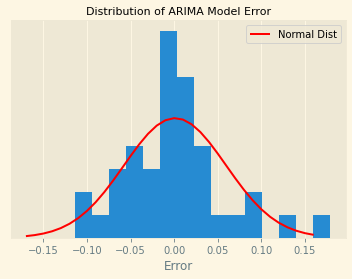

In [161]:
# 
x = np.arange(-0.17,0.17,0.01)

df_aft_crisis_mar_valid['Error ARIMA'].hist(bins=15, density=True)
plt.plot(x , sp.stats.norm(loc = df_aft_crisis_mar_valid['Error ARIMA'].mean(), 
                           scale = df_aft_crisis_mar_valid['Error ARIMA'].std()).pdf(x),
                         linewidth=2 , color='red', label = 'Normal Dist')
plt.yticks([])
plt.xlabel('Error')
plt.title('Distribution of ARIMA Model Error', fontdict={'fontsize':11})
plt.legend()
plt.show()

In [162]:
residuals_ARIMA_log = [df_aft_crisis_mar_valid['Marin (Log)'].iloc[i]-df_aft_crisis_mar_valid['Prediction (Log)'].iloc[i] 
                       for i in range(len(df_aft_crisis_mar_valid))]
residuals_ARIMA_log = pd.DataFrame(residuals_ARIMA_log)
print(residuals_ARIMA_log.describe())

               0
count  39.000000
mean    0.000595
std     0.057495
min    -0.165021
25%    -0.023223
50%     0.007065
75%     0.033005
max     0.121074


In [163]:
# Add 12 months to the end of the df_aft_crisis_bay_valid
df_future = future_data_needed(df_aft_crisis_mar_valid, pred_months=12)

In [164]:
# Make the dataset of next 12 months predictions
df_aft_crisis_mar_pred = future_pred_ARIMA(df_future, df_aft_crisis_mar_train, 
                                               ARIMA_order=(4,0,12), pred_col = 'Marin (Log)', pred_months=12)

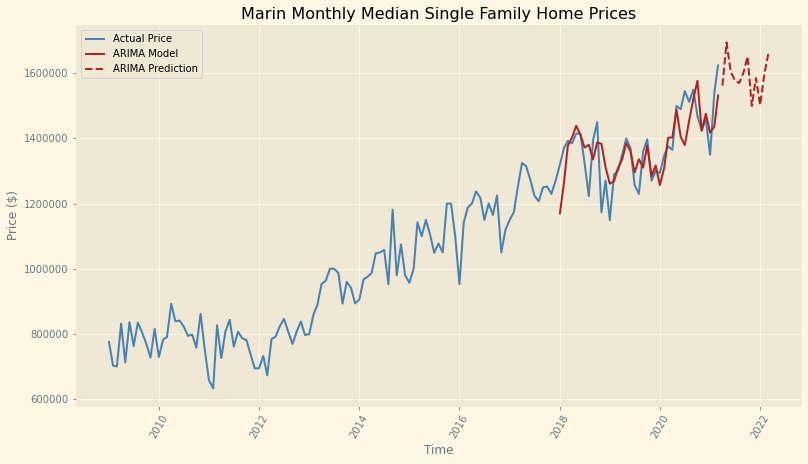

In [165]:
# Plot the Marin Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_mar['Marin'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_mar_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_mar_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction')
plt.title('Marin Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [166]:
# margin of error on predictions error

error_list = df_aft_crisis_mar_pred['Error ARIMA'].dropna()
error_list.describe([0.025,0.05,0.1,0.5,0.95,0.975])

count    39.000000
mean      0.000974
std       0.058434
min      -0.114000
2.5%     -0.107350
5%       -0.080900
10%      -0.059000
50%      -0.007000
95%       0.100200
97.5%     0.131500
max       0.179000
Name: Error ARIMA, dtype: float64

In [167]:
print ('mean of error:', np.mean(error_list))
print ('std deviation of error:', np.std(error_list))
print ('std dev of sample:',statistics.stdev(error_list))
############# 
critical_value = 1.96
std = statistics.stdev(error_list)
sample = len(error_list)
MOE = critical_value * (std / np.sqrt(sample))
print ('margin of error:', MOE)
print ('lower:', np.mean(error_list)-MOE)
print ('highr:', np.mean(error_list)+MOE)
high_bond_rate = 1 + np.mean(error_list)+MOE
low_bond_rate = 1 + np.mean(error_list)-MOE

mean of error: 0.0009743589743589743
std deviation of error: 0.057679702326611584
std dev of sample: 0.058433717366227586
margin of error: 0.018339491232371673
lower: -0.0173651322580127
highr: 0.019313850206730647


In [168]:
# higher and lower rate comes from error distribution for 2.5% , 97.5% (95% confidence interval)

df_aft_crisis_mar_pred['lower_bond'] = (df_aft_crisis_mar_pred['Prediction ARIMA']* (1-0.0809)).astype(int)
df_aft_crisis_mar_pred['higher_bond'] = (df_aft_crisis_mar_pred['Prediction ARIMA'] * (1.1002)).astype(int)

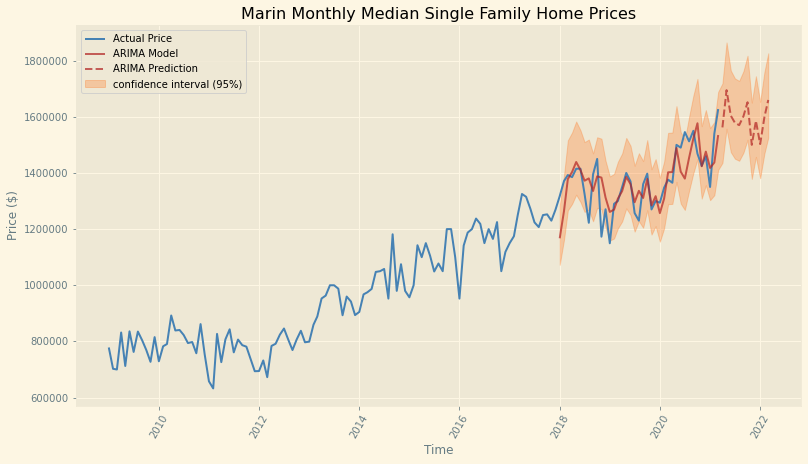

In [169]:
# Plot the Marin Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_mar['Marin'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_mar_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model', alpha=0.7)
plt.plot( df_aft_crisis_mar_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction', alpha=0.7)
ax.fill_between(df_aft_crisis_mar_pred.index, df_aft_crisis_mar_pred['lower_bond'], df_aft_crisis_mar_pred['higher_bond'], color='#ff7823', alpha=0.3, label="confidence interval (95%)");
plt.title('Marin Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [170]:
df_aft_mar_b = df_aft_crisis_mar_train[['Marin']].copy()
df_aft_mar_b = df_aft_mar_b.reset_index()
df_aft_mar_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    108 non-null    datetime64[ns]
 1   Marin   108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [171]:
df_aft_mar_p = df_aft_crisis_mar_pred[['Marin','Prediction ARIMA','lower_bond','higher_bond']].copy()
df_aft_mar_p['Prediction ARIMA'] = df_aft_mar_p['Prediction ARIMA'].astype(int)
df_aft_mar_p['Marin'] = df_aft_mar_p['Marin'].astype('float64')
df_aft_mar_p.index.names = ['Time']
df_aft_mar_p = df_aft_mar_p.reset_index()
df_aft_mar_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              51 non-null     datetime64[ns]
 1   Marin             39 non-null     float64       
 2   Prediction ARIMA  51 non-null     int64         
 3   lower_bond        51 non-null     int64         
 4   higher_bond       51 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 KB


In [172]:
df_mar = pd.concat([df_aft_mar_b, df_aft_mar_p])

In [173]:
# change the time column in order to visualize better 
df_mar['Time2'] = df_mar['Time'].dt.strftime('%b %d %Y')  # non-ISO serialization 

In [174]:
df_mar.iloc[105:115]

Time      Marin  Prediction ARIMA  lower_bond  higher_bond  \
105 2017-10-01  1252500.0               NaN         NaN          NaN   
106 2017-11-01  1230000.0               NaN         NaN          NaN   
107 2017-12-01  1268900.0               NaN         NaN          NaN   
0   2018-01-01  1317500.0         1167263.0   1072831.0    1284222.0   
1   2018-02-01  1371000.0         1263961.0   1161706.0    1390609.0   
2   2018-03-01  1392500.0         1377908.0   1266435.0    1515974.0   
3   2018-04-01  1385000.0         1403342.0   1289811.0    1543956.0   
4   2018-05-01  1415000.0         1438930.0   1322520.0    1583110.0   
5   2018-06-01  1415000.0         1410745.0   1296615.0    1552101.0   
6   2018-07-01  1325000.0         1372319.0   1261298.0    1509825.0   

           Time2  
105  Oct 01 2017  
106  Nov 01 2017  
107  Dec 01 2017  
0    Jan 01 2018  
1    Feb 01 2018  
2    Mar 01 2018  
3    Apr 01 2018  
4    May 01 2018  
5    Jun 01 2018  
6    Jul 01 2018

In [175]:
# save df_mar for use in test2 notebook


df_mar.to_pickle('df_mar.pickle')

<br>

<font color=blue  size=20> 5 - Napa </font>

<br>

In [176]:
# Split Napa Dataset 

df_aft_crisis_nap = df_aft_crisis[['Napa']]

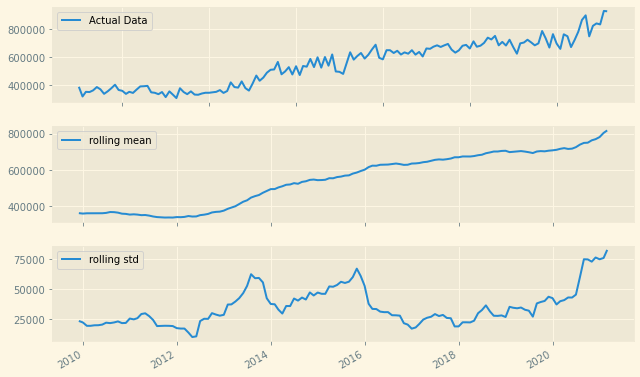

In [177]:
# Plot Rolling mean and variance

plot_rolling(df_aft_crisis_nap)

In [178]:
# Plot decompose charts

decomp_plot(df_aft_crisis_nap)

In [179]:
adfuller_test(df_aft_crisis_nap)


 > Is the data stationary ?

Test statistic = 0.922
P-value = 0.993
#Lag used = 5
Number of observations = 141
Critical values :
	1%: -3.478 - The data is not stationary with 99% confidence
	5%: -2.882 - The data is not stationary with 95% confidence
	10%: -2.578 - The data is not stationary with 90% confidence


In [180]:
# Create Napa Logarithmic Column

df_aft_crisis_nap['Napa (Log)'] = df_aft_crisis_nap['Napa'].apply(lambda x : np.log(x))

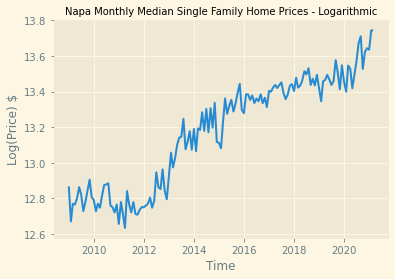

In [181]:
# Plot Log(Df) Dataset

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_aft_crisis_nap['Napa (Log)'])
plt.title('Napa Monthly Median Single Family Home Prices - Logarithmic', fontdict={'fontsize':10}) 
plt.ylabel('Log(Price) $')
plt.xlabel('Time')
plt.show()

In [182]:
# Differencing order 1

df_aft_crisis_nap['Diff Lag 1 Ord 1'] = np.NaN
df_aft_crisis_nap['Diff Lag 1 Ord 1'].iloc[1:] = np.diff(df_aft_crisis_nap['Napa (Log)'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_nap[['Diff Lag 1 Ord 1']])

ADF Statistic: -8.066618007755956
p-value: 1.5899675227785187e-12
Critical Values:
	1%: -3.4776006742422374
	5%: -2.882265832283648
	10%: -2.5778219289774156


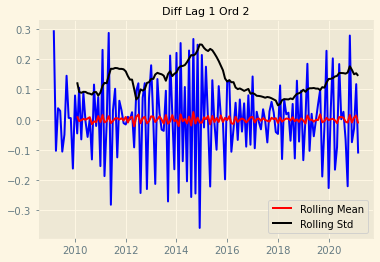

ADF Statistic: -6.863509859540812
p-value: 1.5803806636717097e-09
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


In [183]:
# Differencing order 2

df_aft_crisis_nap['Diff Lag 1 Ord 2'] = np.NaN
df_aft_crisis_nap['Diff Lag 1 Ord 2'].iloc[1:] = np.diff(df_aft_crisis_nap['Diff Lag 1 Ord 1'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_nap[['Diff Lag 1 Ord 2']])

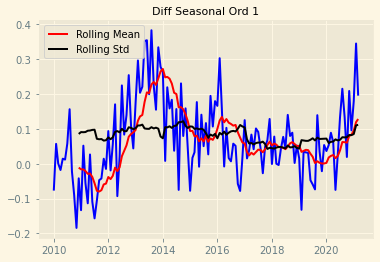

ADF Statistic: -3.081511946018725
p-value: 0.027951986688040758
Critical Values:
	1%: -3.4846672514209773
	5%: -2.8853397507076006
	10%: -2.5794629869786503


In [184]:
# Differencing Seasonal order 1 

df_aft_crisis_nap['Diff Seasonal Ord 1'] = np.NaN
df_aft_crisis_nap['Diff Seasonal Ord 1'].iloc[12:] = diff(df_aft_crisis_nap['Napa (Log)'],interval =12)

# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_nap[['Diff Seasonal Ord 1']])

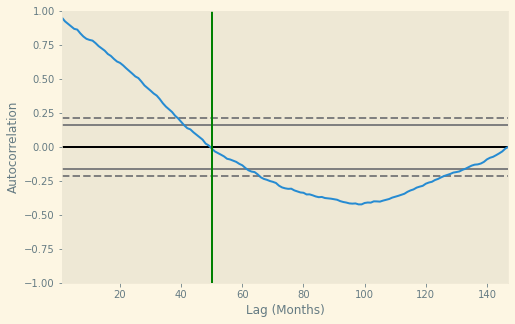

In [185]:
# Seasonality or Noise ?

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_nap['Napa (Log)'])
plt.axvline(50, color='green')
plt.xlabel('Lag (Months)')
plt.show()

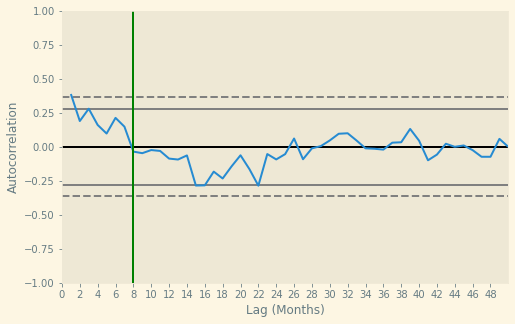

In [186]:
# Noise 

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_nap['Napa (Log)'][:50])
plt.xlabel('Lag (Months)')
plt.xticks(np.arange(0, 50, step=2))
plt.axvline(8, color='green')
plt.show()

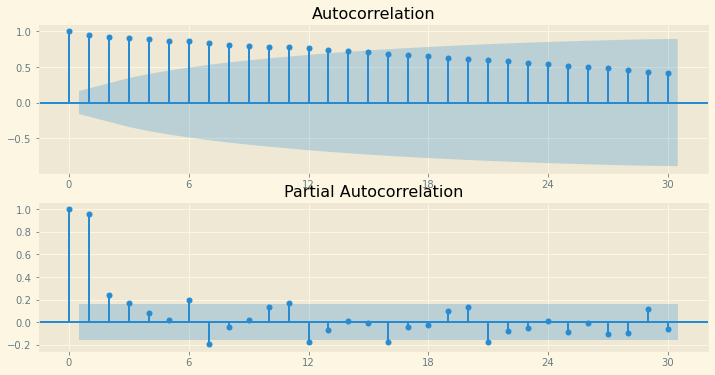

In [187]:
acf_pacf_plot(df_aft_crisis_nap['Napa (Log)'])

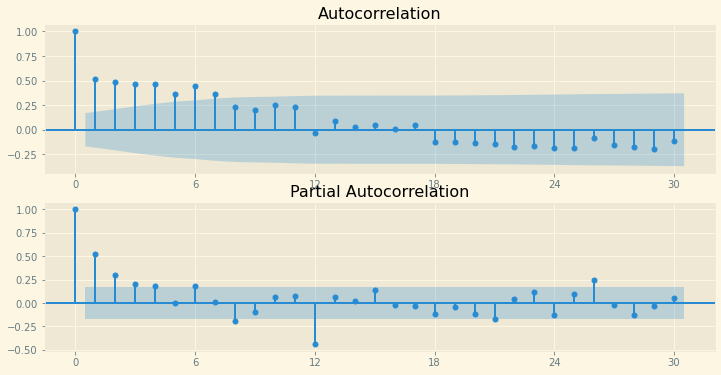

In [188]:
acf_pacf_plot(df_aft_crisis_nap['Diff Seasonal Ord 1'])

Based on ACF and PACF figures, the possible appropriate values for p and q: 

    p : 1 , 2 , 4 
    
    q : 1 , 2 , 6 , 12
    
The best combination of parameters can be achived through grid search step. 

keep in mind that I do differencing (I part in ARIMA), manually in my model, therfore in ARIMA class I am going to use 0 as *I*. 

In [189]:
# Split the dataset into train and valid datasets 

df_aft_crisis_nap_train = df_aft_crisis_nap[df_aft_crisis_nap.index.year < 2018].dropna(how='all')
df_aft_crisis_nap_valid = df_aft_crisis_nap[df_aft_crisis_nap.index.year >= 2018].dropna(how='all')

In [190]:
# Get the shape of training and valdation dataset 
print('df train after crisis Shape', df_aft_crisis_nap_train.shape)
print('df valid after crisis Shape', df_aft_crisis_nap_valid.shape)

df train after crisis Shape (108, 5)
df valid after crisis Shape (39, 5)


In [191]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_model_ARIMA(arima_order):
    
    
    history_nap = [x for x in df_aft_crisis_nap_train['Napa (Log)']]
    predictions = list()

    for i in range(len(df_aft_crisis_nap_valid)):
    
        #difference data
            months_in_year = 12
            diff_df = diff(history_nap, months_in_year)
    
        # predict
            model = ARIMA(diff_df, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            yhat = inverse_difference(history_nap, yhat, months_in_year)
            predictions.append(yhat)
    
        # observation
            obs = df_aft_crisis_nap_valid['Napa (Log)'].iloc[i]
            history_nap.append(obs)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(df_aft_crisis_nap_valid['Napa (Log)'], predictions))
    return rmse

In [192]:
# Grid Search for ARIMA model
p_values = range(2, 5)
d_values = range(0, 2)
q_values = range(11, 13)
warnings.filterwarnings("ignore")
i_test = evaluate_models(evaluate_model_ARIMA ,p_values, d_values, q_values)

Models Parameters and Performance: Loading.....
ARIMA(2, 0, 11) RMSE=0.0788
ARIMA(2, 0, 12) RMSE=0.0739
ARIMA(3, 0, 12) RMSE=0.0735
ARIMA(3, 1, 12) RMSE=0.0729
ARIMA(4, 1, 12) RMSE=0.0726
Best: ARIMA(4, 1, 12) RMSE=0.0726


In [193]:
history_nap = [x for x in df_aft_crisis_nap_train['Napa (Log)']]
predictions = list()

for i in range(len(df_aft_crisis_nap_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_nap, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(4,1,12))
    model_fit_ARIMA = model.fit()
    yhat = model_fit_ARIMA.forecast()[0]
    yhat = inverse_difference(history_nap, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_nap_valid['Napa (Log)'].iloc[i]
    history_nap.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_nap_valid['Napa (Log)'], predictions))
print('RMSE: %.4f' % rmse)

RMSE: 0.0726


In [194]:
# Predictions and Error Columns

df_aft_crisis_nap_valid['Prediction (Log)'] = predictions 
df_aft_crisis_nap_valid['Prediction ARIMA'] = df_aft_crisis_nap_valid['Prediction (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_nap_valid['Error ARIMA'] = round(((df_aft_crisis_nap_valid['Prediction ARIMA'] - df_aft_crisis_nap_valid['Napa'])
                                                /df_aft_crisis_nap_valid['Napa']),3)

In [195]:
df_aft_crisis_nap_valid.head(3)

Napa  Napa (Log)  Diff Lag 1 Ord 1  Diff Lag 1 Ord 2  \
Time                                                                 
2018-01-01  662000   13.403021         -0.038523         -0.047282   
2018-02-01  713500   13.477938          0.074917          0.113440   
2018-03-01  675000   13.422468         -0.055470         -0.130387   

            Diff Seasonal Ord 1  Prediction (Log)  Prediction ARIMA  \
Time                                                                  
2018-01-01            -0.000755         13.420774            673857   
2018-02-01             0.077943         13.421596            674411   
2018-03-01             0.000000         13.459701            700606   

            Error ARIMA  
Time                     
2018-01-01        0.018  
2018-02-01       -0.055  
2018-03-01        0.038

In [196]:
# Plot Napa Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_nap['Napa'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_nap_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.title('ARIMA Model - Napa Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [197]:
residuals_ARIMA = [df_aft_crisis_nap_valid['Napa'].iloc[i]-df_aft_crisis_nap_valid['Prediction ARIMA'].iloc[i] for i in range(len(df_aft_crisis_nap_valid))]
residuals_ARIMA = pd.DataFrame(residuals_ARIMA)
print (residuals_ARIMA.describe([.05,.1,.25,.5,.75,.9,0.95]))
print (df_aft_crisis_nap_valid[['Error ARIMA']].describe([.05,.1,.25,.5,.75,.9,0.95]))

                   0
count      39.000000
mean     5532.461538
std     55250.298707
min   -102690.000000
5%     -78524.000000
10%    -59179.800000
25%    -29663.500000
50%      1224.000000
75%     33697.000000
90%     89980.200000
95%    116047.800000
max    128382.000000
       Error ARIMA
count    39.000000
mean     -0.002821
std       0.072805
min      -0.147000
5%       -0.132600
10%      -0.114600
25%      -0.042500
50%      -0.002000
75%       0.040500
90%       0.087200
95%       0.114700
max       0.164000


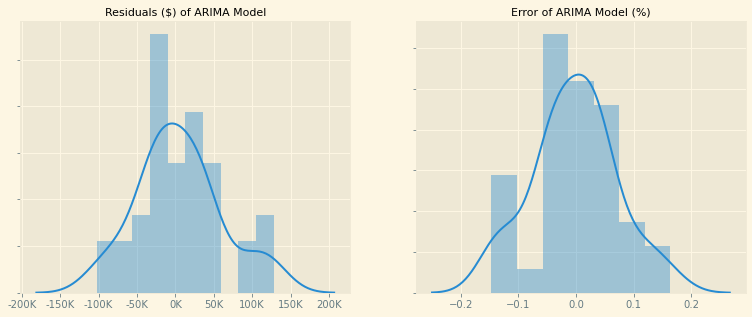

In [198]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA, ax=axes[0], bins=10, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_nap_valid['Error ARIMA'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model (%)',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

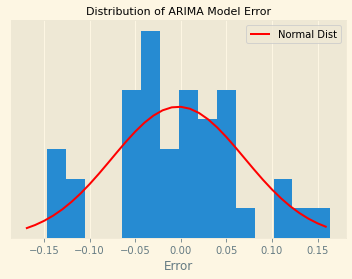

In [199]:
# 
x = np.arange(-0.17,0.17,0.01)

df_aft_crisis_nap_valid['Error ARIMA'].hist(bins=15, density=True)
plt.plot(x , sp.stats.norm(loc = df_aft_crisis_nap_valid['Error ARIMA'].mean(), 
                           scale = df_aft_crisis_nap_valid['Error ARIMA'].std()).pdf(x),
                         linewidth=2 , color='red', label = 'Normal Dist')
plt.yticks([])
plt.xlabel('Error')
plt.title('Distribution of ARIMA Model Error', fontdict={'fontsize':11})
plt.legend()
plt.show()

In [200]:
residuals_ARIMA_log = [df_aft_crisis_nap_valid['Napa (Log)'].iloc[i]-df_aft_crisis_nap_valid['Prediction (Log)'].iloc[i] 
                       for i in range(len(df_aft_crisis_nap_valid))]
residuals_ARIMA_log = pd.DataFrame(residuals_ARIMA_log)
print(residuals_ARIMA_log.describe())

               0
count  39.000000
mean    0.005418
std     0.073379
min    -0.152124
25%    -0.039860
50%     0.001727
75%     0.043681
max     0.158897


In [201]:
# Add 12 months to the end of the df_aft_crisis_bay_valid
df_future = future_data_needed(df_aft_crisis_nap_valid, pred_months=12)

In [202]:
# Make the dataset of next 12 months predictions
df_aft_crisis_nap_pred = future_pred_ARIMA(df_future, df_aft_crisis_nap_train, 
                                               ARIMA_order=(4,1,12), pred_col = 'Napa (Log)', pred_months=12)

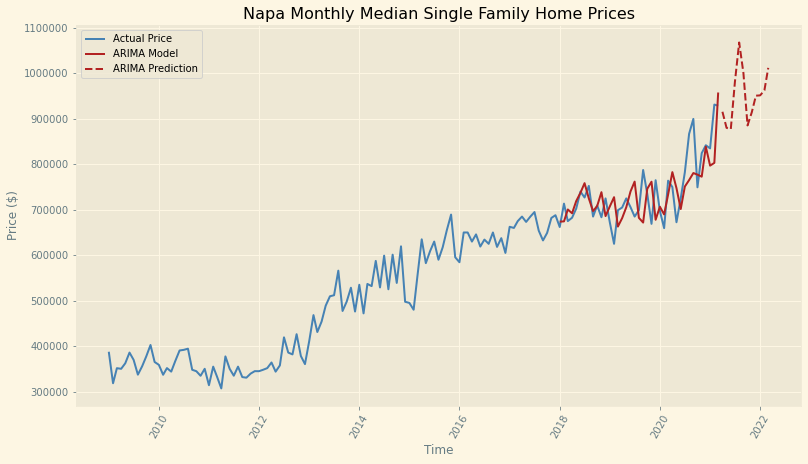

In [203]:
# Plot the Napa Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_nap['Napa'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_nap_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_nap_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction')
plt.title('Napa Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [204]:
# margin of error on predictions error

error_list = df_aft_crisis_nap_pred['Error ARIMA'].dropna()
error_list.describe([0.025,0.05,0.1,0.5,0.9,0.95,0.975])

count    39.000000
mean     -0.002821
std       0.072805
min      -0.147000
2.5%     -0.138450
5%       -0.132600
10%      -0.114600
50%      -0.002000
90%       0.087200
95%       0.114700
97.5%     0.140250
max       0.164000
Name: Error ARIMA, dtype: float64

In [205]:
print ('mean of error:', np.mean(error_list))
print ('std deviation of error:', np.std(error_list))
print ('std dev of sample:',statistics.stdev(error_list))
############# 
critical_value = 1.96
std = statistics.stdev(error_list)
sample = len(error_list)
MOE = critical_value * (std / np.sqrt(sample))
print ('margin of error:', MOE)
print ('lower:', np.mean(error_list)-MOE)
print ('highr:', np.mean(error_list)+MOE)
high_bond_rate = 1 + np.mean(error_list)+MOE
low_bond_rate = 1 + np.mean(error_list)-MOE

mean of error: -0.0028205128205128207
std deviation of error: 0.0718659263774982
std dev of sample: 0.0728053901253818
margin of error: 0.022850057707359556
lower: -0.025670570527872378
highr: 0.020029544886846735


In [206]:
# higher and lower rate comes from error distribution for 2.5% , 97.5% (95% confidence interval)

df_aft_crisis_nap_pred['lower_bond'] = (df_aft_crisis_nap_pred['Prediction ARIMA']* (1-0.1384)).astype(int)
df_aft_crisis_nap_pred['higher_bond'] = (df_aft_crisis_nap_pred['Prediction ARIMA'] * (1.1147)).astype(int)

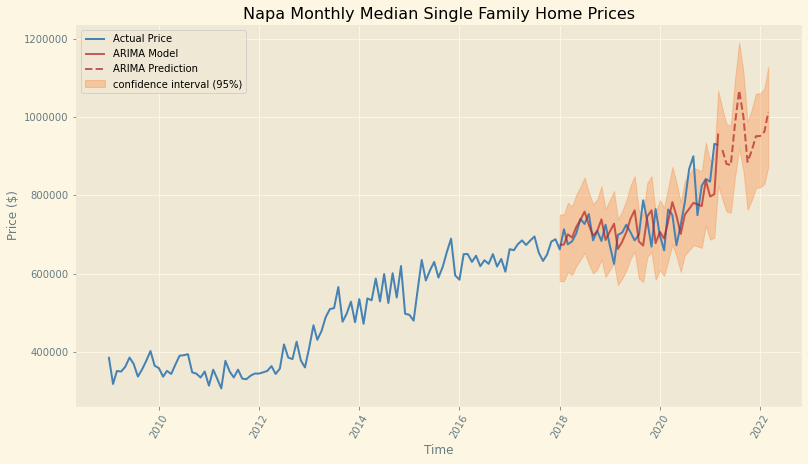

In [207]:
# Plot the Napa Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_nap['Napa'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_nap_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model', alpha=0.7)
plt.plot( df_aft_crisis_nap_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction', alpha=0.7)
ax.fill_between(df_aft_crisis_nap_pred.index, df_aft_crisis_nap_pred['lower_bond'], df_aft_crisis_nap_pred['higher_bond'], color='#ff7823', alpha=0.3, label="confidence interval (95%)");
plt.title('Napa Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [208]:
df_aft_nap_b = df_aft_crisis_nap_train[['Napa']].copy()
df_aft_nap_b = df_aft_nap_b.reset_index()
df_aft_nap_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    108 non-null    datetime64[ns]
 1   Napa    108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [209]:
df_aft_nap_p = df_aft_crisis_nap_pred[['Napa','Prediction ARIMA','lower_bond','higher_bond']].copy()
df_aft_nap_p['Prediction ARIMA'] = df_aft_nap_p['Prediction ARIMA'].astype(int)
df_aft_nap_p['Napa'] = df_aft_nap_p['Napa'].astype('float64')
df_aft_nap_p.index.names = ['Time']
df_aft_nap_p = df_aft_nap_p.reset_index()
df_aft_nap_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              51 non-null     datetime64[ns]
 1   Napa              39 non-null     float64       
 2   Prediction ARIMA  51 non-null     int64         
 3   lower_bond        51 non-null     int64         
 4   higher_bond       51 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 KB


In [210]:
df_nap = pd.concat([df_aft_nap_b, df_aft_nap_p])

In [211]:
# change the time column in order to visualize better 
df_nap['Time2'] = df_nap['Time'].dt.strftime('%b %d %Y')  # non-ISO serialization 

In [212]:
df_nap.iloc[105:115]

Time      Napa  Prediction ARIMA  lower_bond  higher_bond  \
105 2017-10-01  649000.0               NaN         NaN          NaN   
106 2017-11-01  682000.0               NaN         NaN          NaN   
107 2017-12-01  688000.0               NaN         NaN          NaN   
0   2018-01-01  662000.0          673857.0    580595.0     751148.0   
1   2018-02-01  713500.0          674411.0    581072.0     751765.0   
2   2018-03-01  675000.0          700606.0    603642.0     780965.0   
3   2018-04-01  682500.0          692233.0    596427.0     771632.0   
4   2018-05-01  702500.0          719006.0    619495.0     801475.0   
5   2018-06-01  740000.0          737358.0    635307.0     821932.0   
6   2018-07-01  727000.0          758552.0    653568.0     845557.0   

           Time2  
105  Oct 01 2017  
106  Nov 01 2017  
107  Dec 01 2017  
0    Jan 01 2018  
1    Feb 01 2018  
2    Mar 01 2018  
3    Apr 01 2018  
4    May 01 2018  
5    Jun 01 2018  
6    Jul 01 2018

In [213]:
# save df_nap for use in test2 notebook


df_nap.to_pickle('df_nap.pickle')

<br>

<font color=blue  size=20> 6 - San Francisco </font>

<br>

In [214]:
# Split San Francisco Dataset 

df_aft_crisis_sf = df_aft_crisis[['San Francisco']]

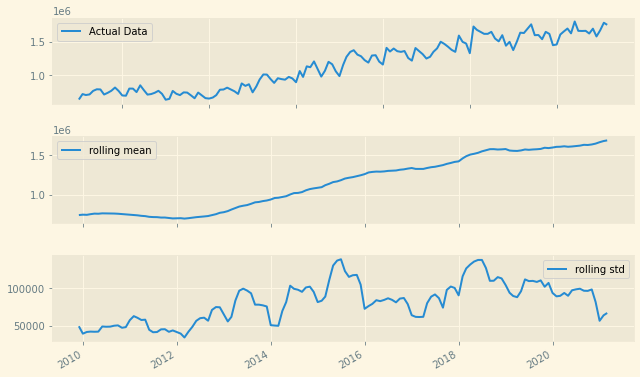

In [215]:
# Plot Rolling mean and variance

plot_rolling(df_aft_crisis_sf)

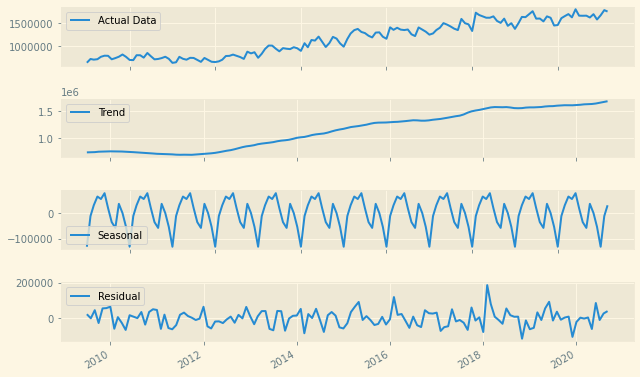

In [216]:
# Plot decompose charts

decomp_plot(df_aft_crisis_sf)

In [217]:
adfuller_test(df_aft_crisis_sf)


 > Is the data stationary ?

Test statistic = 0.090
P-value = 0.965
#Lag used = 14
Number of observations = 132
Critical values :
	1%: -3.481 - The data is not stationary with 99% confidence
	5%: -2.884 - The data is not stationary with 95% confidence
	10%: -2.579 - The data is not stationary with 90% confidence


In [218]:
# Create San Francisco Logarithmic Column

df_aft_crisis_sf['San Francisco (Log)'] = df_aft_crisis_sf['San Francisco'].apply(lambda x : np.log(x))

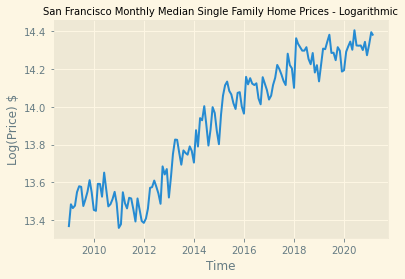

In [219]:
# Plot Log(Df) Dataset

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_aft_crisis_sf['San Francisco (Log)'])
plt.title('San Francisco Monthly Median Single Family Home Prices - Logarithmic', fontdict={'fontsize':10}) 
plt.ylabel('Log(Price) $')
plt.xlabel('Time')
plt.show()

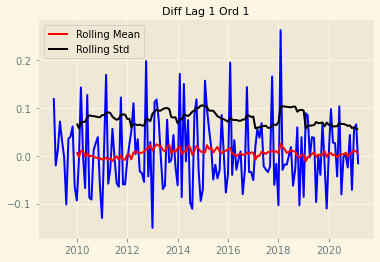

ADF Statistic: -2.2711671120926122
p-value: 0.18143580945658894
Critical Values:
	1%: -3.4808880719210005
	5%: -2.8836966192225284
	10%: -2.5785857598714417


In [220]:
# Differencing order 1

df_aft_crisis_sf['Diff Lag 1 Ord 1'] = np.NaN
df_aft_crisis_sf['Diff Lag 1 Ord 1'].iloc[1:] = np.diff(df_aft_crisis_sf['San Francisco (Log)'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_sf[['Diff Lag 1 Ord 1']])

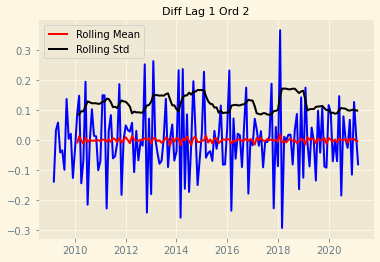

ADF Statistic: -8.375747940444807
p-value: 2.5891358299970475e-13
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [221]:
# Differencing order 2

df_aft_crisis_sf['Diff Lag 1 Ord 2'] = np.NaN
df_aft_crisis_sf['Diff Lag 1 Ord 2'].iloc[1:] = np.diff(df_aft_crisis_sf['Diff Lag 1 Ord 1'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_sf[['Diff Lag 1 Ord 2']])

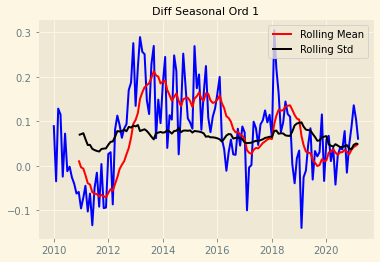

ADF Statistic: -3.113992540133708
p-value: 0.025534858799141507
Critical Values:
	1%: -3.4851223522012855
	5%: -2.88553750045158
	10%: -2.5795685622144586


In [222]:
# Differencing Seasonal order 1 

df_aft_crisis_sf['Diff Seasonal Ord 1'] = np.NaN
df_aft_crisis_sf['Diff Seasonal Ord 1'].iloc[12:] = diff(df_aft_crisis_sf['San Francisco (Log)'],interval =12)

# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_sf[['Diff Seasonal Ord 1']])

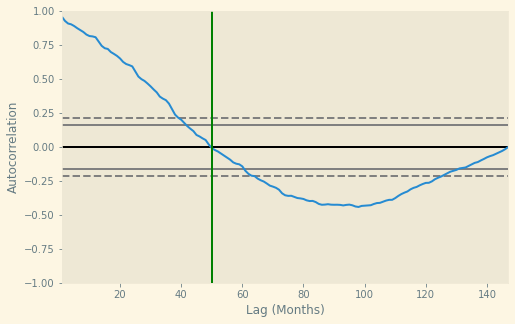

In [223]:
# Seasonality or Noise ?

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_sf['San Francisco (Log)'])
plt.axvline(50, color='green')
plt.xlabel('Lag (Months)')
plt.show()

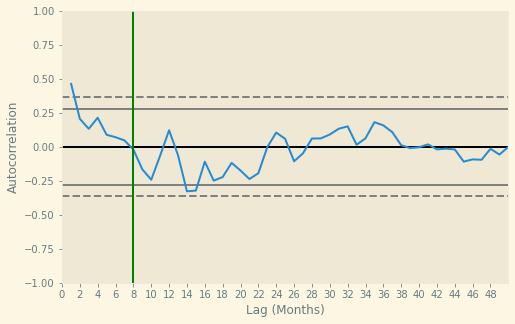

In [224]:
# Noise 

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_sf['San Francisco (Log)'][:50])
plt.xlabel('Lag (Months)')
plt.xticks(np.arange(0, 50, step=2))
plt.axvline(8, color='green')
plt.show()

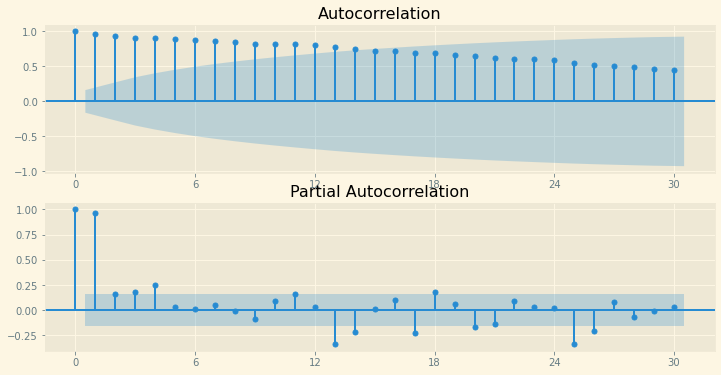

In [225]:
acf_pacf_plot(df_aft_crisis_sf['San Francisco (Log)'])

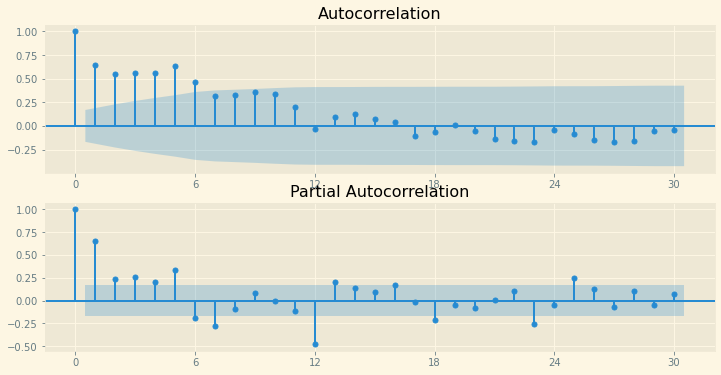

In [226]:
acf_pacf_plot(df_aft_crisis_sf['Diff Seasonal Ord 1'])

Based on ACF and PACF figures, the possible appropriate values for p and q: 

    p : 1 , 2 , 4 
    
    q : 1 , 5 , 7 , 12
    
The best combination of parameters can be achived through grid search step. 

keep in mind that I do differencing (I part in ARIMA), manually in my model, therfore in ARIMA class I am going to use 0 as *I*. 

In [227]:
# Split the dataset into train and valid datasets 

df_aft_crisis_sf_train = df_aft_crisis_sf[df_aft_crisis_sf.index.year < 2018].dropna(how='all')
df_aft_crisis_sf_valid = df_aft_crisis_sf[df_aft_crisis_sf.index.year >= 2018].dropna(how='all')

In [228]:
# Get the shape of training and valdation dataset 
print('df train after crisis Shape', df_aft_crisis_sf_train.shape)
print('df valid after crisis Shape', df_aft_crisis_sf_valid.shape)

df train after crisis Shape (108, 5)
df valid after crisis Shape (39, 5)


In [229]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_model_ARIMA(arima_order):
    
    
    history_sf = [x for x in df_aft_crisis_sf_train['San Francisco (Log)']]
    predictions = list()

    for i in range(len(df_aft_crisis_sf_valid)):
    
        #difference data
            months_in_year = 12
            diff_df = diff(history_sf, months_in_year)
    
        # predict
            model = ARIMA(diff_df, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            yhat = inverse_difference(history_sf, yhat, months_in_year)
            predictions.append(yhat)
    
        # observation
            obs = df_aft_crisis_sf_valid['San Francisco (Log)'].iloc[i]
            history_sf.append(obs)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(df_aft_crisis_sf_valid['San Francisco (Log)'], predictions))
    return rmse

In [230]:
# Grid Search for ARIMA model
p_values = range(2, 5)
d_values = range(0, 2)
q_values = range(11, 13)
warnings.filterwarnings("ignore")
i_test = evaluate_models(evaluate_model_ARIMA ,p_values, d_values, q_values)

Models Parameters and Performance: Loading.....
ARIMA(2, 0, 11) RMSE=0.0542
ARIMA(2, 0, 12) RMSE=0.0512
Best: ARIMA(2, 0, 12) RMSE=0.0512


In [231]:
history_sf = [x for x in df_aft_crisis_sf_train['San Francisco (Log)']]
predictions = list()

for i in range(len(df_aft_crisis_sf_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_sf, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(2,0,12))
    model_fit_ARIMA = model.fit()
    yhat = model_fit_ARIMA.forecast()[0]
    yhat = inverse_difference(history_sf, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_sf_valid['San Francisco (Log)'].iloc[i]
    history_sf.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_sf_valid['San Francisco (Log)'], predictions))
print('RMSE: %.4f' % rmse)

RMSE: 0.0512


In [232]:
# Predictions and Error Columns

df_aft_crisis_sf_valid['Prediction (Log)'] = predictions 
df_aft_crisis_sf_valid['Prediction ARIMA'] = df_aft_crisis_sf_valid['Prediction (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_sf_valid['Error ARIMA'] = round(((df_aft_crisis_sf_valid['Prediction ARIMA'] - df_aft_crisis_sf_valid['San Francisco'])
                                                /df_aft_crisis_sf_valid['San Francisco']),3)

In [233]:
df_aft_crisis_sf_valid.head(3)

San Francisco  San Francisco (Log)  Diff Lag 1 Ord 1  \
Time                                                               
2018-01-01        1330000            14.100690         -0.103479   
2018-02-01        1730000            14.363632          0.262942   
2018-03-01        1680000            14.334304         -0.029328   

            Diff Lag 1 Ord 2  Diff Seasonal Ord 1  Prediction (Log)  \
Time                                                                  
2018-01-01         -0.086672             0.062035         14.125131   
2018-02-01          0.366422             0.304391         14.240729   
2018-03-01         -0.292270             0.218689         14.319495   

            Prediction ARIMA  Error ARIMA  
Time                                       
2018-01-01           1362907        0.025  
2018-02-01           1529925       -0.116  
2018-03-01           1655304       -0.015

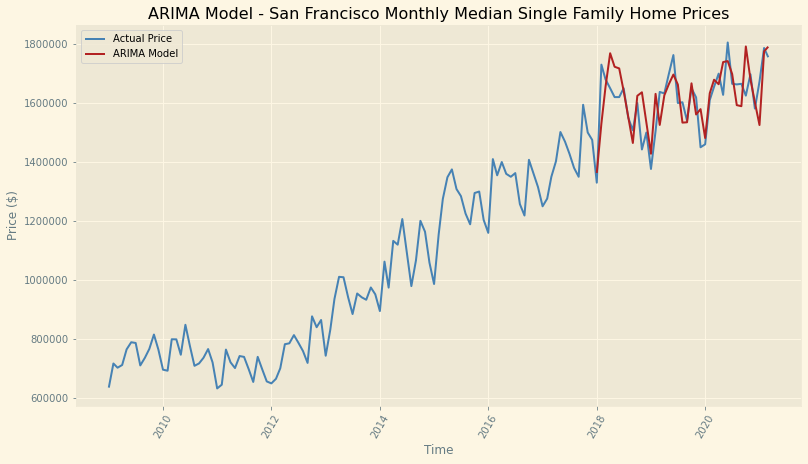

In [234]:
# Plot the San Francisco Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_sf['San Francisco'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_sf_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.title('ARIMA Model - San Francisco Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [235]:
residuals_ARIMA = [df_aft_crisis_sf_valid['San Francisco'].iloc[i]-df_aft_crisis_sf_valid['Prediction ARIMA'].iloc[i] for i in range(len(df_aft_crisis_sf_valid))]
residuals_ARIMA = pd.DataFrame(residuals_ARIMA)
print (residuals_ARIMA.describe([.05,.1,.25,.5,.75,.9,0.95]))
print (df_aft_crisis_sf_valid[['Error ARIMA']].describe([.05,.1,.25,.5,.75,.9,0.95]))

                   0
count      39.000000
mean    -9736.076923
std     82943.044771
min   -193768.000000
5%    -132919.600000
10%   -120058.400000
25%    -43625.500000
50%    -16599.000000
75%     39417.000000
90%     71403.400000
95%    115435.900000
max    200075.000000
       Error ARIMA
count    39.000000
mean      0.007538
std       0.051784
min      -0.116000
5%       -0.070000
10%      -0.043600
25%      -0.024500
50%       0.010000
75%       0.031000
90%       0.074400
95%       0.090300
max       0.134000


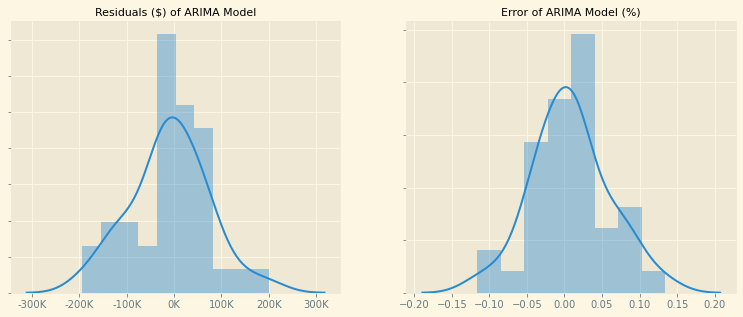

In [236]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA, ax=axes[0], bins=10, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_sf_valid['Error ARIMA'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model (%)',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

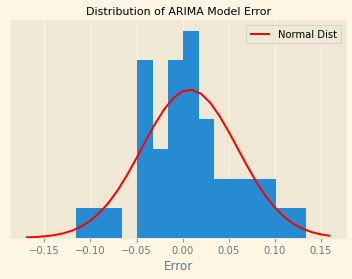

In [237]:
# 
x = np.arange(-0.17,0.17,0.01)

df_aft_crisis_sf_valid['Error ARIMA'].hist(bins=15, density=True)
plt.plot(x , sp.stats.norm(loc = df_aft_crisis_sf_valid['Error ARIMA'].mean(), 
                           scale = df_aft_crisis_sf_valid['Error ARIMA'].std()).pdf(x),
                         linewidth=2 , color='red', label = 'Normal Dist')
plt.yticks([])
plt.xlabel('Error')
plt.title('Distribution of ARIMA Model Error', fontdict={'fontsize':11})
plt.legend()
plt.show()

In [238]:
residuals_ARIMA_log = [df_aft_crisis_sf_valid['San Francisco (Log)'].iloc[i]-df_aft_crisis_sf_valid['Prediction (Log)'].iloc[i] 
                       for i in range(len(df_aft_crisis_sf_valid))]
residuals_ARIMA_log = pd.DataFrame(residuals_ARIMA_log)
print(residuals_ARIMA_log.describe())

               0
count  39.000000
mean   -0.006280
std     0.051438
min    -0.126040
25%    -0.030584
50%    -0.010010
75%     0.025120
max     0.122903


In [239]:
# Add 12 months to the end of the df_aft_crisis_bay_valid
df_future = future_data_needed(df_aft_crisis_sf_valid, pred_months=12)

In [240]:
# Make the dataset of next 12 months predictions
df_aft_crisis_sf_pred = future_pred_ARIMA(df_future, df_aft_crisis_sf_train, 
                                               ARIMA_order=(2,0,12), pred_col = 'San Francisco (Log)', pred_months=12)

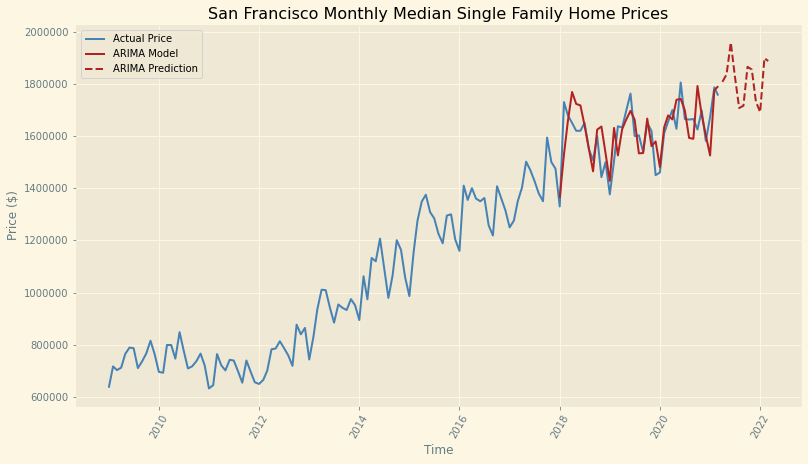

In [241]:
# Plot the San Francisco Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_sf['San Francisco'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_sf_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_sf_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction')
plt.title('San Francisco Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [242]:
# margin of error on predictions error

error_list = df_aft_crisis_sf_pred['Error ARIMA'].dropna()
error_list.describe([0.025,0.05,0.1,0.5,0.9,0.95,0.975])

count    39.000000
mean      0.007538
std       0.051784
min      -0.116000
2.5%     -0.089400
5%       -0.070000
10%      -0.043600
50%       0.010000
90%       0.074400
95%       0.090300
97.5%     0.103600
max       0.134000
Name: Error ARIMA, dtype: float64

In [243]:
print ('mean of error:', np.mean(error_list))
print ('std deviation of error:', np.std(error_list))
print ('std dev of sample:',statistics.stdev(error_list))
############# 
critical_value = 1.96
std = statistics.stdev(error_list)
sample = len(error_list)
MOE = critical_value * (std / np.sqrt(sample))
print ('margin of error:', MOE)
print ('lower:', np.mean(error_list)-MOE)
print ('highr:', np.mean(error_list)+MOE)
high_bond_rate = 1 + np.mean(error_list)+MOE
low_bond_rate = 1 + np.mean(error_list)-MOE

mean of error: 0.0075384615384615425
std deviation of error: 0.05111618046495106
std dev of sample: 0.051784394191506926
margin of error: 0.016252593298089726
lower: -0.008714131759628183
highr: 0.023791054836551268


In [244]:
# higher and lower rate comes from error distribution for 2.5% , 97.5% (95% confidence interval)

df_aft_crisis_sf_pred['lower_bond'] = (df_aft_crisis_sf_pred['Prediction ARIMA']* (1-0.0894)).astype(int)
df_aft_crisis_sf_pred['higher_bond'] = (df_aft_crisis_sf_pred['Prediction ARIMA'] * (1.1036)).astype(int)

In [245]:
# Plot the San Francisco Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_sf['San Francisco'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_sf_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model', alpha=0.7)
plt.plot( df_aft_crisis_sf_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction', alpha=0.7)
ax.fill_between(df_aft_crisis_sf_pred.index, df_aft_crisis_sf_pred['lower_bond'], df_aft_crisis_sf_pred['higher_bond'], color='#ff7823', alpha=0.3, label="confidence interval (95%)");
plt.title('San Francisco Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [246]:
df_aft_sf_b = df_aft_crisis_sf_train[['San Francisco']].copy()
df_aft_sf_b = df_aft_sf_b.reset_index()
df_aft_sf_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           108 non-null    datetime64[ns]
 1   San Francisco  108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [247]:
df_aft_sf_p = df_aft_crisis_sf_pred[['San Francisco','Prediction ARIMA','lower_bond','higher_bond']].copy()
df_aft_sf_p['Prediction ARIMA'] = df_aft_sf_p['Prediction ARIMA'].astype(int)
df_aft_sf_p['San Francisco'] = df_aft_sf_p['San Francisco'].astype('float64')
df_aft_sf_p.index.names = ['Time']
df_aft_sf_p = df_aft_sf_p.reset_index()
df_aft_sf_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              51 non-null     datetime64[ns]
 1   San Francisco     39 non-null     float64       
 2   Prediction ARIMA  51 non-null     int64         
 3   lower_bond        51 non-null     int64         
 4   higher_bond       51 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 KB


In [248]:
df_sf = pd.concat([df_aft_sf_b, df_aft_sf_p])

In [249]:
# change the time column in order to visualize better 
df_sf['Time2'] = df_sf['Time'].dt.strftime('%b %d %Y')  # non-ISO serialization 

In [250]:
df_sf.iloc[105:115]

Time  San Francisco  Prediction ARIMA  lower_bond  higher_bond  \
105 2017-10-01      1594000.0               NaN         NaN          NaN   
106 2017-11-01      1500000.0               NaN         NaN          NaN   
107 2017-12-01      1475000.0               NaN         NaN          NaN   
0   2018-01-01      1330000.0         1362907.0   1241063.0    1504104.0   
1   2018-02-01      1730000.0         1529925.0   1393149.0    1688425.0   
2   2018-03-01      1680000.0         1655304.0   1507319.0    1826793.0   
3   2018-04-01      1650000.0         1768587.0   1610475.0    1951812.0   
4   2018-05-01      1620000.0         1722810.0   1568790.0    1901293.0   
5   2018-06-01      1620000.0         1717144.0   1563631.0    1895040.0   
6   2018-07-01      1650000.0         1640798.0   1494110.0    1810784.0   

           Time2  
105  Oct 01 2017  
106  Nov 01 2017  
107  Dec 01 2017  
0    Jan 01 2018  
1    Feb 01 2018  
2    Mar 01 2018  
3    Apr 01 2018  
4    May 01 2018  
5    Jun 01 2018  
6    Jul 01 2018

In [251]:
# save df_sf for use in test2 notebook


df_sf.to_pickle('df_sf.pickle')

<br>

<font color=blue  size=20> 7 - San Mateo </font>

<br>

In [252]:
# Split San Mateo Dataset 

df_aft_crisis_smt = df_aft_crisis[['San Mateo']]

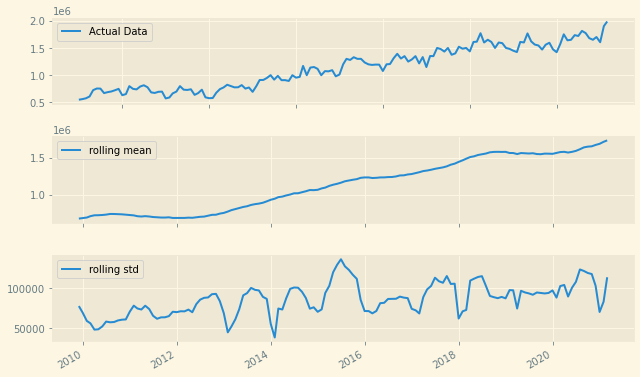

In [253]:
# Plot Rolling mean and variance

plot_rolling(df_aft_crisis_smt)

In [254]:
# Plot decompose charts

decomp_plot(df_aft_crisis_smt)

In [255]:
adfuller_test(df_aft_crisis_smt)


 > Is the data stationary ?

Test statistic = 0.746
P-value = 0.991
#Lag used = 14
Number of observations = 132
Critical values :
	1%: -3.481 - The data is not stationary with 99% confidence
	5%: -2.884 - The data is not stationary with 95% confidence
	10%: -2.579 - The data is not stationary with 90% confidence


In [256]:
# Create San Francisco Logarithmic Column

df_aft_crisis_smt['San Mateo (Log)'] = df_aft_crisis_smt['San Mateo'].apply(lambda x : np.log(x))

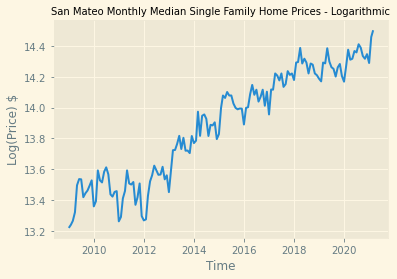

In [257]:
# Plot Log(Df) Dataset

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_aft_crisis_smt['San Mateo (Log)'])
plt.title('San Mateo Monthly Median Single Family Home Prices - Logarithmic', fontdict={'fontsize':10}) 
plt.ylabel('Log(Price) $')
plt.xlabel('Time')
plt.show()

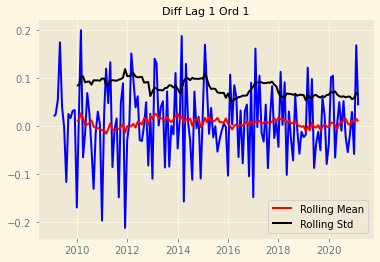

ADF Statistic: -2.691140608877183
p-value: 0.07558391758685562
Critical Values:
	1%: -3.4808880719210005
	5%: -2.8836966192225284
	10%: -2.5785857598714417


In [258]:
# Differencing order 1

df_aft_crisis_smt['Diff Lag 1 Ord 1'] = np.NaN
df_aft_crisis_smt['Diff Lag 1 Ord 1'].iloc[1:] = np.diff(df_aft_crisis_smt['San Mateo (Log)'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_smt[['Diff Lag 1 Ord 1']])

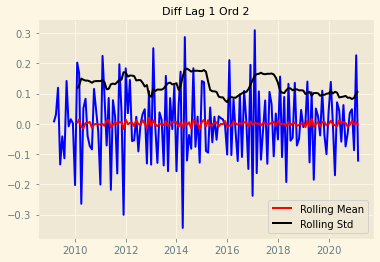

ADF Statistic: -8.233880634281254
p-value: 5.961770324619511e-13
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


In [259]:
# Differencing order 2

df_aft_crisis_smt['Diff Lag 1 Ord 2'] = np.NaN
df_aft_crisis_smt['Diff Lag 1 Ord 2'].iloc[1:] = np.diff(df_aft_crisis_smt['Diff Lag 1 Ord 1'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_smt[['Diff Lag 1 Ord 2']])

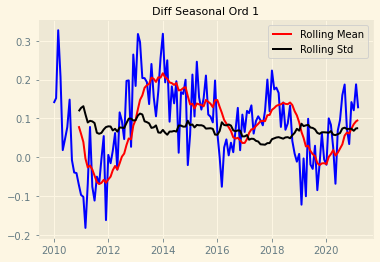

ADF Statistic: -2.9252412581002822
p-value: 0.04249053442897143
Critical Values:
	1%: -3.4851223522012855
	5%: -2.88553750045158
	10%: -2.5795685622144586


In [260]:
# Differencing Seasonal order 1 

df_aft_crisis_smt['Diff Seasonal Ord 1'] = np.NaN
df_aft_crisis_smt['Diff Seasonal Ord 1'].iloc[12:] = diff(df_aft_crisis_smt['San Mateo (Log)'],interval =12)

# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_smt[['Diff Seasonal Ord 1']])

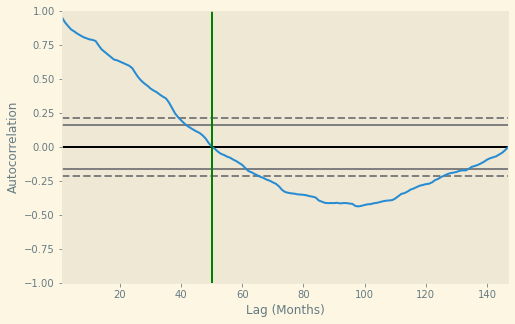

In [261]:
# Seasonality or Noise ?

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_smt['San Mateo (Log)'])
plt.axvline(50, color='green')
plt.xlabel('Lag (Months)')
plt.show()

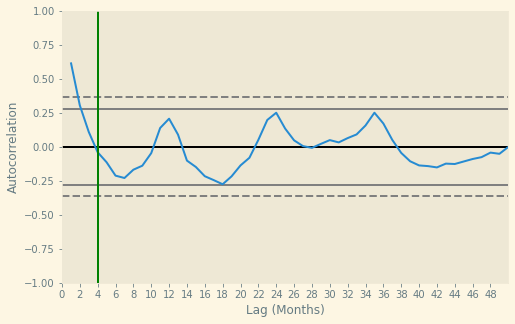

In [262]:
# Noise 

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_smt['San Mateo (Log)'][:50])
plt.xlabel('Lag (Months)')
plt.xticks(np.arange(0, 50, step=2))
plt.axvline(4, color='green')
plt.show()

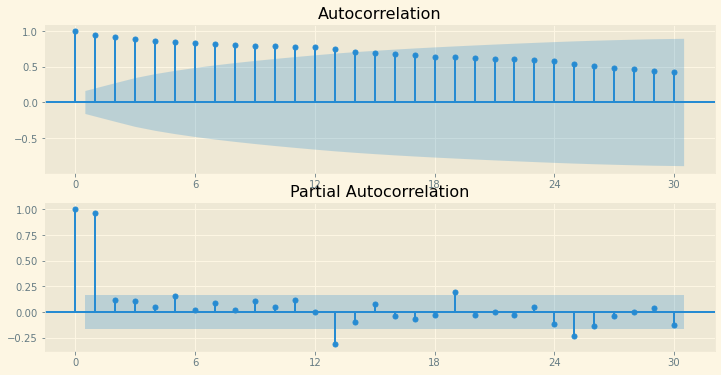

In [263]:
acf_pacf_plot(df_aft_crisis_smt['San Mateo (Log)'])

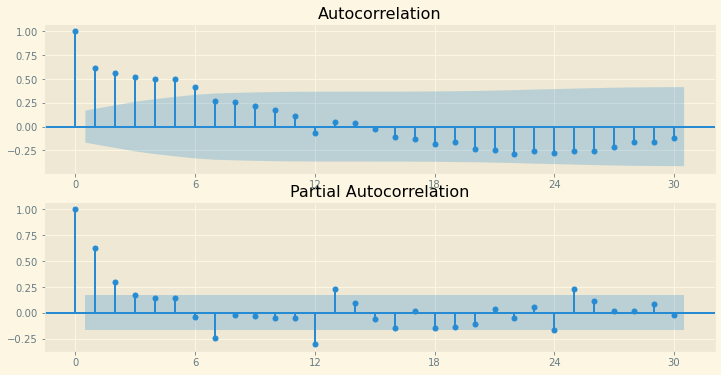

In [264]:
acf_pacf_plot(df_aft_crisis_smt['Diff Seasonal Ord 1'])

Based on ACF and PACF figures, the possible appropriate values for p and q: 

    p : 1 , 2 , 6 , 12 
    
    q : 1 ,6 , 12
    
The best combination of parameters can be achived through grid search step. 

keep in mind that I do differencing (I part in ARIMA), manually in my model, therfore in ARIMA class I am going to use 0 as *I*. 

In [265]:
# Split the dataset into train and valid datasets 

df_aft_crisis_smt_train = df_aft_crisis_smt[df_aft_crisis_smt.index.year < 2018].dropna(how='all')
df_aft_crisis_smt_valid = df_aft_crisis_smt[df_aft_crisis_smt.index.year >= 2018].dropna(how='all')

In [266]:
# Get the shape of training and valdation dataset 
print('df train after crisis Shape', df_aft_crisis_smt_train.shape)
print('df valid after crisis Shape', df_aft_crisis_smt_valid.shape)

df train after crisis Shape (108, 5)
df valid after crisis Shape (39, 5)


In [267]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_model_ARIMA(arima_order):
    
    
    history_smt = [x for x in df_aft_crisis_smt_train['San Mateo (Log)']]
    predictions = list()

    for i in range(len(df_aft_crisis_smt_valid)):
    
        #difference data
            months_in_year = 12
            diff_df = diff(history_smt, months_in_year)
    
        # predict
            model = ARIMA(diff_df, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            yhat = inverse_difference(history_smt, yhat, months_in_year)
            predictions.append(yhat)
    
        # observation
            obs = df_aft_crisis_smt_valid['San Mateo (Log)'].iloc[i]
            history_smt.append(obs)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(df_aft_crisis_smt_valid['San Mateo (Log)'], predictions))
    return rmse

In [268]:
# Grid Search for ARIMA model
p_values = range(2, 5)
d_values = range(0, 2)
q_values = range(11, 13)
warnings.filterwarnings("ignore")
i_test = evaluate_models(evaluate_model_ARIMA ,p_values, d_values, q_values)

Models Parameters and Performance: Loading.....
ARIMA(2, 0, 11) RMSE=0.0691
ARIMA(2, 0, 12) RMSE=0.0564
ARIMA(2, 1, 12) RMSE=0.0558
ARIMA(3, 0, 12) RMSE=0.0556
Best: ARIMA(3, 0, 12) RMSE=0.0556


In [269]:
history_smt = [x for x in df_aft_crisis_smt_train['San Mateo (Log)']]
predictions = list()

for i in range(len(df_aft_crisis_smt_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_smt, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(3,0,12))
    model_fit_ARIMA = model.fit()
    yhat = model_fit_ARIMA.forecast()[0]
    yhat = inverse_difference(history_smt, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_smt_valid['San Mateo (Log)'].iloc[i]
    history_smt.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_smt_valid['San Mateo (Log)'], predictions))
print('RMSE: %.4f' % rmse)

RMSE: 0.0556


In [270]:
# Predictions and Error Columns

df_aft_crisis_smt_valid['Prediction (Log)'] = predictions 
df_aft_crisis_smt_valid['Prediction ARIMA'] = df_aft_crisis_smt_valid['Prediction (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_smt_valid['Error ARIMA'] = round(((df_aft_crisis_smt_valid['Prediction ARIMA'] - df_aft_crisis_smt_valid['San Mateo'])
                                                /df_aft_crisis_smt_valid['San Mateo']),3)

In [271]:
df_aft_crisis_smt_valid.head(3)

San Mateo  San Mateo (Log)  Diff Lag 1 Ord 1  Diff Lag 1 Ord 2  \
Time                                                                         
2018-01-01  1437500.0        14.178416         -0.042560         -0.051937   
2018-02-01  1610000.0        14.291745          0.113329          0.155888   
2018-03-01  1615000.0        14.294846          0.003101         -0.110228   

            Diff Seasonal Ord 1  Prediction (Log)  Prediction ARIMA  \
Time                                                                  
2018-01-01             0.223144         14.117790           1352939   
2018-02-01             0.174649         14.248393           1541694   
2018-03-01             0.179230         14.371791           1744172   

            Error ARIMA  
Time                     
2018-01-01       -0.059  
2018-02-01       -0.042  
2018-03-01        0.080

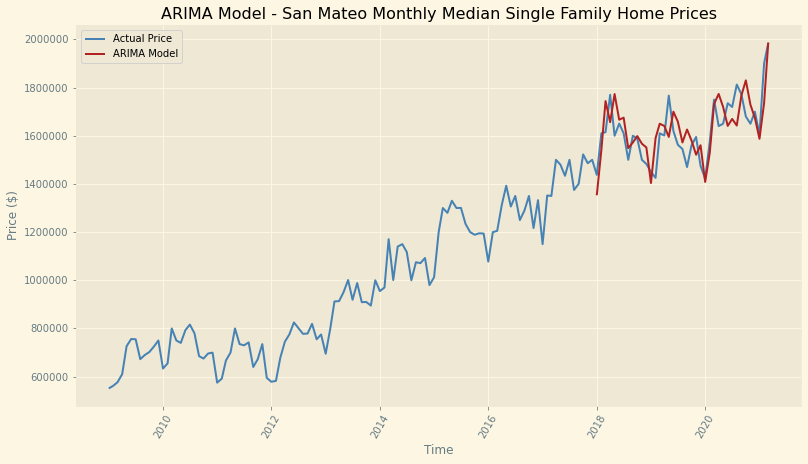

In [272]:
# Plot the San Mateo Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_smt['San Mateo'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_smt_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.title('ARIMA Model - San Mateo Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [273]:
residuals_ARIMA = [df_aft_crisis_smt_valid['San Mateo'].iloc[i]-df_aft_crisis_smt_valid['Prediction ARIMA'].iloc[i] for i in range(len(df_aft_crisis_smt_valid))]
residuals_ARIMA = pd.DataFrame(residuals_ARIMA)
print (residuals_ARIMA.describe([.05,.1,.25,.5,.75,.9,0.95]))
print (df_aft_crisis_smt_valid[['Error ARIMA']].describe([.05,.1,.25,.5,.75,.9,0.95]))

                   0
count      39.000000
mean   -13616.435897
std     91663.843848
min   -173145.000000
5%    -156858.200000
10%   -136893.600000
25%    -74128.500000
50%    -16032.000000
75%     46081.000000
90%     98119.400000
95%    164781.900000
max    171339.000000
       Error ARIMA
count    39.000000
mean      0.010308
std       0.055967
min      -0.097000
5%       -0.086800
10%      -0.060000
25%      -0.029000
50%       0.010000
75%       0.047000
90%       0.082600
95%       0.106200
max       0.116000


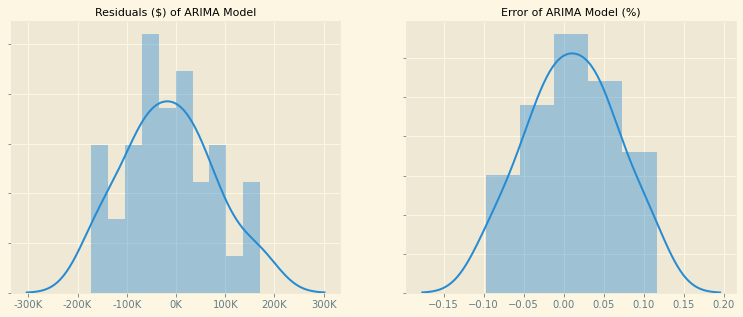

In [274]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA, ax=axes[0], bins=10, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_smt_valid['Error ARIMA'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model (%)',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

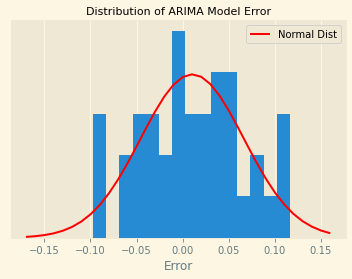

In [275]:
# 
x = np.arange(-0.17,0.17,0.01)

df_aft_crisis_smt_valid['Error ARIMA'].hist(bins=15, density=True)
plt.plot(x , sp.stats.norm(loc = df_aft_crisis_smt_valid['Error ARIMA'].mean(), 
                           scale = df_aft_crisis_smt_valid['Error ARIMA'].std()).pdf(x),
                         linewidth=2 , color='red', label = 'Normal Dist')
plt.yticks([])
plt.xlabel('Error')
plt.title('Distribution of ARIMA Model Error', fontdict={'fontsize':11})
plt.legend()
plt.show()

In [276]:
residuals_ARIMA_log = [df_aft_crisis_smt_valid['San Mateo (Log)'].iloc[i]-df_aft_crisis_smt_valid['Prediction (Log)'].iloc[i] 
                       for i in range(len(df_aft_crisis_smt_valid))]
residuals_ARIMA_log = pd.DataFrame(residuals_ARIMA_log)
print(residuals_ARIMA_log.describe())

               0
count  39.000000
mean   -0.008722
std     0.055668
min    -0.109832
25%    -0.045851
50%    -0.009667
75%     0.029445
max     0.102025


In [277]:
# Add 12 months to the end of the df_aft_crisis_bay_valid
df_future = future_data_needed(df_aft_crisis_smt_valid, pred_months=12)

In [278]:
# Make the dataset of next 12 months predictions
df_aft_crisis_smt_pred = future_pred_ARIMA(df_future, df_aft_crisis_smt_train, 
                                               ARIMA_order=(3,0,12), pred_col = 'San Mateo (Log)', pred_months=12)

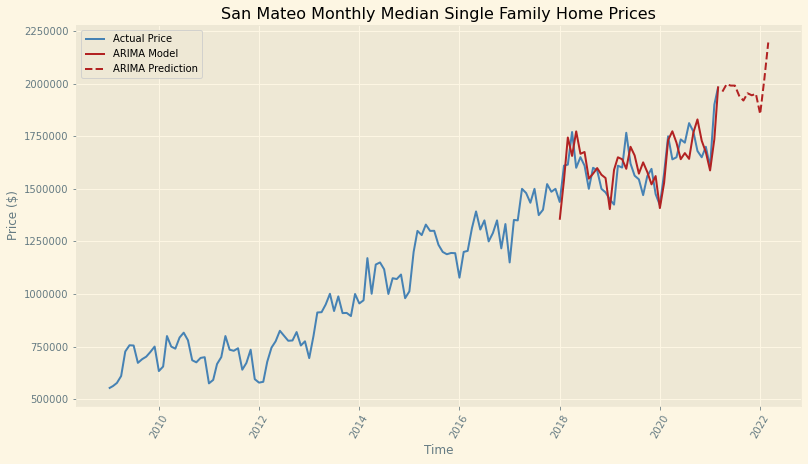

In [279]:
# Plot the San Mateo Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_smt['San Mateo'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_smt_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_smt_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction')
plt.title('San Mateo Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [280]:
# margin of error on predictions error

error_list = df_aft_crisis_smt_pred['Error ARIMA'].dropna()
error_list.describe([0.025,0.05,0.1,0.5,0.9,0.95,0.975])

count    39.000000
mean      0.010308
std       0.055967
min      -0.097000
2.5%     -0.094150
5%       -0.086800
10%      -0.060000
50%       0.010000
90%       0.082600
95%       0.106200
97.5%     0.108400
max       0.116000
Name: Error ARIMA, dtype: float64

In [281]:
print ('mean of error:', np.mean(error_list))
print ('std deviation of error:', np.std(error_list))
print ('std dev of sample:',statistics.stdev(error_list))
############# 
critical_value = 1.96
std = statistics.stdev(error_list)
sample = len(error_list)
MOE = critical_value * (std / np.sqrt(sample))
print ('margin of error:', MOE)
print ('lower:', np.mean(error_list)-MOE)
print ('highr:', np.mean(error_list)+MOE)
high_bond_rate = 1 + np.mean(error_list)+MOE
low_bond_rate = 1 + np.mean(error_list)-MOE

mean of error: 0.010307692307692308
std deviation of error: 0.05524498067287518
std dev of sample: 0.055967167934778295
margin of error: 0.017565361779186828
lower: -0.00725766947149452
highr: 0.027873054086879137


In [282]:
# higher and lower rate comes from error distribution for 2.5% , 97.5% (95% confidence interval)

df_aft_crisis_smt_pred['lower_bond'] = (df_aft_crisis_smt_pred['Prediction ARIMA']* (1-0.0941)).astype(int)
df_aft_crisis_smt_pred['higher_bond'] = (df_aft_crisis_smt_pred['Prediction ARIMA'] * (1.1084)).astype(int)

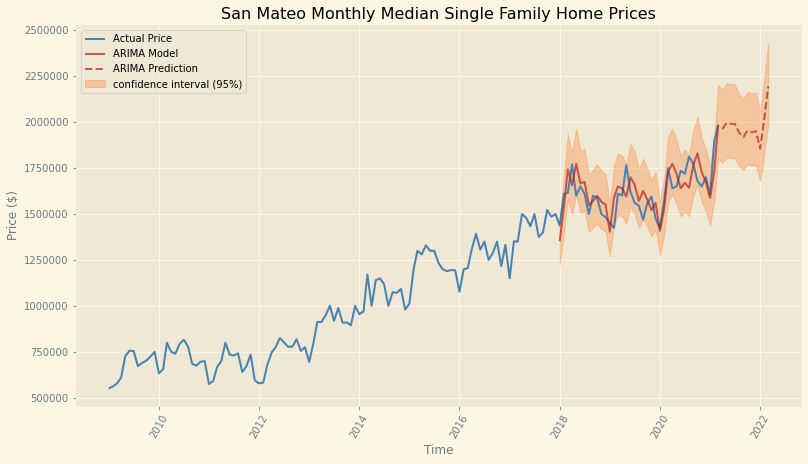

In [283]:
# Plot the San Mateo Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_smt['San Mateo'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_smt_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model', alpha=0.7)
plt.plot( df_aft_crisis_smt_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction', alpha=0.7)
ax.fill_between(df_aft_crisis_smt_pred.index, df_aft_crisis_smt_pred['lower_bond'], df_aft_crisis_smt_pred['higher_bond'], color='#ff7823', alpha=0.3, label="confidence interval (95%)");
plt.title('San Mateo Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [284]:
df_aft_smt_b = df_aft_crisis_smt_train[['San Mateo']].copy()
df_aft_smt_b = df_aft_smt_b.reset_index()
df_aft_smt_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Time       108 non-null    datetime64[ns]
 1   San Mateo  108 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB


In [285]:
df_aft_smt_p = df_aft_crisis_smt_pred[['San Mateo','Prediction ARIMA','lower_bond','higher_bond']].copy()
df_aft_smt_p['Prediction ARIMA'] = df_aft_smt_p['Prediction ARIMA'].astype(int)
df_aft_smt_p['San Mateo'] = df_aft_smt_p['San Mateo'].astype('float64')
df_aft_smt_p.index.names = ['Time']
df_aft_smt_p = df_aft_smt_p.reset_index()
df_aft_smt_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              51 non-null     datetime64[ns]
 1   San Mateo         39 non-null     float64       
 2   Prediction ARIMA  51 non-null     int64         
 3   lower_bond        51 non-null     int64         
 4   higher_bond       51 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 KB


In [286]:
df_smt = pd.concat([df_aft_smt_b, df_aft_smt_p])

In [287]:
# change the time column in order to visualize better 
df_smt['Time2'] = df_smt['Time'].dt.strftime('%b %d %Y')  # non-ISO serialization 

In [288]:
df_smt.iloc[105:115]

Time  San Mateo  Prediction ARIMA  lower_bond  higher_bond  \
105 2017-10-01  1522500.0               NaN         NaN          NaN   
106 2017-11-01  1486000.0               NaN         NaN          NaN   
107 2017-12-01  1500000.0               NaN         NaN          NaN   
0   2018-01-01  1437500.0         1352939.0   1225627.0    1499597.0   
1   2018-02-01  1610000.0         1541694.0   1396620.0    1708813.0   
2   2018-03-01  1615000.0         1744172.0   1580045.0    1933240.0   
3   2018-04-01  1770000.0         1656243.0   1500390.0    1835779.0   
4   2018-05-01  1600000.0         1773145.0   1606292.0    1965353.0   
5   2018-06-01  1650500.0         1666532.0   1509711.0    1847184.0   
6   2018-07-01  1610000.0         1675144.0   1517512.0    1856729.0   

           Time2  
105  Oct 01 2017  
106  Nov 01 2017  
107  Dec 01 2017  
0    Jan 01 2018  
1    Feb 01 2018  
2    Mar 01 2018  
3    Apr 01 2018  
4    May 01 2018  
5    Jun 01 2018  
6    Jul 01 2018

In [289]:
# save df_smt for use in test2 notebook


df_smt.to_pickle('df_smt.pickle')

<br>

<font color=blue  size=20> 8 - Santa Clara </font>

<br>

In [290]:
# Split Santa Clara Dataset 

df_aft_crisis_scl = df_aft_crisis[['Santa Clara']]

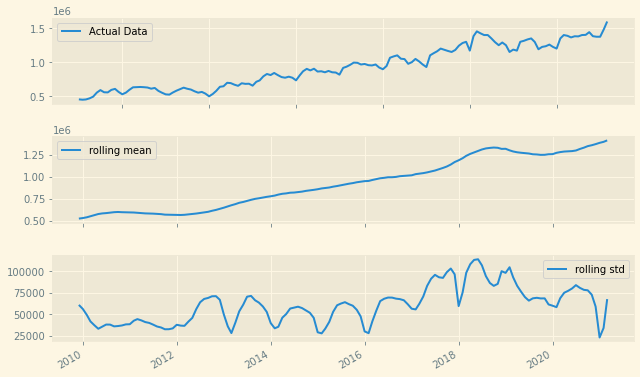

In [291]:
# Plot Rolling mean and variance

plot_rolling(df_aft_crisis_scl)

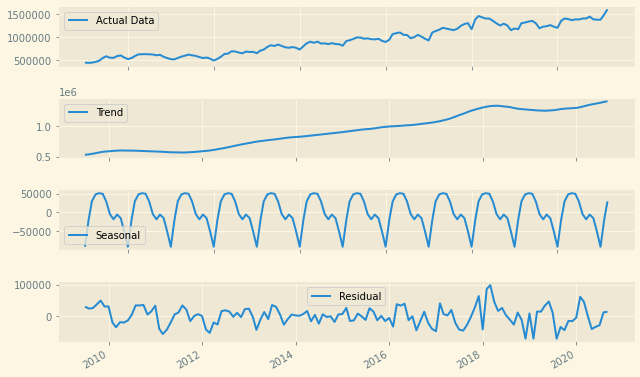

In [292]:
# Plot decompose charts

decomp_plot(df_aft_crisis_scl)

In [293]:
adfuller_test(df_aft_crisis_scl)


 > Is the data stationary ?

Test statistic = 0.264
P-value = 0.976
#Lag used = 14
Number of observations = 132
Critical values :
	1%: -3.481 - The data is not stationary with 99% confidence
	5%: -2.884 - The data is not stationary with 95% confidence
	10%: -2.579 - The data is not stationary with 90% confidence


In [294]:
# Create San Francisco Logarithmic Column

df_aft_crisis_scl['Santa Clara (Log)'] = df_aft_crisis_scl['Santa Clara'].apply(lambda x : np.log(x))

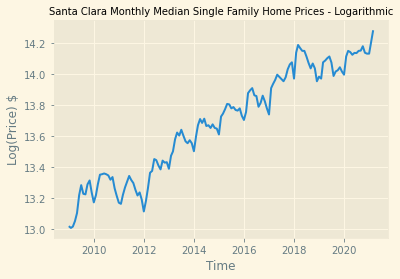

In [295]:
# Plot Log(Df) Dataset

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_aft_crisis_scl['Santa Clara (Log)'])
plt.title('Santa Clara Monthly Median Single Family Home Prices - Logarithmic', fontdict={'fontsize':10}) 
plt.ylabel('Log(Price) $')
plt.xlabel('Time')
plt.show()

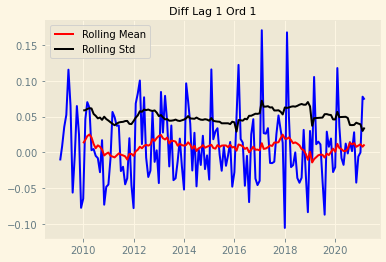

ADF Statistic: -3.0649328055016967
p-value: 0.0292595280412695
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


In [296]:
# Differencing order 1

df_aft_crisis_scl['Diff Lag 1 Ord 1'] = np.NaN
df_aft_crisis_scl['Diff Lag 1 Ord 1'].iloc[1:] = np.diff(df_aft_crisis_scl['Santa Clara (Log)'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_scl[['Diff Lag 1 Ord 1']])

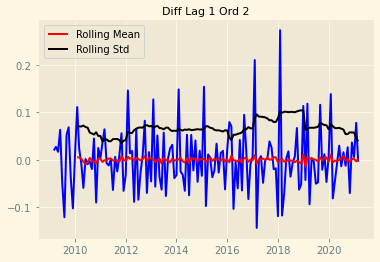

ADF Statistic: -11.162112058210377
p-value: 2.771363689388205e-20
Critical Values:
	1%: -3.480500383888377
	5%: -2.8835279559405045
	10%: -2.578495716547007


In [297]:
# Differencing order 2

df_aft_crisis_scl['Diff Lag 1 Ord 2'] = np.NaN
df_aft_crisis_scl['Diff Lag 1 Ord 2'].iloc[1:] = np.diff(df_aft_crisis_scl['Diff Lag 1 Ord 1'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_scl[['Diff Lag 1 Ord 2']])

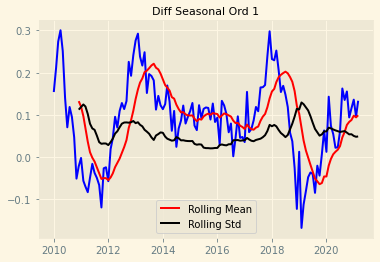

ADF Statistic: -3.197767504935045
p-value: 0.020114269023349805
Critical Values:
	1%: -3.4851223522012855
	5%: -2.88553750045158
	10%: -2.5795685622144586


In [298]:
# Differencing Seasonal order 1 

df_aft_crisis_scl['Diff Seasonal Ord 1'] = np.NaN
df_aft_crisis_scl['Diff Seasonal Ord 1'].iloc[12:] = diff(df_aft_crisis_scl['Santa Clara (Log)'],interval =12)

# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_scl[['Diff Seasonal Ord 1']])

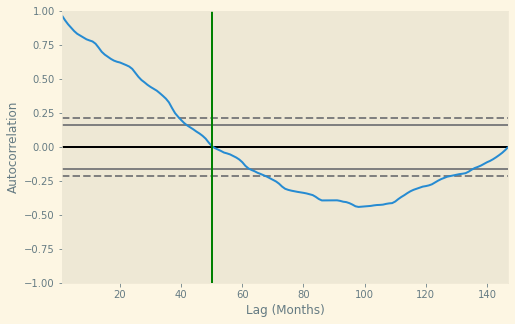

In [299]:
# Seasonality or Noise ?

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_scl['Santa Clara (Log)'])
plt.axvline(50, color='green')
plt.xlabel('Lag (Months)')
plt.show()

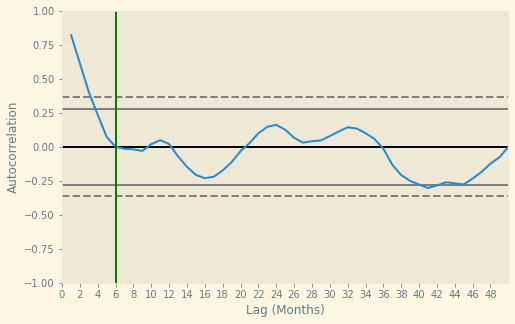

In [300]:
# Noise 

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_scl['Santa Clara (Log)'][:50])
plt.xlabel('Lag (Months)')
plt.xticks(np.arange(0, 50, step=2))
plt.axvline(6, color='green')
plt.show()

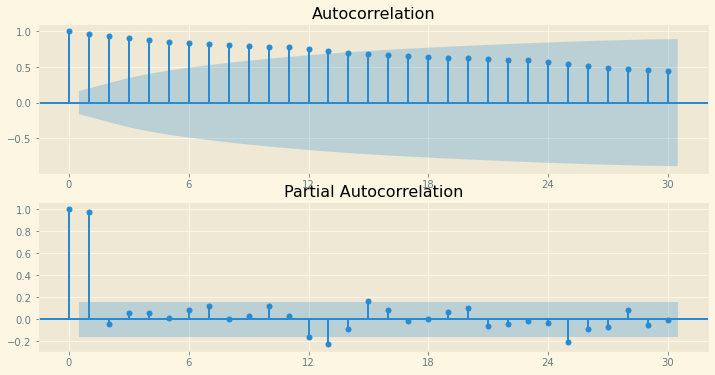

In [301]:
acf_pacf_plot(df_aft_crisis_scl['Santa Clara (Log)'])

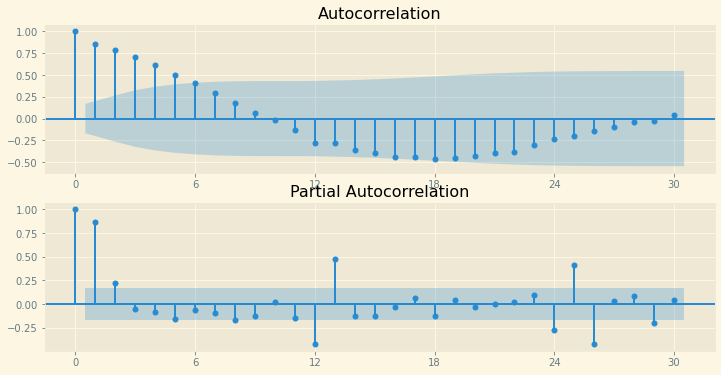

In [302]:
acf_pacf_plot(df_aft_crisis_scl['Diff Seasonal Ord 1'])

Based on ACF and PACF figures, the possible appropriate values for p and q: 

    p : 1 , 2 , 3 , 12 
    
    q : 1 , 5 , 9
    
The best combination of parameters can be achived through grid search step. 

keep in mind that I do differencing (I part in ARIMA), manually in my model, therfore in ARIMA class I am going to use 0 as *I*. 

In [303]:
# Split the dataset into train and valid datasets 

df_aft_crisis_scl_train = df_aft_crisis_scl[df_aft_crisis_scl.index.year < 2018].dropna(how='all')
df_aft_crisis_scl_valid = df_aft_crisis_scl[df_aft_crisis_scl.index.year >= 2018].dropna(how='all')

In [304]:
# Get the shape of training and valdation dataset 
print('df train after crisis Shape', df_aft_crisis_scl_train.shape)
print('df valid after crisis Shape', df_aft_crisis_scl_valid.shape)

df train after crisis Shape (108, 5)
df valid after crisis Shape (39, 5)


In [305]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_model_ARIMA(arima_order):
    
    
    history_scl = [x for x in df_aft_crisis_scl_train['Santa Clara (Log)']]
    predictions = list()

    for i in range(len(df_aft_crisis_scl_valid)):
    
        #difference data
            months_in_year = 12
            diff_df = diff(history_scl, months_in_year)
    
        # predict
            model = ARIMA(diff_df, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            yhat = inverse_difference(history_scl, yhat, months_in_year)
            predictions.append(yhat)
    
        # observation
            obs = df_aft_crisis_scl_valid['Santa Clara (Log)'].iloc[i]
            history_scl.append(obs)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(df_aft_crisis_scl_valid['Santa Clara (Log)'], predictions))
    return rmse

In [306]:
# Grid Search for ARIMA model
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(10, 13)
warnings.filterwarnings("ignore")
i_test = evaluate_models(evaluate_model_ARIMA ,p_values, d_values, q_values)

Models Parameters and Performance: Loading.....
ARIMA(0, 0, 10) RMSE=0.0517
ARIMA(0, 0, 11) RMSE=0.0447
ARIMA(0, 0, 12) RMSE=0.0425
Best: ARIMA(0, 0, 12) RMSE=0.0425


In [307]:
history_scl = [x for x in df_aft_crisis_scl_train['Santa Clara (Log)']]
predictions = list()

for i in range(len(df_aft_crisis_scl_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_scl, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(0,0,12))
    model_fit_ARIMA = model.fit()
    yhat = model_fit_ARIMA.forecast()[0]
    yhat = inverse_difference(history_scl, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_scl_valid['Santa Clara (Log)'].iloc[i]
    history_scl.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_scl_valid['Santa Clara (Log)'], predictions))
print('RMSE: %.4f' % rmse)

RMSE: 0.0425


In [308]:
# Predictions and Error Columns

df_aft_crisis_scl_valid['Prediction (Log)'] = predictions 
df_aft_crisis_scl_valid['Prediction ARIMA'] = df_aft_crisis_scl_valid['Prediction (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_scl_valid['Error ARIMA'] = round(((df_aft_crisis_scl_valid['Prediction ARIMA'] - df_aft_crisis_scl_valid['Santa Clara'])
                                                /df_aft_crisis_scl_valid['Santa Clara']),3)

In [309]:
df_aft_crisis_scl_valid.head(3)

Santa Clara  Santa Clara (Log)  Diff Lag 1 Ord 1  \
Time                                                           
2018-01-01      1170000          13.972514         -0.105361   
2018-02-01      1383500          14.140127          0.167613   
2018-03-01      1454500          14.190173          0.050046   

            Diff Lag 1 Ord 2  Diff Seasonal Ord 1  Prediction (Log)  \
Time                                                                  
2018-01-01         -0.118913             0.232266         14.018069   
2018-02-01          0.272973             0.229306         14.092160   
2018-03-01         -0.117567             0.252445         14.182479   

            Prediction ARIMA  Error ARIMA  
Time                                       
2018-01-01           1224531        0.047  
2018-02-01           1318704       -0.047  
2018-03-01           1443352       -0.008

In [310]:
# Plot the Santa Clara Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_scl['Santa Clara'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_scl_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.title('ARIMA Model - Santa Clara Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [311]:
residuals_ARIMA = [df_aft_crisis_scl_valid['Santa Clara'].iloc[i]-df_aft_crisis_scl_valid['Prediction ARIMA'].iloc[i] for i in range(len(df_aft_crisis_scl_valid))]
residuals_ARIMA = pd.DataFrame(residuals_ARIMA)
print (residuals_ARIMA.describe([.05,.1,.25,.5,.75,.9,0.95]))
print (df_aft_crisis_scl_valid[['Error ARIMA']].describe([.05,.1,.25,.5,.75,.9,0.95]))

                   0
count      39.000000
mean    -9703.410256
std     53972.596100
min   -173759.000000
5%     -92995.300000
10%    -74413.400000
25%    -40968.000000
50%     -1359.000000
75%     23860.500000
90%     51152.000000
95%     64102.100000
max    102907.000000
       Error ARIMA
count    39.000000
mean      0.008308
std       0.043461
min      -0.087000
5%       -0.047000
10%      -0.037000
25%      -0.018000
50%       0.001000
75%       0.030500
90%       0.058000
95%       0.080600
max       0.149000


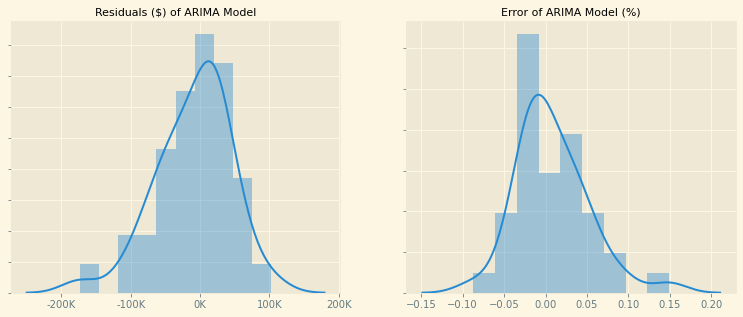

In [312]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA, ax=axes[0], bins=10, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_scl_valid['Error ARIMA'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model (%)',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

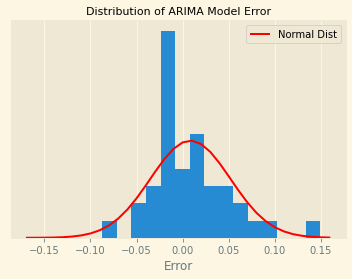

In [313]:
# 
x = np.arange(-0.17,0.17,0.01)

df_aft_crisis_scl_valid['Error ARIMA'].hist(bins=15, density=True)
plt.plot(x , sp.stats.norm(loc = df_aft_crisis_scl_valid['Error ARIMA'].mean(), 
                           scale = df_aft_crisis_scl_valid['Error ARIMA'].std()).pdf(x),
                         linewidth=2 , color='red', label = 'Normal Dist')
plt.yticks([])
plt.xlabel('Error')
plt.title('Distribution of ARIMA Model Error', fontdict={'fontsize':11})
plt.legend()
plt.show()

In [314]:
residuals_ARIMA_log = [df_aft_crisis_scl_valid['Santa Clara (Log)'].iloc[i]-df_aft_crisis_scl_valid['Prediction (Log)'].iloc[i] 
                       for i in range(len(df_aft_crisis_scl_valid))]
residuals_ARIMA_log = pd.DataFrame(residuals_ARIMA_log)
print(residuals_ARIMA_log.describe())

               0
count  39.000000
mean   -0.007284
std     0.042412
min    -0.138468
25%    -0.029670
50%    -0.000942
75%     0.018054
max     0.090845


In [315]:
# Add 12 months to the end of the df_aft_crisis_bay_valid
df_future = future_data_needed(df_aft_crisis_scl_valid, pred_months=12)

In [316]:
# Make the dataset of next 12 months predictions
df_aft_crisis_scl_pred = future_pred_ARIMA(df_future, df_aft_crisis_scl_train, 
                                               ARIMA_order=(0,0,12), pred_col = 'Santa Clara (Log)', pred_months=12)

In [317]:
# Plot the Santa Clara Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_scl['Santa Clara'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_scl_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_scl_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction')
plt.title('Santa Clara Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [318]:
# margin of error on predictions error

error_list = df_aft_crisis_scl_pred['Error ARIMA'].dropna()
error_list.describe([0.025,0.05,0.1,0.5,0.9,0.95,0.975])

count    39.000000
mean      0.008308
std       0.043461
min      -0.087000
2.5%     -0.049000
5%       -0.047000
10%      -0.037000
50%       0.001000
90%       0.058000
95%       0.080600
97.5%     0.097700
max       0.149000
Name: Error ARIMA, dtype: float64

In [319]:
print ('mean of error:', np.mean(error_list))
print ('std deviation of error:', np.std(error_list))
print ('std dev of sample:',statistics.stdev(error_list))
############# 
critical_value = 1.96
std = statistics.stdev(error_list)
sample = len(error_list)
MOE = critical_value * (std / np.sqrt(sample))
print ('margin of error:', MOE)
print ('lower:', np.mean(error_list)-MOE)
print ('highr:', np.mean(error_list)+MOE)
high_bond_rate = 1 + np.mean(error_list)+MOE
low_bond_rate = 1 + np.mean(error_list)-MOE

mean of error: 0.008307692307692306
std deviation of error: 0.04290009494111413
std dev of sample: 0.043460904298336336
margin of error: 0.01364025616126466
lower: -0.005332563853572354
highr: 0.021947948468956965


In [320]:
# higher and lower rate comes from error distribution for 2.5% , 97.5% (95% confidence interval)

df_aft_crisis_scl_pred['lower_bond'] = (df_aft_crisis_scl_pred['Prediction ARIMA']* (1-0.049)).astype(int)
df_aft_crisis_scl_pred['higher_bond'] = (df_aft_crisis_scl_pred['Prediction ARIMA'] * (1.097)).astype(int)

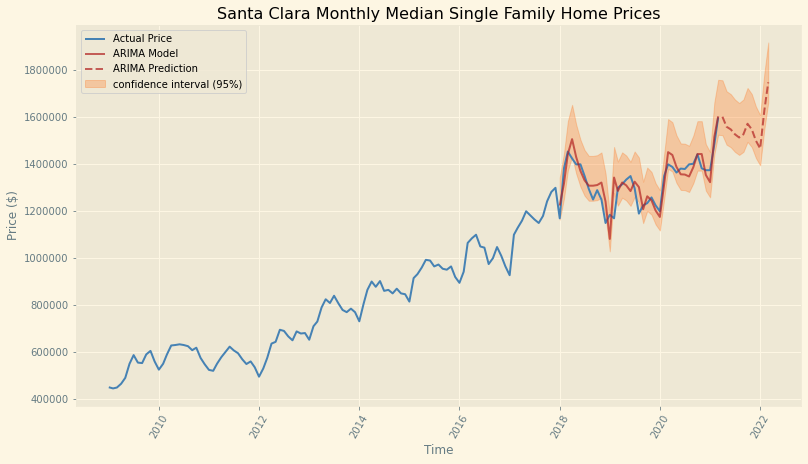

In [321]:
# Plot the Santa Clara Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_scl['Santa Clara'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_scl_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model', alpha=0.7)
plt.plot( df_aft_crisis_scl_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction', alpha=0.7)
ax.fill_between(df_aft_crisis_scl_pred.index, df_aft_crisis_scl_pred['lower_bond'], df_aft_crisis_scl_pred['higher_bond'], color='#ff7823', alpha=0.3, label="confidence interval (95%)");
plt.title('Santa Clara Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [322]:
df_aft_scl_b = df_aft_crisis_scl_train[['Santa Clara']].copy()
df_aft_scl_b = df_aft_scl_b.reset_index()
df_aft_scl_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         108 non-null    datetime64[ns]
 1   Santa Clara  108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [323]:
df_aft_scl_p = df_aft_crisis_scl_pred[['Santa Clara','Prediction ARIMA','lower_bond','higher_bond']].copy()
df_aft_scl_p['Prediction ARIMA'] = df_aft_scl_p['Prediction ARIMA'].astype(int)
df_aft_scl_p['Santa Clara'] = df_aft_scl_p['Santa Clara'].astype('float64')
df_aft_scl_p.index.names = ['Time']
df_aft_scl_p = df_aft_scl_p.reset_index()
df_aft_scl_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              51 non-null     datetime64[ns]
 1   Santa Clara       39 non-null     float64       
 2   Prediction ARIMA  51 non-null     int64         
 3   lower_bond        51 non-null     int64         
 4   higher_bond       51 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 KB


In [324]:
df_scl = pd.concat([df_aft_scl_b, df_aft_scl_p])

In [325]:
# change the time column in order to visualize better 
df_scl['Time2'] = df_scl['Time'].dt.strftime('%b %d %Y')  # non-ISO serialization 

In [326]:
df_scl.iloc[105:115]

Time  Santa Clara  Prediction ARIMA  lower_bond  higher_bond  \
105 2017-10-01    1242500.0               NaN         NaN          NaN   
106 2017-11-01    1282500.0               NaN         NaN          NaN   
107 2017-12-01    1300000.0               NaN         NaN          NaN   
0   2018-01-01    1170000.0         1224531.0   1164528.0    1343310.0   
1   2018-02-01    1383500.0         1318704.0   1254087.0    1446618.0   
2   2018-03-01    1454500.0         1443352.0   1372627.0    1583357.0   
3   2018-04-01    1425000.0         1507435.0   1433570.0    1653656.0   
4   2018-05-01    1400000.0         1430871.0   1360758.0    1569665.0   
5   2018-06-01    1400000.0         1372046.0   1304815.0    1505134.0   
6   2018-07-01    1351000.0         1331840.0   1266579.0    1461028.0   

           Time2  
105  Oct 01 2017  
106  Nov 01 2017  
107  Dec 01 2017  
0    Jan 01 2018  
1    Feb 01 2018  
2    Mar 01 2018  
3    Apr 01 2018  
4    May 01 2018  
5    Jun 01 2018  
6    Jul 01 2018

In [327]:
# save df_scl for use in test2 notebook


df_scl.to_pickle('df_scl.pickle')

<br>

<font color=blue  size=20> 9 - Solano </font>

<br>

In [328]:
# Split Solano Dataset 

df_aft_crisis_sol = df_aft_crisis[['Solano']]

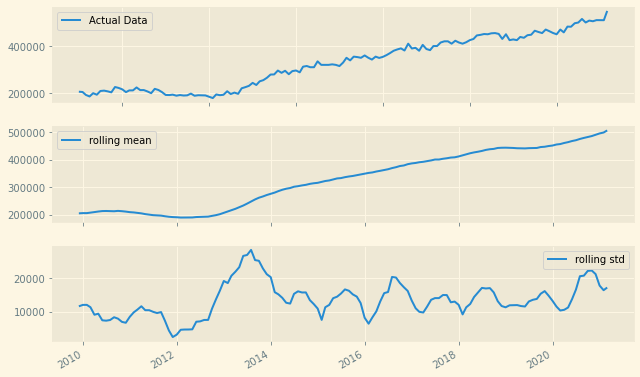

In [329]:
# Plot Rolling mean and variance

plot_rolling(df_aft_crisis_sol)

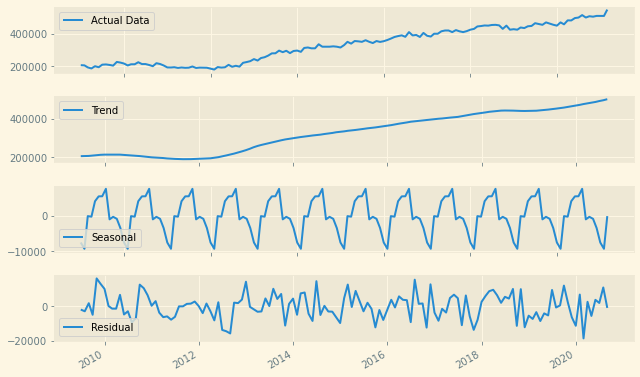

In [330]:
# Plot decompose charts

decomp_plot(df_aft_crisis_sol)

In [331]:
adfuller_test(df_aft_crisis_sol)


 > Is the data stationary ?

Test statistic = 1.051
P-value = 0.995
#Lag used = 1
Number of observations = 145
Critical values :
	1%: -3.476 - The data is not stationary with 99% confidence
	5%: -2.882 - The data is not stationary with 95% confidence
	10%: -2.578 - The data is not stationary with 90% confidence


In [332]:
# Create Solano Logarithmic Column

df_aft_crisis_sol['Solano (Log)'] = df_aft_crisis_sol['Solano'].apply(lambda x : np.log(x))

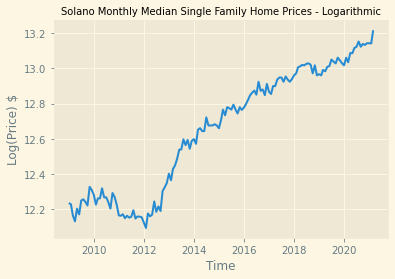

In [333]:
# Plot Log(Df) Dataset

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_aft_crisis_sol['Solano (Log)'])
plt.title('Solano Monthly Median Single Family Home Prices - Logarithmic', fontdict={'fontsize':10}) 
plt.ylabel('Log(Price) $')
plt.xlabel('Time')
plt.show()

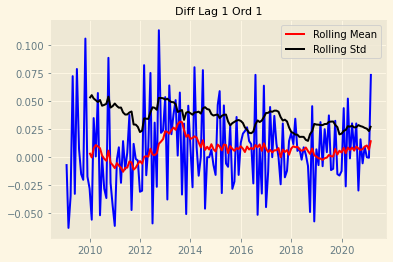

ADF Statistic: -16.749120927857415
p-value: 1.3384924000385055e-29
Critical Values:
	1%: -3.476273058920005
	5%: -2.881687616548444
	10%: -2.5775132580261593


In [334]:
# Differencing order 1

df_aft_crisis_sol['Diff Lag 1 Ord 1'] = np.NaN
df_aft_crisis_sol['Diff Lag 1 Ord 1'].iloc[1:] = np.diff(df_aft_crisis_sol['Solano (Log)'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_sol[['Diff Lag 1 Ord 1']])

In [335]:
# Differencing order 2

df_aft_crisis_sol['Diff Lag 1 Ord 2'] = np.NaN
df_aft_crisis_sol['Diff Lag 1 Ord 2'].iloc[1:] = np.diff(df_aft_crisis_sol['Diff Lag 1 Ord 1'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_sol[['Diff Lag 1 Ord 2']])

ADF Statistic: -7.257371683705108
p-value: 1.7167971189934268e-10
Critical Values:
	1%: -3.480118600110386
	5%: -2.8833618426136196
	10%: -2.578407034974382


In [336]:
# Differencing Seasonal order 1 

df_aft_crisis_sol['Diff Seasonal Ord 1'] = np.NaN
df_aft_crisis_sol['Diff Seasonal Ord 1'].iloc[12:] = diff(df_aft_crisis_sol['Solano (Log)'],interval =12)

# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_sol[['Diff Seasonal Ord 1']])

ADF Statistic: -2.7764716214018375
p-value: 0.06171402027796262
Critical Values:
	1%: -3.485585145896754
	5%: -2.885738566292665
	10%: -2.5796759080663887


In [337]:
# Seasonality or Noise ?

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_sol['Solano (Log)'])
plt.axvline(50, color='green')
plt.xlabel('Lag (Months)')
plt.show()

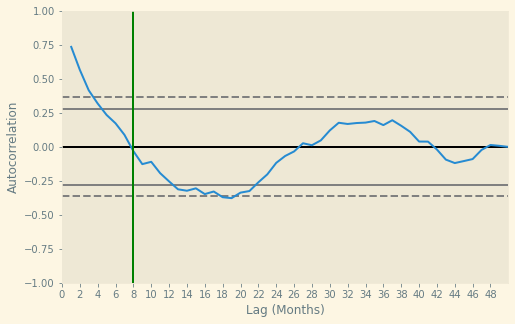

In [338]:
# Noise 

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_sol['Solano (Log)'][:50])
plt.xlabel('Lag (Months)')
plt.xticks(np.arange(0, 50, step=2))
plt.axvline(8, color='green')
plt.show()

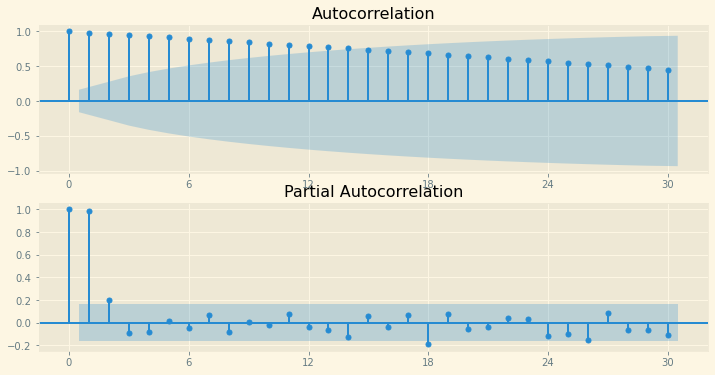

In [339]:
acf_pacf_plot(df_aft_crisis_sol['Solano (Log)'])

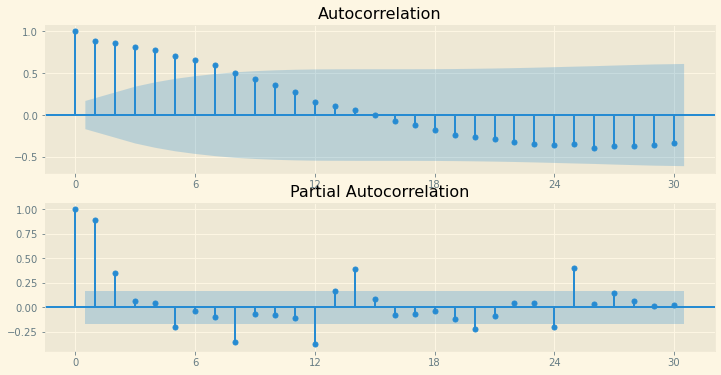

In [340]:
acf_pacf_plot(df_aft_crisis_sol['Diff Seasonal Ord 1'])

Based on ACF and PACF figures, the possible appropriate values for p and q: 

    p : 1 , 2 , 3 , 4 
    
    q : 12 , 13 , 14
    
The best combination of parameters can be achived through grid search step. 

keep in mind that I do differencing (I part in ARIMA), manually in my model, therfore in ARIMA class I am going to use 0 as *I*. 

In [341]:
# Split the dataset into train and valid datasets 

df_aft_crisis_sol_train = df_aft_crisis_sol[df_aft_crisis_sol.index.year < 2018].dropna(how='all')
df_aft_crisis_sol_valid = df_aft_crisis_sol[df_aft_crisis_sol.index.year >= 2018].dropna(how='all')

In [342]:
# Get the shape of training and valdation dataset 
print('df train after crisis Shape', df_aft_crisis_sol_train.shape)
print('df valid after crisis Shape', df_aft_crisis_sol_valid.shape)

df train after crisis Shape (108, 5)
df valid after crisis Shape (39, 5)


In [343]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_model_ARIMA(arima_order):
    
    
    history_sol = [x for x in df_aft_crisis_sol_train['Solano (Log)']]
    predictions = list()

    for i in range(len(df_aft_crisis_sol_valid)):
    
        #difference data
            months_in_year = 12
            diff_df = diff(history_sol, months_in_year)
    
        # predict
            model = ARIMA(diff_df, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            yhat = inverse_difference(history_sol, yhat, months_in_year)
            predictions.append(yhat)
    
        # observation
            obs = df_aft_crisis_sol_valid['Solano (Log)'].iloc[i]
            history_sol.append(obs)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(df_aft_crisis_sol_valid['Solano (Log)'], predictions))
    return rmse

In [344]:
# Grid Search for ARIMA model
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(10, 13)
warnings.filterwarnings("ignore")
i_test = evaluate_models(evaluate_model_ARIMA ,p_values, d_values, q_values)

Models Parameters and Performance: Loading.....
ARIMA(0, 0, 10) RMSE=0.0296
ARIMA(0, 0, 11) RMSE=0.0283
ARIMA(0, 0, 12) RMSE=0.0260
ARIMA(1, 1, 12) RMSE=0.0259
ARIMA(2, 0, 12) RMSE=0.0252
ARIMA(3, 0, 12) RMSE=0.0235
Best: ARIMA(3, 0, 12) RMSE=0.0235


In [345]:
history_sol = [x for x in df_aft_crisis_sol_train['Solano (Log)']]
predictions = list()

for i in range(len(df_aft_crisis_sol_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_sol, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(3,0,12))
    model_fit_ARIMA = model.fit()
    yhat = model_fit_ARIMA.forecast()[0]
    yhat = inverse_difference(history_sol, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_sol_valid['Solano (Log)'].iloc[i]
    history_sol.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_sol_valid['Solano (Log)'], predictions))
print('RMSE: %.4f' % rmse)

RMSE: 0.0235


In [346]:
# Predictions and Error Columns

df_aft_crisis_sol_valid['Prediction (Log)'] = predictions 
df_aft_crisis_sol_valid['Prediction ARIMA'] = df_aft_crisis_sol_valid['Prediction (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_sol_valid['Error ARIMA'] = round(((df_aft_crisis_sol_valid['Prediction ARIMA'] - df_aft_crisis_sol_valid['Solano'])
                                                /df_aft_crisis_sol_valid['Solano']),3)

In [347]:
df_aft_crisis_sol_valid.head(3)

Solano  Solano (Log)  Diff Lag 1 Ord 1  Diff Lag 1 Ord 2  \
Time                                                                     
2018-01-01  425000.0     12.959844          0.021404          0.006876   
2018-02-01  430000.0     12.971540          0.011696         -0.009708   
2018-03-01  445000.0     13.005830          0.034289          0.022593   

            Diff Seasonal Ord 1  Prediction (Log)  Prediction ARIMA  \
Time                                                                  
2018-01-01             0.092631         12.926145            410916   
2018-02-01             0.117057         12.948093            420035   
2018-03-01             0.106610         13.026601            454340   

            Error ARIMA  
Time                     
2018-01-01       -0.033  
2018-02-01       -0.023  
2018-03-01        0.021

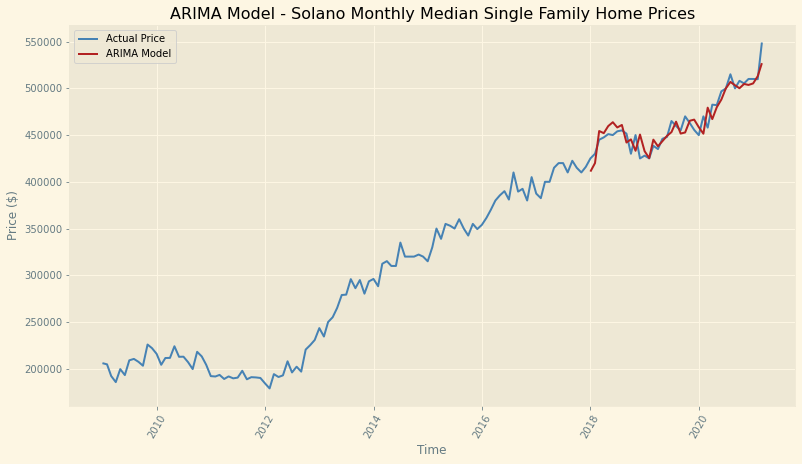

In [348]:
# Plot the Solano Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_sol['Solano'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_sol_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.title('ARIMA Model - Solano Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [349]:
residuals_ARIMA = [df_aft_crisis_sol_valid['Solano'].iloc[i]-df_aft_crisis_sol_valid['Prediction ARIMA'].iloc[i] for i in range(len(df_aft_crisis_sol_valid))]
residuals_ARIMA = pd.DataFrame(residuals_ARIMA)
print (residuals_ARIMA.describe([.05,.1,.25,.5,.75,.9,0.95]))
print (df_aft_crisis_sol_valid[['Error ARIMA']].describe([.05,.1,.25,.5,.75,.9,0.95]))

                  0
count     39.000000
mean     595.743590
std    10934.863075
min   -25539.000000
5%    -15965.700000
10%   -11558.200000
25%    -5296.000000
50%     -306.000000
75%     8488.500000
90%    15712.400000
95%    17367.200000
max    22111.000000
       Error ARIMA
count    39.000000
mean     -0.000641
std       0.023805
min      -0.040000
5%       -0.037200
10%      -0.033800
25%      -0.017000
50%       0.001000
75%       0.012000
90%       0.025400
95%       0.037100
max       0.060000


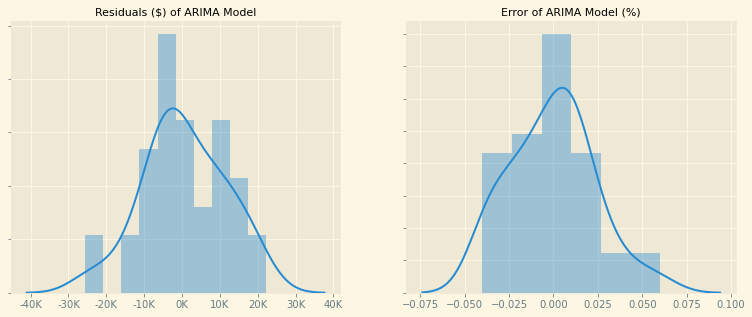

In [350]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA, ax=axes[0], bins=10, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_sol_valid['Error ARIMA'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model (%)',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

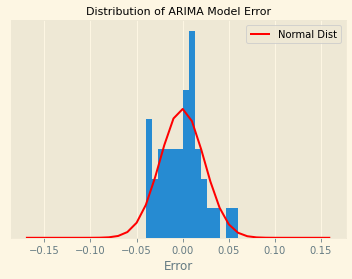

In [351]:
# 
x = np.arange(-0.17,0.17,0.01)

df_aft_crisis_sol_valid['Error ARIMA'].hist(bins=15, density=True)
plt.plot(x , sp.stats.norm(loc = df_aft_crisis_sol_valid['Error ARIMA'].mean(), 
                           scale = df_aft_crisis_sol_valid['Error ARIMA'].std()).pdf(x),
                         linewidth=2 , color='red', label = 'Normal Dist')
plt.yticks([])
plt.xlabel('Error')
plt.title('Distribution of ARIMA Model Error', fontdict={'fontsize':11})
plt.legend()
plt.show()

In [352]:
residuals_ARIMA_log = [df_aft_crisis_sol_valid['Solano (Log)'].iloc[i]-df_aft_crisis_sol_valid['Prediction (Log)'].iloc[i] 
                       for i in range(len(df_aft_crisis_sol_valid))]
residuals_ARIMA_log = pd.DataFrame(residuals_ARIMA_log)
print(residuals_ARIMA_log.describe())

               0
count  39.000000
mean    0.000950
std     0.023757
min    -0.058357
25%    -0.011900
50%    -0.000720
75%     0.016939
max     0.041108


In [353]:
# Add 12 months to the end of the df_aft_crisis_bay_valid
df_future = future_data_needed(df_aft_crisis_sol_valid, pred_months=12)

In [354]:
# Make the dataset of next 12 months predictions
df_aft_crisis_sol_pred = future_pred_ARIMA(df_future, df_aft_crisis_sol_train, 
                                               ARIMA_order=(3,0,12), pred_col = 'Solano (Log)', pred_months=12)

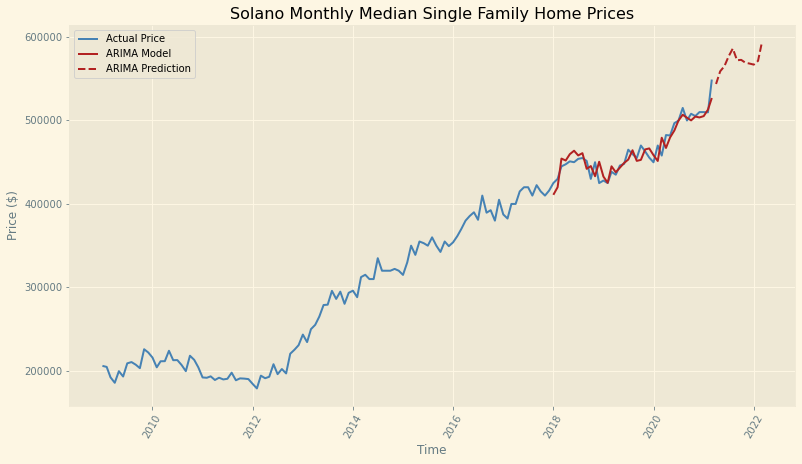

In [355]:
# Plot the Solano Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_sol['Solano'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_sol_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_sol_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction')
plt.title('Solano Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [356]:
# margin of error on predictions error

error_list = df_aft_crisis_sol_pred['Error ARIMA'].dropna()
error_list.describe([0.025,0.05,0.1,0.5,0.9,0.95,0.975])

count    39.000000
mean     -0.000641
std       0.023805
min      -0.040000
2.5%     -0.039050
5%       -0.037200
10%      -0.033800
50%       0.001000
90%       0.025400
95%       0.037100
97.5%     0.047650
max       0.060000
Name: Error ARIMA, dtype: float64

In [357]:
print ('mean of error:', np.mean(error_list))
print ('std deviation of error:', np.std(error_list))
print ('std dev of sample:',statistics.stdev(error_list))
############# 
critical_value = 1.96
std = statistics.stdev(error_list)
sample = len(error_list)
MOE = critical_value * (std / np.sqrt(sample))
print ('margin of error:', MOE)
print ('lower:', np.mean(error_list)-MOE)
print ('highr:', np.mean(error_list)+MOE)
high_bond_rate = 1 + np.mean(error_list)+MOE
low_bond_rate = 1 + np.mean(error_list)-MOE

mean of error: -0.0006410256410256411
std deviation of error: 0.023497394486751276
std dev of sample: 0.02380456300739439
margin of error: 0.007471090223961436
lower: -0.008112115864987076
highr: 0.0068300645829357945


In [358]:
# higher and lower rate comes from error distribution for 2.5% , 97.5% (95% confidence interval)

df_aft_crisis_sol_pred['lower_bond'] = (df_aft_crisis_sol_pred['Prediction ARIMA']* (1-0.039)).astype(int)
df_aft_crisis_sol_pred['higher_bond'] = (df_aft_crisis_sol_pred['Prediction ARIMA'] * (1.0476)).astype(int)

In [359]:
df_aft_crisis_sol_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2018-01-01 to 2022-03-01
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Solano               39 non-null     float64
 1   Solano (Log)         39 non-null     float64
 2   Diff Lag 1 Ord 1     39 non-null     float64
 3   Diff Lag 1 Ord 2     39 non-null     float64
 4   Diff Seasonal Ord 1  39 non-null     float64
 5   Prediction (Log)     51 non-null     float64
 6   Prediction ARIMA     51 non-null     object 
 7   Error ARIMA          39 non-null     float64
 8   lower_bond           51 non-null     int64  
 9   higher_bond          51 non-null     int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 4.4+ KB


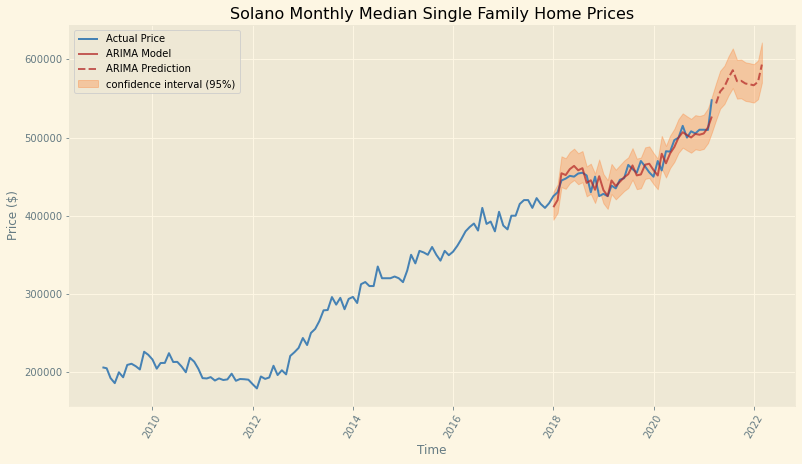

In [360]:
# Plot the Solano Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_sol['Solano'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_sol_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model', alpha=0.7)
plt.plot( df_aft_crisis_sol_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction', alpha=0.7)
ax.fill_between(df_aft_crisis_sol_pred.index, df_aft_crisis_sol_pred['lower_bond'], df_aft_crisis_sol_pred['higher_bond'], color='#ff7823', alpha=0.3, label="confidence interval (95%)");
plt.title('Solano Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [361]:
df_aft_sol_b = df_aft_crisis_sol_train[['Solano']].copy()
df_aft_sol_b = df_aft_sol_b.reset_index()
df_aft_sol_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    108 non-null    datetime64[ns]
 1   Solano  108 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB


In [362]:
df_aft_sol_p = df_aft_crisis_sol_pred[['Solano','Prediction ARIMA','lower_bond','higher_bond']].copy()
df_aft_sol_p['Prediction ARIMA'] = df_aft_sol_p['Prediction ARIMA'].astype(int)
df_aft_sol_p['Solano'] = df_aft_sol_p['Solano'].astype('float64')
df_aft_sol_p.index.names = ['Time']
df_aft_sol_p = df_aft_sol_p.reset_index()
df_aft_sol_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              51 non-null     datetime64[ns]
 1   Solano            39 non-null     float64       
 2   Prediction ARIMA  51 non-null     int64         
 3   lower_bond        51 non-null     int64         
 4   higher_bond       51 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 KB


In [363]:
df_sol = pd.concat([df_aft_sol_b, df_aft_sol_p])

In [364]:
# change the time column in order to visualize better 
df_sol['Time2'] = df_sol['Time'].dt.strftime('%b %d %Y')  # non-ISO serialization 

In [365]:
df_sol.iloc[105:115]

Time    Solano  Prediction ARIMA  lower_bond  higher_bond  \
105 2017-10-01  415000.0               NaN         NaN          NaN   
106 2017-11-01  410000.0               NaN         NaN          NaN   
107 2017-12-01  416000.0               NaN         NaN          NaN   
0   2018-01-01  425000.0          410916.0    394890.0     430475.0   
1   2018-02-01  430000.0          420035.0    403653.0     440028.0   
2   2018-03-01  445000.0          454340.0    436620.0     475966.0   
3   2018-04-01  447500.0          452012.0    434383.0     473527.0   
4   2018-05-01  451000.0          459601.0    441676.0     481478.0   
5   2018-06-01  450000.0          463743.0    445657.0     485817.0   
6   2018-07-01  454000.0          458121.0    440254.0     479927.0   

           Time2  
105  Oct 01 2017  
106  Nov 01 2017  
107  Dec 01 2017  
0    Jan 01 2018  
1    Feb 01 2018  
2    Mar 01 2018  
3    Apr 01 2018  
4    May 01 2018  
5    Jun 01 2018  
6    Jul 01 2018

In [366]:
# save df_sol for use in test2 notebook


df_sol.to_pickle('df_sol.pickle')

<br>

<font color=blue  size=20> 10 - Sonoma </font>

<br>

In [367]:
# Split Sonoma Dataset 

df_aft_crisis_son = df_aft_crisis[['Sonoma']]

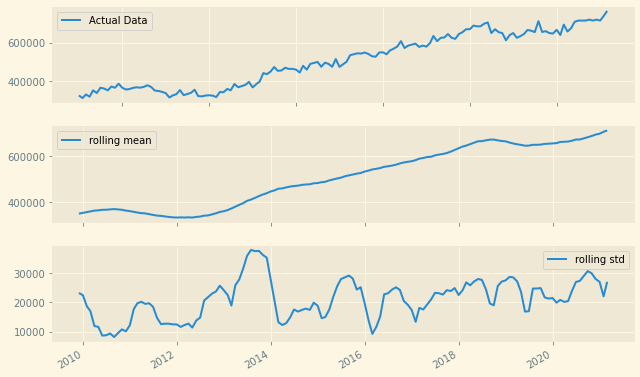

In [368]:
# Plot Rolling mean and variance

plot_rolling(df_aft_crisis_son)

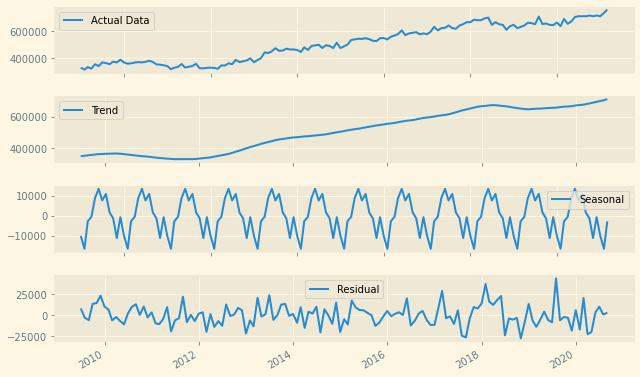

In [369]:
# Plot decompose charts

decomp_plot(df_aft_crisis_son)

In [370]:
adfuller_test(df_aft_crisis_son)


 > Is the data stationary ?

Test statistic = 0.447
P-value = 0.983
#Lag used = 6
Number of observations = 140
Critical values :
	1%: -3.478 - The data is not stationary with 99% confidence
	5%: -2.882 - The data is not stationary with 95% confidence
	10%: -2.578 - The data is not stationary with 90% confidence


In [371]:
# Create Solano Logarithmic Column

df_aft_crisis_son['Sonoma (Log)'] = df_aft_crisis_son['Sonoma'].apply(lambda x : np.log(x))

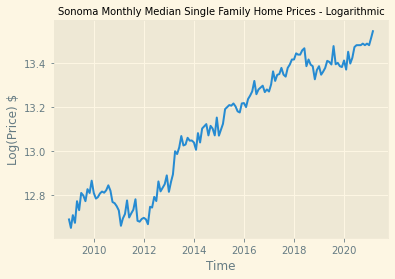

In [372]:
# Plot Log(Df) Dataset

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_aft_crisis_son['Sonoma (Log)'])
plt.title('Sonoma Monthly Median Single Family Home Prices - Logarithmic', fontdict={'fontsize':10}) 
plt.ylabel('Log(Price) $')
plt.xlabel('Time')
plt.show()

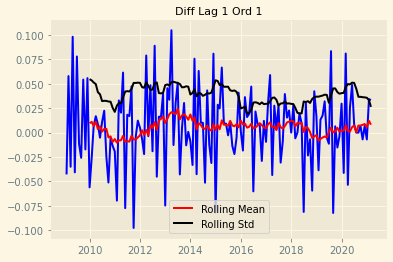

ADF Statistic: -5.5336492319427135
p-value: 1.76452489030722e-06
Critical Values:
	1%: -3.4782936965183815
	5%: -2.882567574015525
	10%: -2.5779830117488745


In [373]:
# Differencing order 1

df_aft_crisis_son['Diff Lag 1 Ord 1'] = np.NaN
df_aft_crisis_son['Diff Lag 1 Ord 1'].iloc[1:] = np.diff(df_aft_crisis_son['Sonoma (Log)'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_son[['Diff Lag 1 Ord 1']])

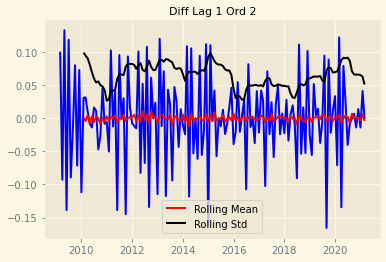

ADF Statistic: -4.053068585806632
p-value: 0.001156751627095634
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [374]:
# Differencing order 2

df_aft_crisis_son['Diff Lag 1 Ord 2'] = np.NaN
df_aft_crisis_son['Diff Lag 1 Ord 2'].iloc[1:] = np.diff(df_aft_crisis_son['Diff Lag 1 Ord 1'].to_numpy(), n=1)


# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_son[['Diff Lag 1 Ord 2']])

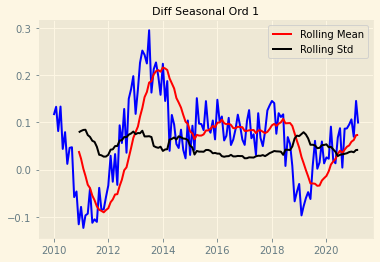

ADF Statistic: -2.5233751415017815
p-value: 0.10988999029414526
Critical Values:
	1%: -3.485585145896754
	5%: -2.885738566292665
	10%: -2.5796759080663887


In [375]:
# Differencing Seasonal order 1 

df_aft_crisis_son['Diff Seasonal Ord 1'] = np.NaN
df_aft_crisis_son['Diff Seasonal Ord 1'].iloc[12:] = diff(df_aft_crisis_son['Sonoma (Log)'],interval =12)

# Plot the first order differencing and doing ADF test
check_stationarity(df_aft_crisis_son[['Diff Seasonal Ord 1']])

In [376]:
# Seasonality or Noise ?

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_son['Sonoma (Log)'])
plt.axvline(50, color='green')
plt.xlabel('Lag (Months)')
plt.show()

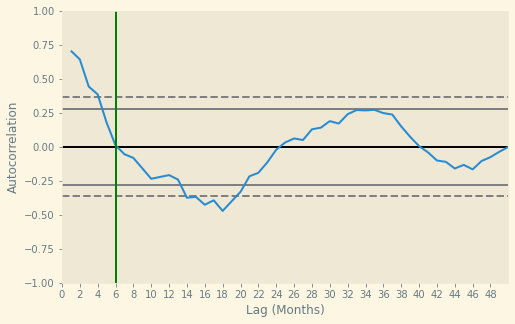

In [377]:
# Noise 

plt.figure(figsize=(8, 5))
autocorrelation_plot(df_aft_crisis_son['Sonoma (Log)'][:50])
plt.xlabel('Lag (Months)')
plt.xticks(np.arange(0, 50, step=2))
plt.axvline(6, color='green')
plt.show()

In [378]:
acf_pacf_plot(df_aft_crisis_son['Sonoma (Log)'])

In [379]:
acf_pacf_plot(df_aft_crisis_son['Diff Seasonal Ord 1'])

In [380]:
# Split the dataset into train and valid datasets 

df_aft_crisis_son_train = df_aft_crisis_son[df_aft_crisis_son.index.year < 2018].dropna(how='all')
df_aft_crisis_son_valid = df_aft_crisis_son[df_aft_crisis_son.index.year >= 2018].dropna(how='all')

In [381]:
# Get the shape of training and valdation dataset 
print('df train after crisis Shape', df_aft_crisis_son_train.shape)
print('df valid after crisis Shape', df_aft_crisis_son_valid.shape)

df train after crisis Shape (108, 5)
df valid after crisis Shape (39, 5)


In [382]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_model_ARIMA(arima_order):
    
    
    history_son = [x for x in df_aft_crisis_son_train['Sonoma (Log)']]
    predictions = list()

    for i in range(len(df_aft_crisis_son_valid)):
    
        #difference data
            months_in_year = 12
            diff_df = diff(history_son, months_in_year)
    
        # predict
            model = ARIMA(diff_df, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            yhat = inverse_difference(history_son, yhat, months_in_year)
            predictions.append(yhat)
    
        # observation
            obs = df_aft_crisis_son_valid['Sonoma (Log)'].iloc[i]
            history_son.append(obs)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(df_aft_crisis_son_valid['Sonoma (Log)'], predictions))
    return rmse

In [383]:
# Grid Search for ARIMA model
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(10, 13)
warnings.filterwarnings("ignore")
i_test = evaluate_models(evaluate_model_ARIMA ,p_values, d_values, q_values)

Models Parameters and Performance: Loading.....
ARIMA(0, 0, 10) RMSE=0.0448
ARIMA(0, 0, 11) RMSE=0.0395
ARIMA(1, 0, 12) RMSE=0.0382
Best: ARIMA(1, 0, 12) RMSE=0.0382


In [384]:
history_son = [x for x in df_aft_crisis_son_train['Sonoma (Log)']]
predictions = list()

for i in range(len(df_aft_crisis_son_valid)):
    
    #difference data
    months_in_year = 12
    diff_df = diff(history_son, months_in_year)
    
    # predict
    model = ARIMA(diff_df, order=(1,0,12))
    model_fit_ARIMA = model.fit()
    yhat = model_fit_ARIMA.forecast()[0]
    yhat = inverse_difference(history_son, yhat, months_in_year)
    predictions.append(yhat)
    
    # observation
    obs = df_aft_crisis_son_valid['Sonoma (Log)'].iloc[i]
    history_son.append(obs)
    
# report performance
rmse = np.sqrt(mean_squared_error(df_aft_crisis_son_valid['Sonoma (Log)'], predictions))
print('RMSE: %.4f' % rmse)

RMSE: 0.0382


In [385]:
# Predictions and Error Columns

df_aft_crisis_son_valid['Prediction (Log)'] = predictions 
df_aft_crisis_son_valid['Prediction ARIMA'] = df_aft_crisis_son_valid['Prediction (Log)'].apply(lambda x : int(np.exp(x)))
df_aft_crisis_son_valid['Error ARIMA'] = round(((df_aft_crisis_son_valid['Prediction ARIMA'] - df_aft_crisis_son_valid['Sonoma'])
                                                /df_aft_crisis_son_valid['Sonoma']),3)

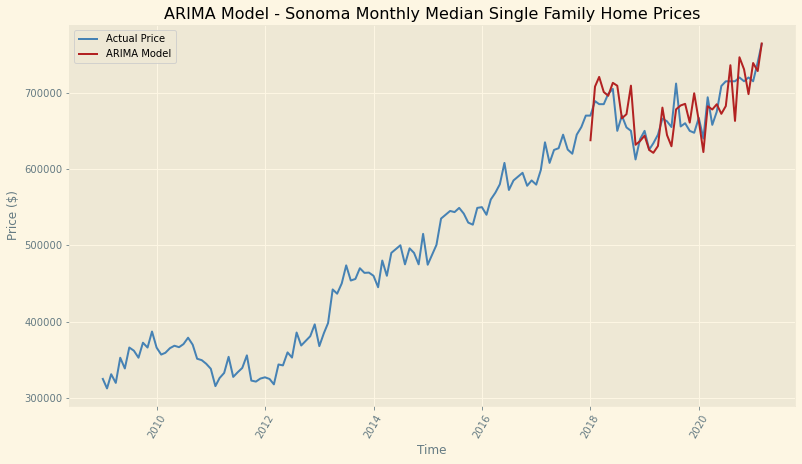

In [386]:
# Plot the Sonoma Single Family Median Price AND ARIMA model

fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_son['Sonoma'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_son_valid['Prediction ARIMA'], color = 'firebrick', label = 'ARIMA Model')
plt.title('ARIMA Model - Sonoma Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [387]:
residuals_ARIMA = [df_aft_crisis_son_valid['Sonoma'].iloc[i]-df_aft_crisis_son_valid['Prediction ARIMA'].iloc[i] for i in range(len(df_aft_crisis_son_valid))]
residuals_ARIMA = pd.DataFrame(residuals_ARIMA)
print (residuals_ARIMA.describe([.05,.1,.25,.5,.75,.9,0.95]))
print (df_aft_crisis_son_valid[['Error ARIMA']].describe([.05,.1,.25,.5,.75,.9,0.95]))

                  0
count     39.000000
mean   -3610.897436
std    26078.986630
min   -59254.000000
5%    -52545.000000
10%   -29179.200000
25%   -19680.500000
50%     -843.000000
75%    13688.000000
90%    32676.400000
95%    34057.400000
max    51968.000000
       Error ARIMA
count    39.000000
mean      0.005795
std       0.038609
min      -0.073000
5%       -0.050100
10%      -0.045400
25%      -0.021500
50%       0.001000
75%       0.030000
90%       0.044000
95%       0.081100
max       0.091000


In [388]:
# Histogram of ARIMA Model Residuals and Error

fig , axes = plt.subplots(1,2,figsize=(13,5), sharex=False, sharey=False)

sns.distplot(residuals_ARIMA, ax=axes[0], bins=10, hist=True, kde=True)
axes[0].set_title('Residuals ($) of ARIMA Model',fontdict={'fontsize':11})
axes[0].set(yticklabels=[])
axes[0].set(ylabel=None)
axes[0].set(xticklabels=['{:n}'.format(x) + 'K' for x in axes[0].get_xticks()/1000])

sns.distplot(df_aft_crisis_son_valid['Error ARIMA'], ax=axes[1], bins=None, hist=True, kde=True)
axes[1].set_title('Error of ARIMA Model (%)',fontdict={'fontsize':11})
axes[1].set(yticklabels=[])
axes[1].set(ylabel=None)
axes[1].set(xlabel=None)

plt.show()

In [389]:
 
x = np.arange(-0.17,0.17,0.01)

df_aft_crisis_son_valid['Error ARIMA'].hist(bins=15, density=True)
plt.plot(x , sp.stats.norm(loc = df_aft_crisis_son_valid['Error ARIMA'].mean(), 
                           scale = df_aft_crisis_son_valid['Error ARIMA'].std()).pdf(x),
                         linewidth=2 , color='red', label = 'Normal Dist')
plt.yticks([])
plt.xlabel('Error')
plt.title('Distribution of ARIMA Model Error', fontdict={'fontsize':11})
plt.legend()
plt.show()

In [390]:
residuals_ARIMA_log = [df_aft_crisis_son_valid['Sonoma (Log)'].iloc[i]-df_aft_crisis_son_valid['Prediction (Log)'].iloc[i] 
                       for i in range(len(df_aft_crisis_son_valid))]
residuals_ARIMA_log = pd.DataFrame(residuals_ARIMA_log)
print(residuals_ARIMA_log.describe())

               0
count  39.000000
mean   -0.005067
std     0.038312
min    -0.087242
25%    -0.029577
50%    -0.001102
75%     0.021627
max     0.075458


In [391]:
# Add 12 months to the end of the df_aft_crisis_bay_valid
df_future = future_data_needed(df_aft_crisis_son_valid, pred_months=12)

In [392]:
# Make the dataset of next 12 months predictions
df_aft_crisis_son_pred = future_pred_ARIMA(df_future, df_aft_crisis_son_train, 
                                               ARIMA_order=(1,0,12), pred_col = 'Sonoma (Log)', pred_months=12)

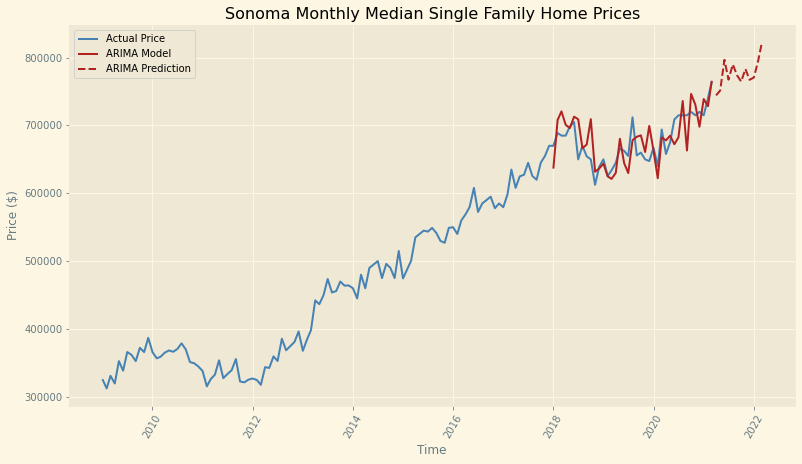

In [393]:
# Plot the Sonoma Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_son['Sonoma'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_son_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model')
plt.plot( df_aft_crisis_son_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction')
plt.title('Sonoma Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [394]:
# margin of error on predictions error

error_list = df_aft_crisis_son_pred['Error ARIMA'].dropna()
error_list.describe([0.025,0.05,0.1,0.5,0.9,0.95,0.975])

count    39.000000
mean      0.005795
std       0.038609
min      -0.073000
2.5%     -0.052100
5%       -0.050100
10%      -0.045400
50%       0.001000
90%       0.044000
95%       0.081100
97.5%     0.091000
max       0.091000
Name: Error ARIMA, dtype: float64

In [395]:
print ('mean of error:', np.mean(error_list))
print ('std deviation of error:', np.std(error_list))
print ('std dev of sample:',statistics.stdev(error_list))
############# 
critical_value = 1.96
std = statistics.stdev(error_list)
sample = len(error_list)
MOE = critical_value * (std / np.sqrt(sample))
print ('margin of error:', MOE)
print ('lower:', np.mean(error_list)-MOE)
print ('highr:', np.mean(error_list)+MOE)
high_bond_rate = 1 + np.mean(error_list)+MOE
low_bond_rate = 1 + np.mean(error_list)-MOE

mean of error: 0.005794871794871794
std deviation of error: 0.03811062136571639
std dev of sample: 0.03860882056785762
margin of error: 0.012117423949920915
lower: -0.006322552155049121
highr: 0.01791229574479271


In [396]:
# higher and lower rate comes from error distribution for 2.5% , 97.5% (95% confidence interval)

df_aft_crisis_son_pred['lower_bond'] = (df_aft_crisis_son_pred['Prediction ARIMA']* (1-0.0521)).astype(int)
df_aft_crisis_son_pred['higher_bond'] = (df_aft_crisis_son_pred['Prediction ARIMA'] * (1.091)).astype(int)

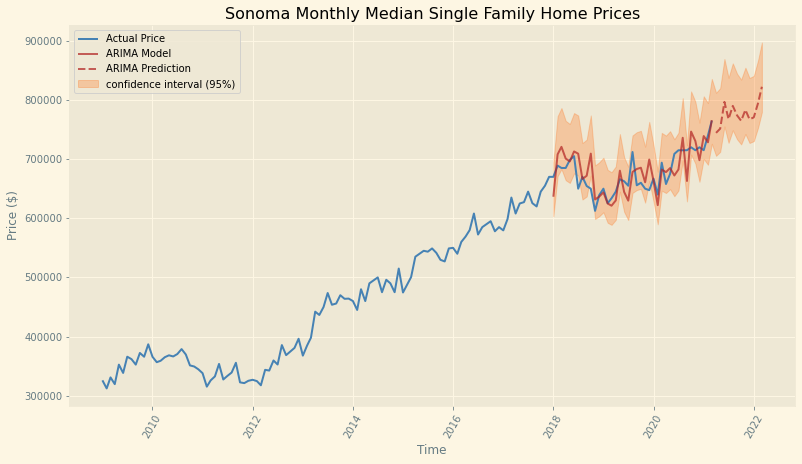

In [397]:
# Plot the Sonoma Single Family Median Price AND ARIMA model (Validation and Prediction)

pred_months = 12
fig, ax = plt.subplots(figsize=(13, 7))
plt.plot( df_aft_crisis_son['Sonoma'], color = 'steelblue', label='Actual Price')
plt.plot( df_aft_crisis_son_pred['Prediction ARIMA'].iloc[:-(pred_months)], color = 'firebrick', label = 'ARIMA Model', alpha=0.7)
plt.plot( df_aft_crisis_son_pred['Prediction ARIMA'].iloc[-(pred_months):], color = 'firebrick', linestyle = '--', label = 'ARIMA Prediction', alpha=0.7)
ax.fill_between(df_aft_crisis_son_pred.index, df_aft_crisis_son_pred['lower_bond'], df_aft_crisis_son_pred['higher_bond'], color='#ff7823', alpha=0.3, label="confidence interval (95%)");
plt.title('Sonoma Monthly Median Single Family Home Prices')
plt.ylabel('Price ($)')
plt.xlabel('Time')
plt.xticks(rotation=60)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

In [398]:
df_aft_son_b = df_aft_crisis_son_train[['Sonoma']].copy()
df_aft_son_b = df_aft_son_b.reset_index()
df_aft_son_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    108 non-null    datetime64[ns]
 1   Sonoma  108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [399]:
df_aft_son_p = df_aft_crisis_son_pred[['Sonoma','Prediction ARIMA','lower_bond','higher_bond']].copy()
df_aft_son_p['Prediction ARIMA'] = df_aft_son_p['Prediction ARIMA'].astype(int)
df_aft_son_p['Sonoma'] = df_aft_son_p['Sonoma'].astype('float64')
df_aft_son_p.index.names = ['Time']
df_aft_son_p = df_aft_son_p.reset_index()
df_aft_son_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              51 non-null     datetime64[ns]
 1   Sonoma            39 non-null     float64       
 2   Prediction ARIMA  51 non-null     int64         
 3   lower_bond        51 non-null     int64         
 4   higher_bond       51 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 KB


In [400]:
df_son = pd.concat([df_aft_son_b, df_aft_son_p])

In [401]:
# change the time column in order to visualize better 
df_son['Time2'] = df_son['Time'].dt.strftime('%b %d %Y')

In [402]:
df_son.iloc[105:115]

Time    Sonoma  Prediction ARIMA  lower_bond  higher_bond  \
105 2017-10-01  645000.0               NaN         NaN          NaN   
106 2017-11-01  655000.0               NaN         NaN          NaN   
107 2017-12-01  670000.0               NaN         NaN          NaN   
0   2018-01-01  670000.0          636390.0    603234.0     694301.0   
1   2018-02-01  689000.0          708018.0    671130.0     772447.0   
2   2018-03-01  685000.0          720716.0    683166.0     786301.0   
3   2018-04-01  685000.0          700907.0    664389.0     764689.0   
4   2018-05-01  698500.0          696011.0    659748.0     759348.0   
5   2018-06-01  705000.0          712964.0    675818.0     777843.0   
6   2018-07-01  650000.0          709151.0    672204.0     773683.0   

           Time2  
105  Oct 01 2017  
106  Nov 01 2017  
107  Dec 01 2017  
0    Jan 01 2018  
1    Feb 01 2018  
2    Mar 01 2018  
3    Apr 01 2018  
4    May 01 2018  
5    Jun 01 2018  
6    Jul 01 2018

In [403]:
# save df_son for use in test2 notebook


df_son.to_pickle('df_son.pickle')